In [1]:
#https://git.aps.anl.gov/rodolakis/Macros_29id/-/blob/master/hklpy/Test_Bluesky_20210616.ipynb
# cd /home/beams/29IDUSER/Documents/User_Macros/
# %run Macros_29id/ScanFunctions_IEX.py

import databroker
from apstools.utils import listruns
from IEX_29id.utils.initialize import *
from IEX_29id.devices.detectors import *
from IEX_29id.devices.beamline_energy import *
from IEX_29id.devices.kappa_motors import *
from IEX_29id.devices.kappa_motors import kappa_motors
from IEX_29id.devices.detectors import scaler
from IEX_29id.devices.slits import SetSlit4
from IEX_29id.devices.slits import slits
from bluesky.plans import scan
from bluesky.callbacks import LiveTable
from bluesky.callbacks.fitting import PeakStats
from bluesky.callbacks.mpl_plotting import plot_peak_stats
import matplotlib.pyplot as plt
import numpy as np

print(list(databroker.catalog))
cat=databroker.catalog['29idd'];print('Number of scans in catalog: '+str(len(cat)))



x_motor=kappa_motors.m2
y_motor=kappa_motors.m3
z_motor=kappa_motors.m4
kphi_motor=kappa_motors.m1
kap_motor=kappa_motors.m7
kth_motor=kappa_motors.m8
tth_motor=kappa_motors.m9
srs1=srs.A1
srs2=srs.A2
srs3=srs.A3
srs4=srs.A4

komega=57.322396707958816

scaler.stage_sigs['preset_time']=0.1

sd.baseline.append(undulator)
sd.baseline.append(mono)
sd.baseline.append(centroid_m3r)
sd.baseline.append(x_motor)
sd.baseline.append(y_motor)
sd.baseline.append(z_motor)
sd.baseline.append(tth_motor)
sd.baseline.append(kth_motor)
sd.baseline.append(kap_motor)
sd.baseline.append(kphi_motor)
sd.baseline.append(select_detector)
sd.baseline.append(srs4)




I Fri-21:30:53 - ############################################################ startup
I Fri-21:30:53 - logging started
I Fri-21:30:53 - logging level = 10


['29idd', '29idd_retired_2021_12_01']
Number of scans in catalog: 109


In [98]:
def d4_gain():
    print('sensitivity:' ,srs.A4.sensitivity_value.get(),srs.A4.sensitivity_unit.get())
    print('gain:',srs.A4.gain.get())
    return srs.A4.gain.get()
    
def d4_input():
    print('Input Offset:', srs.A4.offset_on.get(),'-',srs.A4.offset_cal.get())
    print('Value:',srs.A4.offset_sign.get(),srs.A4.offset_fine.get())
    print('Gain:',srs.A4.offset_value.get(),srs.A4.offset_unit.get())
    # TODO: return value * gain


def uank(tth,kth):
    yield from bps.mv(tth_motor,tth,kth_motor,kth)
    
    
def th2th_plan(start,stop,step,offset):
    npts=int((stop-start)/step+1)
    yield from bp.scan([scaler,D4calc],kth_motor,start+offset,stop+offset,tth_motor,start*2,stop*2,npts)   

def th2thx_plan_test(th_start,th_stop,th_step,x_start,x_step,offset):
    npts=int((th_stop-th_start)/th_step+1)
    x_stop=x_start+npts*x_step
    print('npts:',npts)
    print('x_start:',x_start)
    print('x_stop:',x_stop)
    print('x_step:',x_step)
    
    
def th2thx_plan(th_start,th_stop,th_step,x_start,x_step,offset):
    npts=int((th_stop-th_start)/th_step+1)
    x_stop=x_start+npts*x_step
    yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,th_stop*2,x_motor,x_start,x_stop,npts)       
    
def th2th_N_plan(N,step,offset,plt=True):
    """
    N = section number
    start(N=0) = 1
    overlap=1.5
    range size = 2.25 = (55-1)/12
    """
    start=(N-1)*2.25+1
    stop=N*2.25+1+1.5
    npts=int((stop-start)/step+1)
    yield from bp.scan([scaler,D4calc],kth_motor,start+offset,stop+offset,tth_motor,start*2,stop*2,npts)   
    
    
def plot_latest(pos,det,log=False):
    """
    pos = x_motor (object)
    det = D3
    
    """
    ds=cat[-1].primary.read()
    #ds.plot.scatter(x=pos.name,y=det.name)
    plt.plot(ds[pos.name], ds[det.name])
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    plt.grid(color='lightgrey')
    if log == True:
        plt.yscale('log')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()
    
def plot_latest_plan(pos,det,log=False):
    """
    pos = x_motor (object)
    det = D3
    
    """
    plot_latest(pos,det)
    yield from bps.null()

    
def plot_scatter(run,pos,det,log=False):
    """
    pos= x_motor (object)
    det=D3
    
    """
    ds=cat[run].primary.read()
    ds.plot.scatter(x=pos.name,y=det.name)
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    if log == True:
        plt.yscale('log')
    plt.grid(color='lightgrey')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()

def plot_run(runlist,pos,det,log=False):
    """
    pos= x_motor (object)
    det=D3
    """
    A=0
    i=1
    for n in runlist:
        if isinstance(n,list):
            A=n[1]
            i=n[2]
            n=n[0]
        ds=cat[n].primary.read()
        plt.plot(ds[pos.name], ds[det.name]*i+A)
    if log:
        plt.yscale('log')
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    plt.grid(color='lightgrey')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()
        
def find_z(pos,det,ds=None):
    """
    ds = cat[-1].primary.read()
    det='D3'
    pos='kappa_motors_m4'
    """
    if ds == None:
        ds = cat[-1].primary.read()
    half_intensity=float((np.max(ds[det.name])-np.min(ds[det.name]))/2)
    
    # array
    y_arr = ds[det.name]
    print("Array is : ", np.array(y_arr))

    # element to which nearest value is to be found
    y = half_intensity
    print("Value to which nearest element is to be found: ", y)

    # calculate the difference array
    difference_array = np.absolute(y_arr-y)

    # find the index of minimum element from the array
    index = difference_array.argmin()
    print("Nearest element to the given values is : ", float(y_arr[index]))
    print("Index of nearest value is : ", int(index))


    x_arr = np.array(ds[pos.name])
    print("Corresponding motor position of nearest value is : ", (x_arr[int(index)]))

        
def make_scan_list(StartStopStepLists):
    """
    Creates and returns a np.array with values based on StartStopStepList
    StartStopStepList is a list of lists defining regions for a table array
              StartStopStepList[[start1,stop1,step1],[start1,stop1,step1],...]
    Automatically removes duplicates and sorts into ascending order
    if you want descending
               myarray=XAS_Table(StartStopStepLists)[::-1]
    """
    table_array=np.array([])
    if type(StartStopStepLists) is not list:
        start=StartStopStepLists[0]
        stop=StartStopStepLists[1]
        step=StartStopStepLists[2]
        j=start
        while j<=stop:
            table_array=np.append(table_array, j)
            j+=step
    else:
        for i in range(0,len(StartStopStepLists)):
            start=StartStopStepLists[i][0]
            stop=StartStopStepLists[i][1]
            step=StartStopStepLists[i][2]
            j=start
            while j<=stop:
                table_array=np.append(table_array, j)
                j+=step
    table_array=np.unique(table_array)#removing duplicate
    table_array=np.sort(table_array) #sort into ascending order    

    return table_array.tolist()
  

In [32]:
float(np.array(cat[-1].baseline.read()["undulator_energy_readback"])[0])

0.6656692028045654

In [75]:
cat[-1].baseline.read()["srs_A4"]

<xarray.DataArray 'srs_A4' (time: 2)>
array([2.e-10, 2.e-10])
Coordinates:
  * time     (time) float64 1.639e+09 1.639e+09
Attributes:
    object:   srs_A4

In [116]:
cat[-1].baseline.read()[srs.A4.name]

<xarray.DataArray 'srs_A4' (time: 2)>
array([2.e-07, 2.e-07])
Coordinates:
  * time     (time) float64 1.639e+09 1.639e+09
Attributes:
    object:   srs_A4

In [17]:
cat[-1].baseline.read()

<xarray.Dataset>
Dimensions:                           (time: 2)
Coordinates:
  * time                              (time) float64 1.639e+09 1.639e+09
Data variables: (12/54)
    kappa_motors_m3                   (time) float64 0.242 0.237
    kappa_motors_m3_user_setpoint     (time) float64 0.0 0.0
    kappa_motors_m3_sync              (time) int64 0 0
    kappa_motors_m3_desc              (time) <U1 'y' 'y'
    kappa_motors_m3_homf              (time) int64 0 0
    kappa_motors_m3_dval              (time) float64 0.0 0.0
    ...                                ...
    kappa_motors_m1                   (time) float64 57.04 57.04
    kappa_motors_m1_user_setpoint     (time) float64 57.05 57.05
    kappa_motors_m1_sync              (time) int64 0 0
    kappa_motors_m1_desc              (time) <U4 'kphi' 'kphi'
    kappa_motors_m1_homf              (time) int64 0 0
    kappa_motors_m1_dval              (time) float64 85.27 85.27

In [36]:
run=cat[-1]
base= run.baseline.read()
print((base.keys()))

KeysView(<xarray.Dataset>
Dimensions:                           (time: 2)
Coordinates:
  * time                              (time) float64 1.639e+09 1.639e+09
Data variables: (12/54)
    kappa_motors_m3                   (time) float64 0.242 0.237
    kappa_motors_m3_user_setpoint     (time) float64 0.0 0.0
    kappa_motors_m3_sync              (time) int64 0 0
    kappa_motors_m3_desc              (time) <U1 'y' 'y'
    kappa_motors_m3_homf              (time) int64 0 0
    kappa_motors_m3_dval              (time) float64 0.0 0.0
    ...                                ...
    kappa_motors_m1                   (time) float64 57.04 57.04
    kappa_motors_m1_user_setpoint     (time) float64 57.05 57.05
    kappa_motors_m1_sync              (time) int64 0 0
    kappa_motors_m1_desc              (time) <U4 'kphi' 'kphi'
    kappa_motors_m1_homf              (time) int64 0 0
    kappa_motors_m1_dval              (time) float64 85.27 85.27)


In [6]:
scaler.select_channels(['D4'])

In [7]:
kth_motor.name

'kappa_motors_m8'

In [8]:
ps=PeakStats(kth_motor.name,D4.name)

In [9]:
4/0.05+1

81.0



Transient Scan ID: 77     Time: 2021-12-03 11:00:05
Persistent Unique Scan ID: '5e46b379-da36-4c53-8e53-c8e23ca762c9'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 680.0081754                    |
|              mono_mirror_pitch | 3.178629150390625              |
|             mono_grating_pitch | 4.3091229003906255             |
|                    centroidM3R | 111.29936266886226             |
|                kappa_motors_m2 | 400.088                        |
|                kappa_motors_m3 | 0.231                          |
|                kappa_motors_m4 | -96.162                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.04514238179206              |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('5e46b379-da36-4c53-8e53-c8e23ca762c9',)

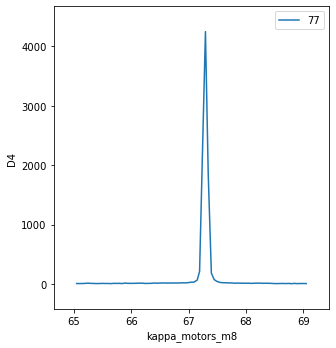

In [13]:
RE(bp.rel_scan([scaler],kth_motor,-2,2,4/0.05+1),[ps])

In [5]:
kth_motor.move(67.3)

MoveStatus(done=True, pos=kappa_motors_m8, elapsed=1.1, success=True, settle_time=0.0)

In [6]:
ps = PeakStats(kth_motor.name, D4.name)



Transient Scan ID: 79     Time: 2021-12-03 11:11:24
Persistent Unique Scan ID: 'ad2eef68-e167-4e83-a6b4-cea927425cde'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6657769083976746             |
|                    mono_energy | 679.9954396                    |
|              mono_mirror_pitch | 3.1786419677734377             |
|             mono_grating_pitch | 4.309086889648437              |
|                    centroidM3R | 111.53458328218976             |
|                kappa_motors_m2 | 400.087                        |
|                kappa_motors_m3 | 0.234                          |
|                kappa_motors_m4 | -96.167                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.30014238179206              |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('ad2eef68-e167-4e83-a6b4-cea927425cde',)

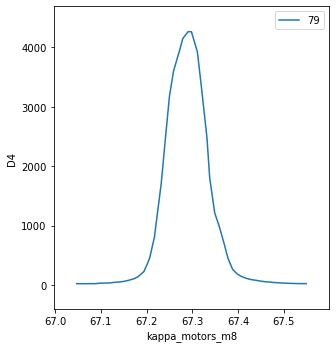

In [22]:
RE(bp.rel_scan([scaler], kth_motor, -0.25, 0.25, 51), [ps])

In [25]:
ps.reset()

{'color': 'k'} cen
{'color': 'r'} com
{'color': 'b'} max
{'color': 'm'} min


{'points': <matplotlib.lines.Line2D at 0x7f2fc1381190>,
 'vlines': [<matplotlib.lines.Line2D at 0x7f2fc3b41b50>,
 'legend': <matplotlib.legend.Legend at 0x7f2fc1277790>}

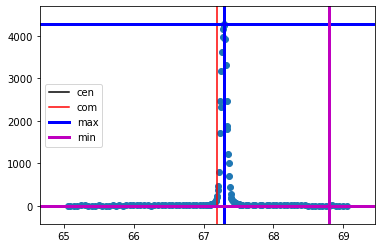

In [26]:
plot_peak_stats(ps)

In [ ]:
ps



Transient Scan ID: 79     Time: 2021-12-03 11:11:24
Persistent Unique Scan ID: 'ad2eef68-e167-4e83-a6b4-cea927425cde'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6657769083976746             |
|                    mono_energy | 679.9954396                    |
|              mono_mirror_pitch | 3.1786419677734377             |
|             mono_grating_pitch | 4.309086889648437              |
|                    centroidM3R | 111.53458328218976             |
|                kappa_motors_m2 | 400.087                        |
|                kappa_motors_m3 | 0.234                          |
|                kappa_motors_m4 | -96.167                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.30014238179206              |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('ad2eef68-e167-4e83-a6b4-cea927425cde',)

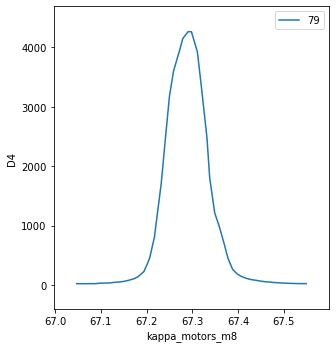

In [22]:
RE(bp.rel_scan([scaler], kth_motor, -0.25, 0.25, 51), [ps])

In [23]:
ps.stats

Stats(min=(68.79114238179207, 4.0), max=(67.29114238179207, 4263.0), com=67.18633047001168, cen=67.28688701741433, crossings=array([67.2393185 , 67.335864  , 67.2371966 , 67.33516897]), fwhm=0.09585046495629967, lin_bkg=None)

{'color': 'k'} cen
{'color': 'r'} com
{'color': 'b'} max
{'color': 'm'} min


{'points': <matplotlib.lines.Line2D at 0x7f2fc35455e0>,
 'vlines': [<matplotlib.lines.Line2D at 0x7f2ff0ff52b0>,
 'legend': <matplotlib.legend.Legend at 0x7f2ff0ff5370>}

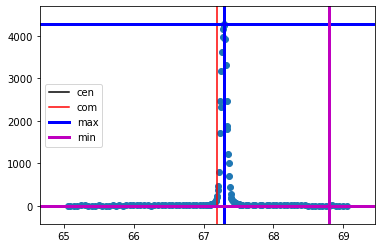

In [24]:
plot_peak_stats(ps)

In [27]:
ps2=PeakStats(kth_motor.name,D4.name)



Transient Scan ID: 80     Time: 2021-12-03 11:15:24
Persistent Unique Scan ID: '26daa98b-0122-487a-9b16-a5d56ba4d080'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6655617356300354             |
|                    mono_energy | 679.9929884                    |
|              mono_mirror_pitch | 3.1786016845703124             |
|             mono_grating_pitch | 4.309106420898438              |
|                    centroidM3R | 111.55680936810889             |
|                kappa_motors_m2 | 400.08500000000004             |
|                kappa_motors_m3 | 0.231                          |
|                kappa_motors_m4 | -96.167                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.30014238179206              |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('26daa98b-0122-487a-9b16-a5d56ba4d080',)

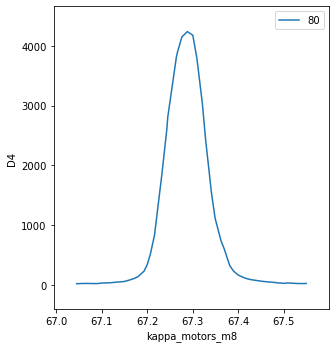

In [28]:
RE(bp.rel_scan([scaler], kth_motor, -0.25, 0.25, 51), [ps2])

{'color': 'k'} cen
{'color': 'r'} com
{'color': 'b'} max
{'color': 'm'} min


{'points': <matplotlib.lines.Line2D at 0x7f2fc13ad430>,
 'vlines': [<matplotlib.lines.Line2D at 0x7f2fc13ad490>,
 'legend': <matplotlib.legend.Legend at 0x7f2fc13ad160>}

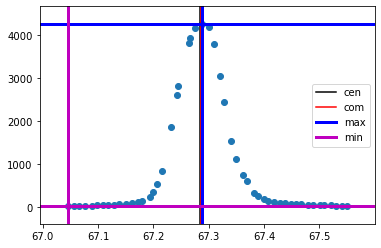

In [29]:
plot_peak_stats(ps2)

In [30]:
ps2.stats.com

67.28578205781558

In [31]:
kth_motor.move(ps2.stats.com)

MoveStatus(done=True, pos=kappa_motors_m8, elapsed=0.2, success=True, settle_time=0.0)

In [33]:
ps2.stats.com-57.045-10

0.24078205781557926

In [38]:
myomega=round(ps2.stats.com-10,3)

In [39]:
myomega

57.286

In [40]:
kth_motor.move(myomega)

MoveStatus(done=True, pos=kappa_motors_m8, elapsed=7.4, success=True, settle_time=0.0)

In [45]:
tth_motor.move(4.87)  # switched to D3

MoveStatus(done=True, pos=kappa_motors_m9, elapsed=0.0, success=True, settle_time=0.0)

In [43]:
scaler.select_channels([D3.name])

In [46]:
z_motor.move(-1000)

MoveStatus(done=True, pos=kappa_motors_m4, elapsed=4.6, success=True, settle_time=0.0)

In [48]:
ps3=PeakStats(tth_motor.name,D3.name)



Transient Scan ID: 81     Time: 2021-12-03 11:30:25
Persistent Unique Scan ID: '07090325-d528-46b7-a8e3-dcb6528addb4'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6657769083976746             |
|                    mono_energy | 679.9926266                    |
|              mono_mirror_pitch | 3.178580322265625              |
|             mono_grating_pitch | 4.309096044921875              |
|                    centroidM3R | 111.15627153423273             |
|                kappa_motors_m2 | 400.08                         |
|                kappa_motors_m3 | 0.23800000000000002            |
|                kappa_motors_m4 | -1000.253                      |
|                kappa_motors_m9 | 4.870000000000001              |
|                kappa_motors_m8 | 57.286142381792075             |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('07090325-d528-46b7-a8e3-dcb6528addb4',)

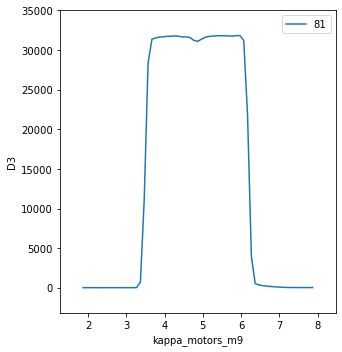

In [51]:
RE(bp.rel_scan([scaler],tth_motor,-3,3,61),[ps3])

{'color': 'k'} cen
{'color': 'r'} com
{'color': 'b'} max
{'color': 'm'} min


{'points': <matplotlib.lines.Line2D at 0x7f2fb2f0efd0>,
 'vlines': [<matplotlib.lines.Line2D at 0x7f2fb2f00e80>,
 'legend': <matplotlib.legend.Legend at 0x7f2fb2f02280>}

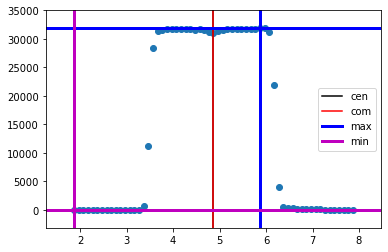

In [52]:
plot_peak_stats(ps3)

In [53]:
ps3.stats.cen

4.850328685541567

In [54]:
ps3.stats.com

4.851699153938105

In [55]:
tth_motor.move(4.852)

MoveStatus(done=True, pos=kappa_motors_m9, elapsed=0.2, success=True, settle_time=0.0)

In [56]:
z_motor.move(-100)

MoveStatus(done=True, pos=kappa_motors_m4, elapsed=4.6, success=True, settle_time=0.0)

In [57]:
myomega

57.286



Transient Scan ID: 82     Time: 2021-12-03 11:34:35
Persistent Unique Scan ID: '1f847f7f-af30-4b03-9682-733a02221657'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 679.9979813                    |
|              mono_mirror_pitch | 3.17865478515625               |
|             mono_grating_pitch | 4.309093603515625              |
|                    centroidM3R | 110.72212779640773             |
|                kappa_motors_m2 | 400.075                        |
|                kappa_motors_m3 | 0.246                          |
|                kappa_motors_m4 | -99.824                        |
|                kappa_motors_m9 | 4.852                          |
|                kappa_motors_m8 | 57.286142381792075             |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('1f847f7f-af30-4b03-9682-733a02221657',)

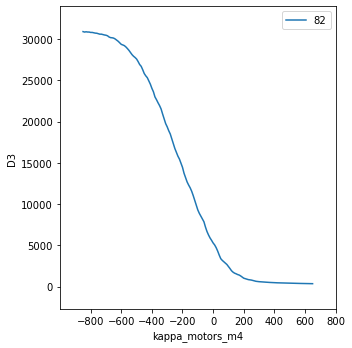

In [58]:
RE(bp.rel_scan([scaler],z_motor,-750,750,151))

In [59]:
z_motor.move(-300)

MoveStatus(done=True, pos=kappa_motors_m4, elapsed=1.2, success=True, settle_time=0.0)



Transient Scan ID: 83     Time: 2021-12-03 11:38:18
Persistent Unique Scan ID: 'a74d5620-79ad-4cb8-b19d-ac1d81f5662c'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 679.9966607                    |
|              mono_mirror_pitch | 3.1785552978515628             |
|             mono_grating_pitch | 4.309113134765625              |
|                    centroidM3R | 110.99761708367703             |
|                kappa_motors_m2 | 400.08                         |
|                kappa_motors_m3 | 0.24                           |
|                kappa_motors_m4 | -300.228                       |
|                kappa_motors_m9 | 4.852                          |
|                kappa_motors_m8 | 57.286142381792075             |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('a74d5620-79ad-4cb8-b19d-ac1d81f5662c',)

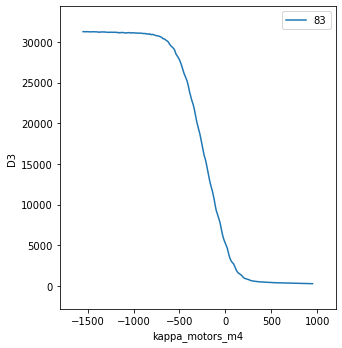

In [60]:
RE(bp.rel_scan([scaler],z_motor,-1250,1250,251))

In [61]:
find_z(z_motor,D3)

Array is :  [31245. 31258. 31253. 31230. 31251. 31252. 31232. 31238. 31220. 31234.
 31243. 31240. 31244. 31244. 31230. 31217. 31224. 31175. 31198. 31202.
 31229. 31196. 31208. 31230. 31197. 31185. 31193. 31177. 31157. 31183.
 31187. 31177. 31166. 31173. 31187. 31172. 31154. 31172. 31145. 31093.
 31144. 31130. 31151. 31138. 31148. 31102. 31087. 31106. 31106. 31128.
 31137. 31116. 31084. 31126. 31105. 31102. 31112. 31099. 31105. 31079.
 31068. 31059. 31079. 31071. 31039. 31029. 31025. 31020. 31022. 30977.
 30966. 30978. 30926. 30974. 30892. 30886. 30919. 30875. 30832. 30781.
 30761. 30747. 30725. 30680. 30632. 30591. 30520. 30400. 30359. 30330.
 30234. 30144. 30082. 29958. 29754. 29608. 29473. 29355. 29254. 29143.
 28923. 28567. 28359. 28200. 28010. 27807. 27518. 27230. 26854. 26496.
 26127. 25848. 25584. 25291. 24907. 24422. 23868. 23429. 22989. 22631.
 22272. 21838. 21270. 20670. 20095. 19678. 19204. 18814. 18263. 17727.
 17136. 16534. 16002. 15641. 15188. 14594. 14038. 13465. 12892. 1

In [63]:
z_motor.move(-220)

MoveStatus(done=True, pos=kappa_motors_m4, elapsed=0.5, success=True, settle_time=0.0)

In [64]:
myomega

57.286

In [65]:
RE(set_detector_plan('d4'))

()

In [70]:
scaler.select_channels(['D4']); ps4=PeakStats(kth_motor.name,D4.name)

In [66]:
tth_motor.move(30)

MoveStatus(done=True, pos=kappa_motors_m9, elapsed=36.9, success=True, settle_time=0.0)

In [68]:
kth_motor.move(myomega+15)

MoveStatus(done=True, pos=kappa_motors_m8, elapsed=11.4, success=True, settle_time=0.0)



Transient Scan ID: 84     Time: 2021-12-03 11:52:17
Persistent Unique Scan ID: 'd8e896e8-233c-46e3-994f-1f5bb7b354ca'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6659919023513794             |
|                    mono_energy | 679.9940195                    |
|              mono_mirror_pitch | 3.1786322021484374             |
|             mono_grating_pitch | 4.30911435546875               |
|                    centroidM3R | 111.07565982404692             |
|                kappa_motors_m2 | 400.082                        |
|                kappa_motors_m3 | 0.231                          |
|                kappa_motors_m4 | -219.88                        |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.28614238179208              |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('d8e896e8-233c-46e3-994f-1f5bb7b354ca',)

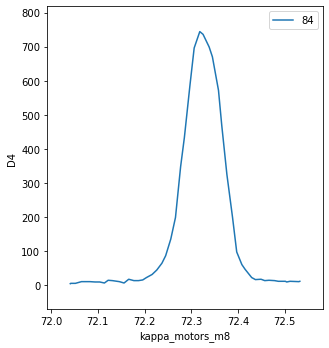

In [71]:
RE(bp.rel_scan([scaler],kth_motor,-0.25,0.25,51),ps4)

In [73]:
ps4.stats

Stats(min=(72.04114238179207, 5.0), max=(72.31814238179206, 744.0), com=72.32239670795882, cen=72.32599881561558, crossings=array([72.2796365 , 72.37236113]), fwhm=0.09272463235292605, lin_bkg=None)

{'color': 'k'} cen
{'color': 'r'} com
{'color': 'b'} max
{'color': 'm'} min


{'points': <matplotlib.lines.Line2D at 0x7f2fb0d95fd0>,
 'vlines': [<matplotlib.lines.Line2D at 0x7f2fb0c9c0d0>,
 'legend': <matplotlib.legend.Legend at 0x7f2fb0c9ce50>}

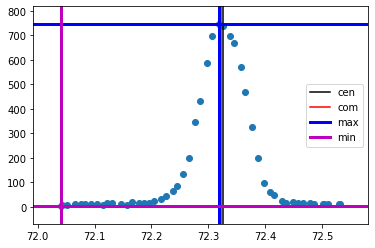

In [74]:
plot_peak_stats(ps4)

In [17]:
57.045+15

72.045

In [19]:
72.322-72.045

0.277000000000001

In [20]:
myomega+15

72.32239670795882

In [75]:
ps4.stats.com-(57.045+15)

0.27739670795881466

In [16]:
myomega   #71.607

72.32239670795882

In [76]:
myomega-57.045

0.24099999999999966

In [79]:
myomega=ps4.stats.com-15

In [80]:
myomega

57.322396707958816

In [13]:
myomega+15

72.32239670795882

In [82]:
kth_motor.move(myomega+15)

MoveStatus(done=True, pos=kappa_motors_m8, elapsed=0.0, success=True, settle_time=0.0)

In [84]:
mprint()  # beam at the center of the MCP

x,y,z,tth,th,chi,phi = [400.0,0.0,-220.0,35.05,71.61,133.639,56.32]


[400.0, 0.0, -220.0, 35.05, 71.61, 133.639, 56.32]

In [85]:
30-35.05

-5.049999999999997

In [88]:
18.7316-5.05

13.6816

In [11]:
(5--5)/0.1

100.0

In [21]:
kth_motor.move(myomega+1)

MoveStatus(done=True, pos=kappa_motors_m8, elapsed=10.6, success=True, settle_time=0.0)

In [22]:
tth_motor.move(2)

MoveStatus(done=True, pos=kappa_motors_m9, elapsed=0.0, success=True, settle_time=0.0)

# S K-edge

In [23]:
def th2th_plan(start,stop,step,offset):
    npts=(stop-start)/step+1
    yield from bp.scan([scaler],kth_motor,start+offset,stop+offset,tth_motor,start*2,stop*2,npts)  



Transient Scan ID: 85     Time: 2021-12-03 12:54:45
Persistent Unique Scan ID: 'ef3ffdd7-88da-4db7-8f11-08a26d2a11b5'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 680.0128339                    |
|              mono_mirror_pitch | 3.17863037109375               |
|             mono_grating_pitch | 4.309107641601563              |
|                    centroidM3R | 110.3485171896998              |
|                kappa_motors_m2 | 399.987                        |
|                kappa_motors_m3 | 0.256                          |
|                kappa_motors_m4 | -220.005                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|        

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


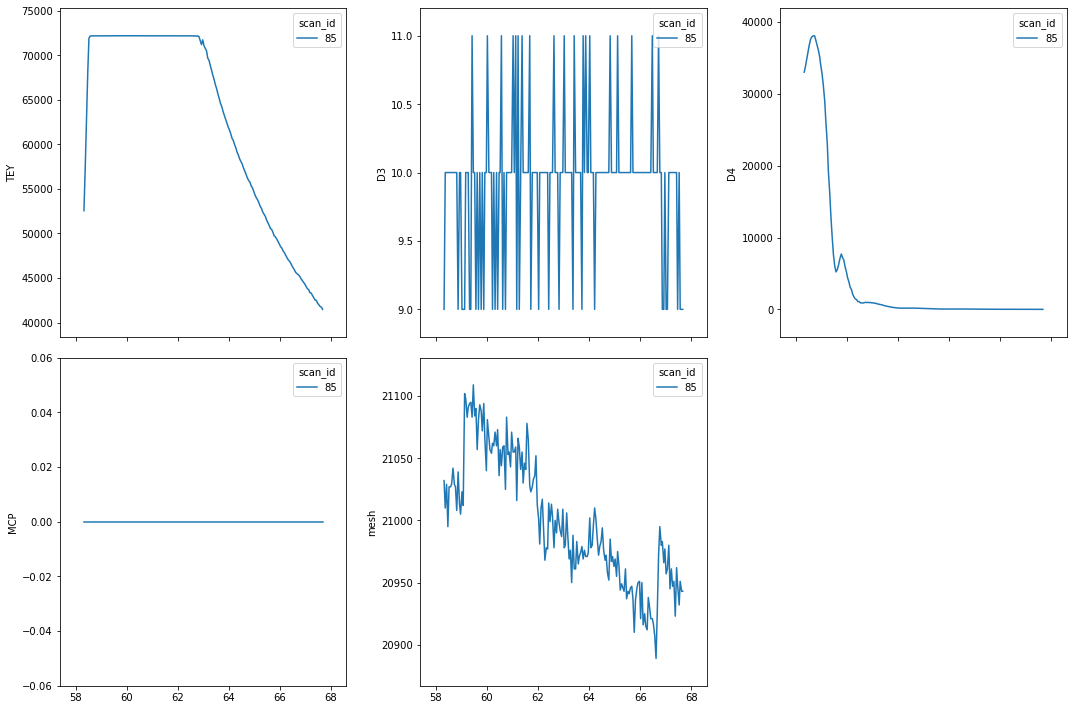

In [24]:
RE(th2th_plan(1,20,0.05,myomega))

In [25]:
RE.stop()

Stopping: running cleanup and marking exit_status as 'success'...
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+
generator scan ['ef3ffdd7'] (scan num: 85)


/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 679.9950778                    |
|              mono_mirror_pitch | 3.178577880859375              |
|             mono_grating_pitch | 4.30910703125                  |
|                    centroidM3R | 110.60189832983481             |
|                kappa_motors_m2 | 399.993                        |
|                kappa_motors_m3 | 0.24                           |
|                kappa_motors_m4 | -220.0                         |
|                kappa_motors_m9 | 20.8                           |
|                kappa_motors_m8 | 67.72214238179001              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.044987039999995             |
+--------------------------------+--------------------------------+





('ef3ffdd7-88da-4db7-8f11-08a26d2a11b5',)

In [30]:
srs.A4.gain.get()

5.000000000000001e-07

In [33]:
srs.A4.sensitivity_unit.get()

'nA/V'

In [34]:
srs.A4.sensitivity_value.get()

'500'

In [49]:
d4_input()

Input Offset: OFF - UNCAL
Value: + 15
Gain: 500 pA


# 2nd range: 

In [71]:
def d4_gain():
    print('sensitivity:' ,srs.A4.sensitivity_value.get(),srs.A4.sensitivity_unit.get())
    print('gain:',srs.A4.gain.get())
    return srs.A4.gain.get()
    
def d4_input():
    print('Input Offset:', srs.A4.offset_on.get(),'-',srs.A4.offset_cal.get())
    print('Value:',srs.A4.offset_sign.get(),srs.A4.offset_fine.get())
    print('Gain:',srs.A4.offset_value.get(),srs.A4.offset_unit.get())
    # TODO: return value * gain


In [72]:
d4_gain()

sensitivity: 100 pA/V
gain: 1e-10


1e-10

In [48]:
d4_input()

Input Offset: OFF - UNCAL
Value: + 15
Gain: 500 pA




Transient Scan ID: 86     Time: 2021-12-03 13:15:50
Persistent Unique Scan ID: 'ef9c2738-c24d-4a43-b05d-8143933572fb'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6656692028045654             |
|                    mono_energy | 680.0085372                    |
|              mono_mirror_pitch | 3.1786126708984375             |
|             mono_grating_pitch | 4.309086889648437              |
|                    centroidM3R | 110.70181216586755             |
|                kappa_motors_m2 | 399.98900000000003             |
|                kappa_motors_m3 | 0.242                          |
|                kappa_motors_m4 | -219.995                       |
|                kappa_motors_m9 | 20.8                           |
|                kappa_motors_m8 | 67.72214238179001              |
|                kappa_motors_m7 | 134.75600000000003             |
|        

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6658844351768494             |
|                    mono_energy | 680.0083292                    |
|              mono_mirror_pitch | 3.17859619140625               |
|             mono_grating_pitch | 4.30911435546875               |
|                    centroidM3R | 110.72973262523149             |
|                kappa_motors_m2 | 399.991                        |
|                kappa_motors_m3 | 0.23700000000000002            |
|                kappa_motors_m4 | -219.997                       |
|                kappa_motors_m9 | 40.0                           |
|                kappa_motors_m8 | 77.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04498164                    |
+--------------------------------+--------------------------------+





('ef9c2738-c24d-4a43-b05d-8143933572fb',)

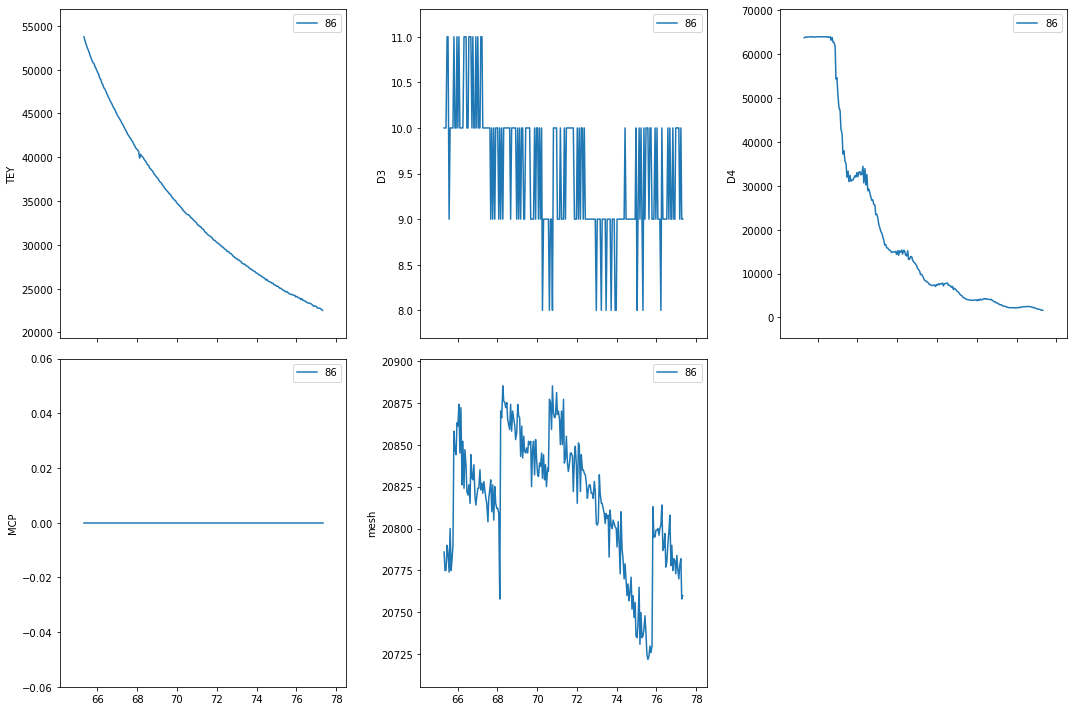

In [50]:
RE(th2th_plan(8,20,0.05,myomega))

In [62]:
def plot_run(runlist,pos,det,log=False):
    """
    pos= x_motor (object)
    det=D3
    """
    A=0
    i=1
    for n in runlist:
        if isinstance(n,list):
            A=n[1]
            i=n[2]
            n=n[0]
        ds=cat[n].primary.read()
        plt.plot(ds[pos.name], ds[det.name]*i+A)
    if log:
        plt.yscale('log')
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    plt.grid(color='lightgrey')
    

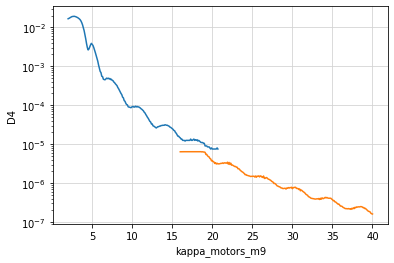

In [73]:
plot_run([[85,0,5e-7],[86,0,1e-10]],tth_motor,D4,log=True)

In [59]:
A=0
i=1
n=[1,2,3]
if isinstance(n,list):
    A=n[1]
    i=n[2]
    n=n[0]
print(n,A,i)

1 2 3


In [14]:
# srs.A4.gain

{
'com':
    {}
,
'cen':
    {}
,
'max':
    {}
,
'min':
    {}
,
'fwhm':
    {}
,
}

In [45]:
srs.A4.sensitivity_unit.put(1)

In [39]:
srs.A4.sensitivity_value.put(8)

In [47]:
d4_gain()

sensitivity: 500 nA/V
gain: 5.000000000000001e-07


5.000000000000001e-07

In [46]:
d4_input()

Input Offset: OFF - UNCAL
Value: + 15
Gain: 500 pA


In [51]:
x_motor.move(600)

MoveStatus(done=True, pos=kappa_motors_m2, elapsed=1.1, success=True, settle_time=0.0)



Transient Scan ID: 87     Time: 2021-12-03 14:52:24
Persistent Unique Scan ID: '42b90068-918d-4a48-9e4a-8eda0e0f46eb'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6659919023513794             |
|                    mono_energy | 679.9995009                    |
|              mono_mirror_pitch | 3.1786120605468753             |
|             mono_grating_pitch | 4.309110693359375              |
|                    centroidM3R | 111.75490211062035             |
|                kappa_motors_m2 | 599.976                        |
|                kappa_motors_m3 | 0.249                          |
|                kappa_motors_m4 | -219.977                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|        

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6657769083976746             |
|                    mono_energy | 679.9935221                    |
|              mono_mirror_pitch | 3.1786065673828126             |
|             mono_grating_pitch | 4.309089331054688              |
|                    centroidM3R | 111.84411449563753             |
|                kappa_motors_m2 | 600.02                         |
|                kappa_motors_m3 | 0.244                          |
|                kappa_motors_m4 | -219.994                       |
|                kappa_motors_m9 | 12.0                           |
|                kappa_motors_m8 | 63.32314238179001              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04489812                    |
|                select_detector | d4                             |
+-----------------

('42b90068-918d-4a48-9e4a-8eda0e0f46eb',)

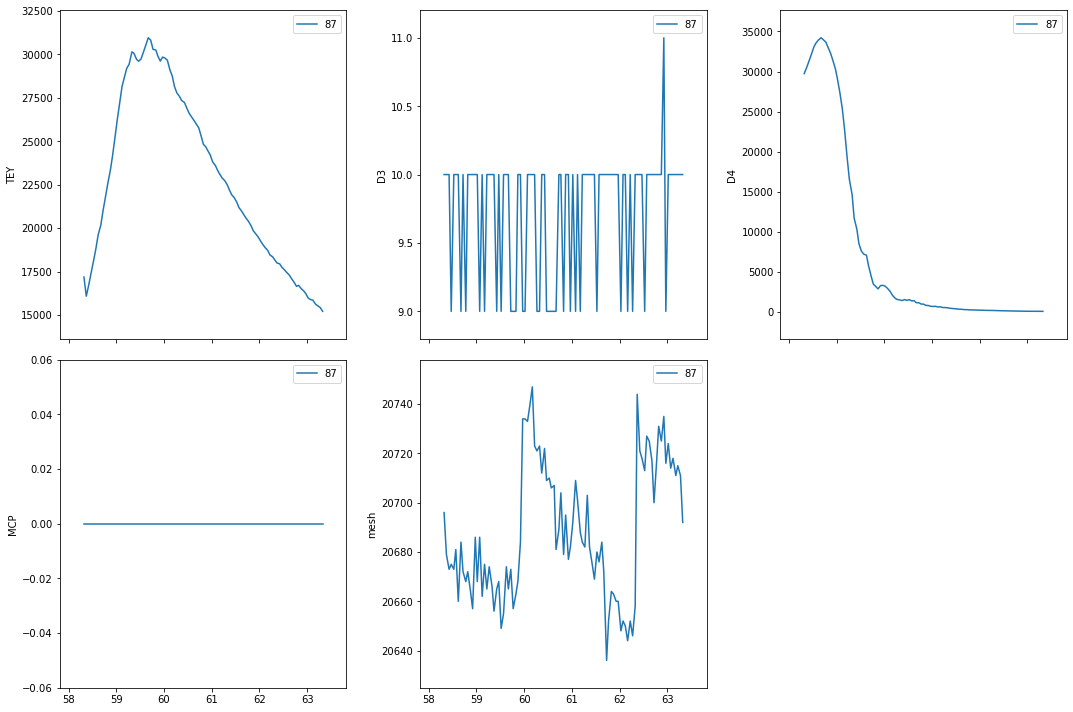

In [52]:
RE(th2th_plan(1,6,0.05,myomega))

In [60]:
srs.A4.sensitivity_unit.put(1)

In [61]:
srs.A4.sensitivity_value.put(1)

In [62]:
d4_gain()

sensitivity: 2 nA/V
gain: 2e-09


2e-09

In [63]:
x_motor.move(800)

MoveStatus(done=True, pos=kappa_motors_m2, elapsed=1.1, success=True, settle_time=0.0)



Transient Scan ID: 88     Time: 2021-12-03 14:58:00
Persistent Unique Scan ID: '077ae850-3e95-4451-926f-31bbed7d4099'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6657769083976746             |
|                    mono_energy | 680.0000889                    |
|              mono_mirror_pitch | 3.1786260986328125             |
|             mono_grating_pitch | 4.3090966552734375             |
|                    centroidM3R | 111.32747256139918             |
|                kappa_motors_m2 | 799.9780000000001              |
|                kappa_motors_m3 | 0.23600000000000002            |
|                kappa_motors_m4 | -219.993                       |
|                kappa_motors_m9 | 12.0                           |
|                kappa_motors_m8 | 63.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('077ae850-3e95-4451-926f-31bbed7d4099',)

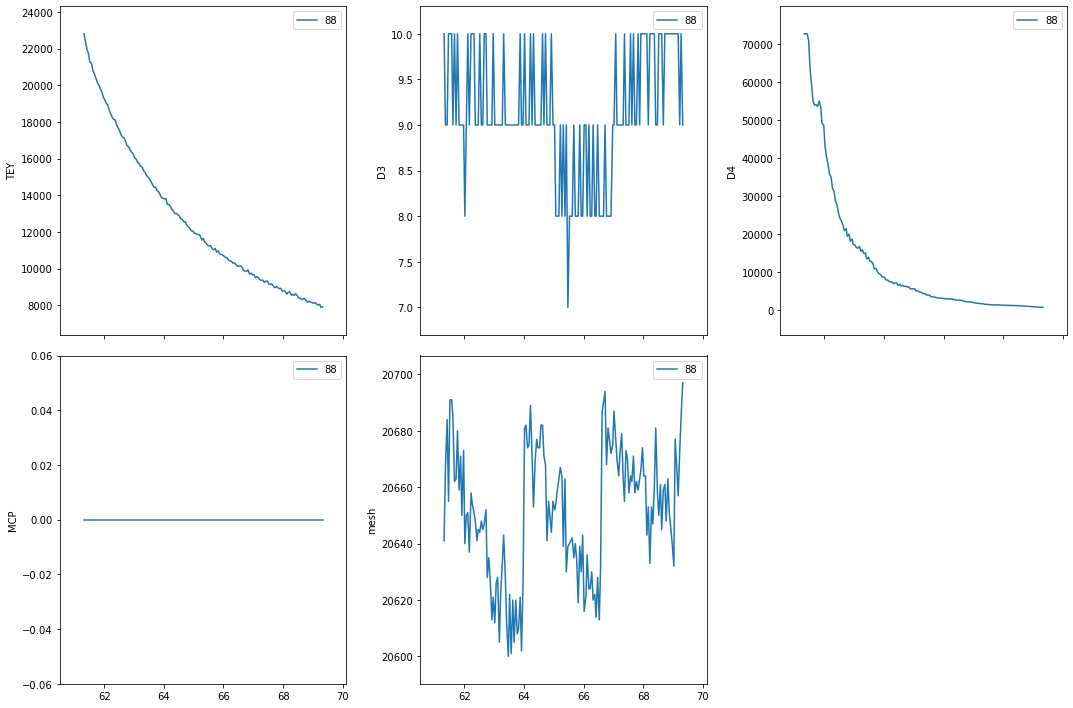

In [64]:
RE(th2th_plan(4,12,0.05,myomega))

In [67]:
d4_gain()

sensitivity: 100 pA/V
gain: 1e-10


1e-10

In [68]:
x_motor.move(1000)

MoveStatus(done=True, pos=kappa_motors_m2, elapsed=1.1, success=True, settle_time=0.0)



Transient Scan ID: 89     Time: 2021-12-03 15:04:49
Persistent Unique Scan ID: '812a4f1e-31bc-4779-b7c2-703fbdc2153f'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6656692028045654             |
|                    mono_energy | 680.0113685                    |
|              mono_mirror_pitch | 3.1785919189453127             |
|             mono_grating_pitch | 4.309093603515625              |
|                    centroidM3R | 111.8154142994962              |
|                kappa_motors_m2 | 999.9590000000001              |
|                kappa_motors_m3 | 0.249                          |
|                kappa_motors_m4 | -219.988                       |
|                kappa_motors_m9 | 24.0                           |
|                kappa_motors_m8 | 69.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('812a4f1e-31bc-4779-b7c2-703fbdc2153f',)

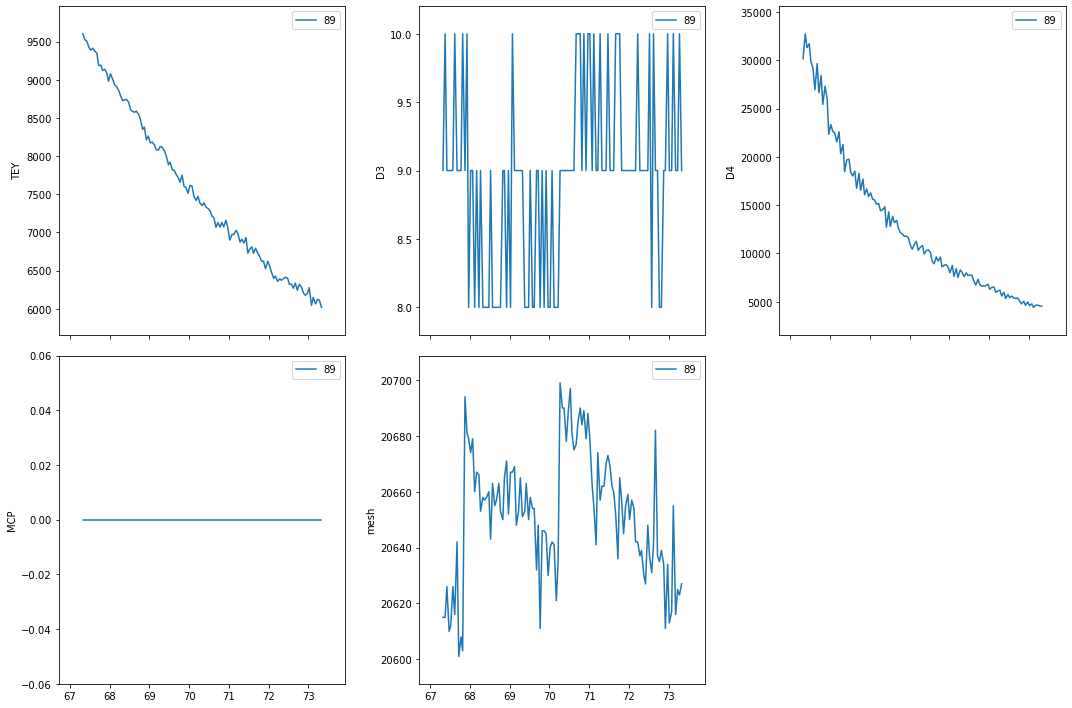

In [69]:
RE(th2th_plan(10,16,0.05,myomega))

In [72]:
d4_gain()

sensitivity: 20 pA/V
gain: 2e-11


2e-11

In [ ]:
x_motor.move(1200)



Transient Scan ID: 90     Time: 2021-12-03 15:09:50
Persistent Unique Scan ID: 'c47ae403-a9bb-4093-97ca-345842d26580'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6659919023513794             |
|                    mono_energy | 679.9986054                    |
|              mono_mirror_pitch | 3.1785900878906252             |
|             mono_grating_pitch | 4.30908994140625               |
|                    centroidM3R | 112.11318592840333             |
|                kappa_motors_m2 | 1000.102                       |
|                kappa_motors_m3 | 0.234                          |
|                kappa_motors_m4 | -219.989                       |
|                kappa_motors_m9 | 32.0                           |
|                kappa_motors_m8 | 73.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|        

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.6655617356300354             |
|                    mono_energy | 680.0138741                    |
|              mono_mirror_pitch | 3.178607788085938              |
|             mono_grating_pitch | 4.309120458984375              |
|                    centroidM3R | 112.60213566874087             |
|                kappa_motors_m2 | 1000.1080000000001             |
|                kappa_motors_m3 | 0.23500000000000001            |
|                kappa_motors_m4 | -219.989                       |
|                kappa_motors_m9 | 40.0                           |
|                kappa_motors_m8 | 77.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04489271999999              |
|                select_detector | d4                             |
+-----------------

('c47ae403-a9bb-4093-97ca-345842d26580',)

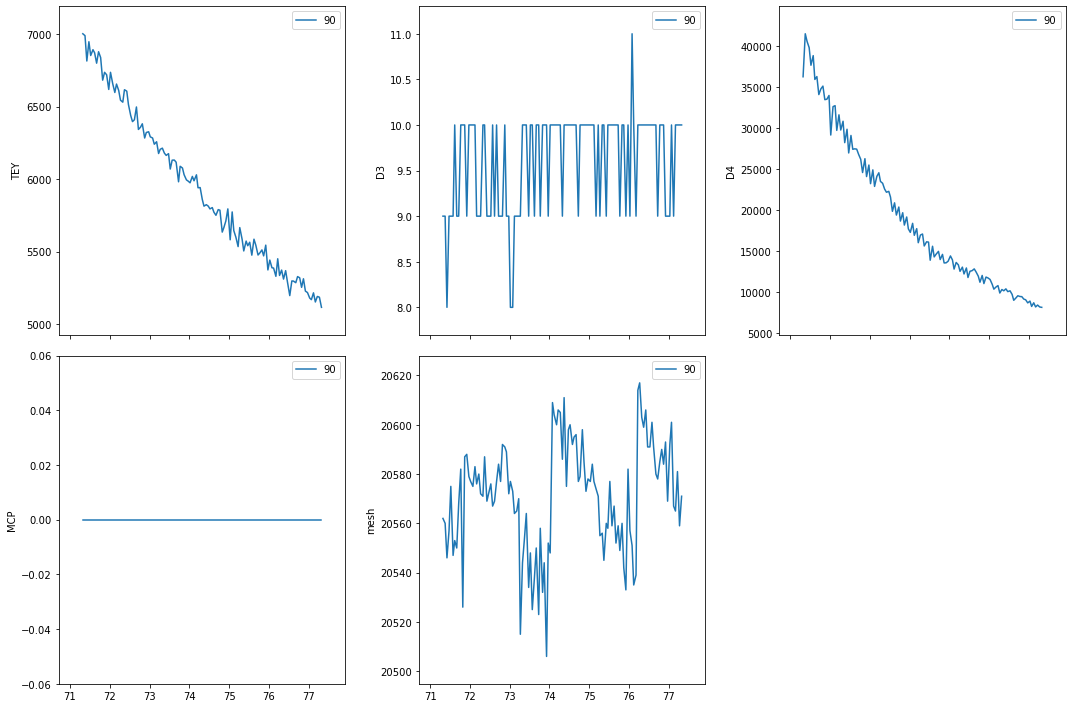

In [73]:
RE(th2th_plan(14,20,0.05,myomega))

In [81]:
cat[-1].baseline.read()['kappa_motors_m4']

<xarray.DataArray 'kappa_motors_m4' (time: 2)>
array([-219.989, -219.989])
Coordinates:
  * time     (time) float64 1.639e+09 1.639e+09
Attributes:
    object:   kappa_motors_m4

In [83]:
cat[87].baseline.read()

<xarray.Dataset>
Dimensions:                           (time: 2)
Coordinates:
  * time                              (time) float64 1.639e+09 1.639e+09
Data variables: (12/56)
    kappa_motors_m7                   (time) float64 134.8 134.8
    kappa_motors_m7_user_setpoint     (time) float64 134.8 134.8
    kappa_motors_m7_sync              (time) int64 0 0
    kappa_motors_m7_desc              (time) <U3 'kap' 'kap'
    kappa_motors_m7_homf              (time) int64 0 0
    kappa_motors_m7_dval              (time) float64 179.2 179.2
    ...                                ...
    kappa_motors_m3_user_setpoint     (time) float64 0.0 0.0
    kappa_motors_m3_sync              (time) int64 0 0
    kappa_motors_m3_desc              (time) <U1 'y' 'y'
    kappa_motors_m3_homf              (time) int64 0 0
    kappa_motors_m3_dval              (time) float64 0.0 0.0
    centroidM3R                       (time) float64 111.8 111.8

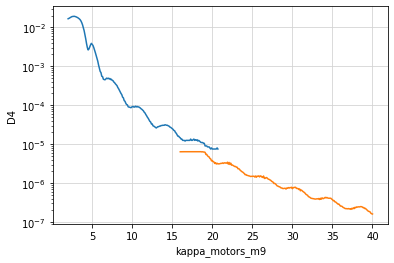

In [86]:
 plot_run([[85,0,5e-7],[86,0,1e-10]],tth_motor,D4
   ...: ,log=True)

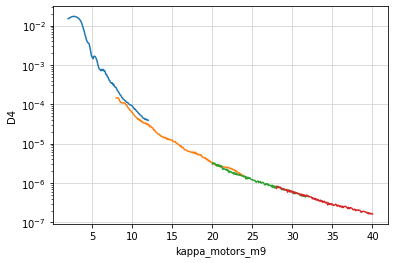

In [85]:
plot_run([[87,0,5e-7],[88,0,2e-9],[89,0,1e-10],[90,0,2e-11]],tth_motor,D4,log=True)

# Going to O-Kedge

In [88]:
undulator.energy.get()

UndulatorEnergyTuple(setpoint=0.529501, readback=0.4972343444824219, done=True)

In [89]:
mono.energy.get()

MonoEnergyTuple(setpoint=520.0, readback=520.0049713, done='Ready')

In [90]:
centroid_m3r.get()

111.69898632661702

In [87]:
d4_gain()

sensitivity: 200 nA/V
gain: 2.0000000000000002e-07


2.0000000000000002e-07

In [92]:
cat[85].baseline.read()[x_motor.name]

<xarray.DataArray 'kappa_motors_m2' (time: 2)>
array([399.987, 399.993])
Coordinates:
  * time     (time) float64 1.639e+09 1.639e+09
Attributes:
    object:   kappa_motors_m2

In [93]:
x_motor.move(400)

MoveStatus(done=True, pos=kappa_motors_m2, elapsed=3.9, success=True, settle_time=0.0)

In [94]:
55/2

27.5



Transient Scan ID: 91     Time: 2021-12-03 15:46:40
Persistent Unique Scan ID: '82b0c54f-e51c-437b-a925-714f2194a927'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4974483549594879             |
|                    mono_energy | 520.0050559                    |
|              mono_mirror_pitch | 3.6361981201171876             |
|             mono_grating_pitch | 4.928727392578125              |
|                    centroidM3R | 112.09735134186985             |
|                kappa_motors_m2 | 402.517                        |
|                kappa_motors_m3 | 0.246                          |
|                kappa_motors_m4 | -219.997                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|        

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


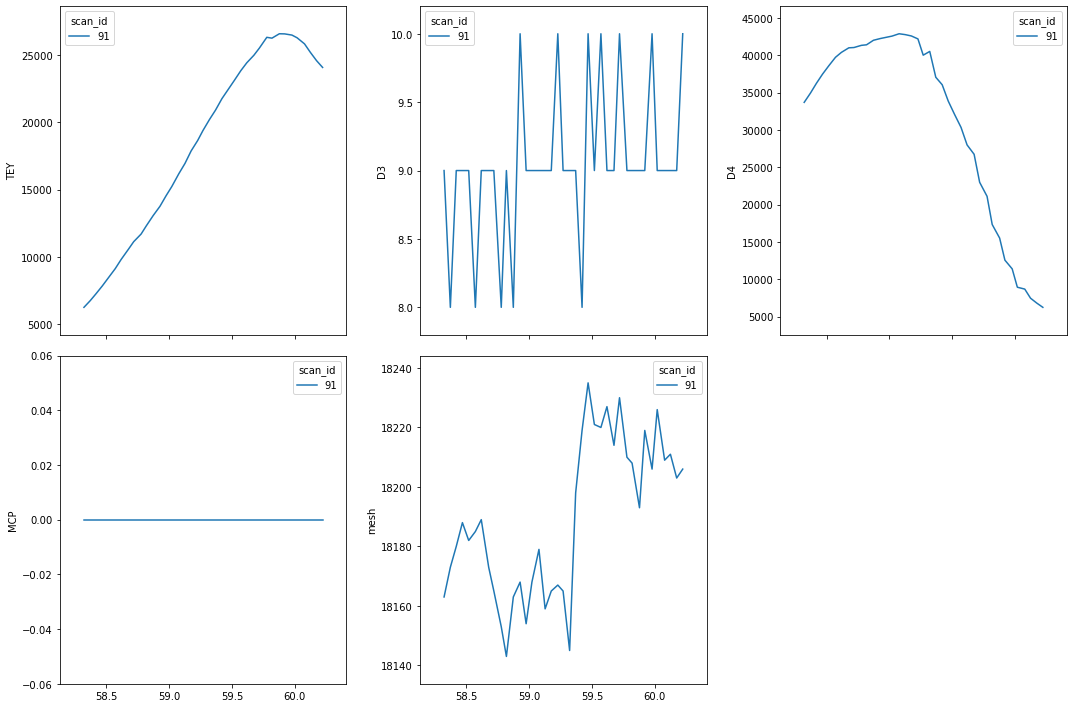

In [95]:
RE(th2th_plan(1,6,0.05,myomega))
#RE(th2th_plan(4,12,0.05,myomega))
#RE(th2th_plan(10,16,0.05,myomega))
#RE(th2th_plan(14,20,0.05,myomega))
#RE(th2th_plan(18,25,0.05,myomega))
#RE(th2th_plan(23,28,0.05,myomega))


In [96]:
RE.abort()

Aborting: running cleanup and marking exit_status as 'abort'...
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+
generator scan ['82b0c54f'] (scan num: 91)


/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 519.9922186                    |
|              mono_mirror_pitch | 3.6361871337890626             |
|             mono_grating_pitch | 4.9287341064453125             |
|                    centroidM3R | 112.13997142928748             |
|                kappa_motors_m2 | 402.517                        |
|                kappa_motors_m3 | 0.244                          |
|                kappa_motors_m4 | -219.991                       |
|                kappa_motors_m9 | 5.9                            |
|                kappa_motors_m8 | 60.27214238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04514976                    |
|                select_detector | d4                             |
+-----------------

Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1503, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky

('82b0c54f-e51c-437b-a925-714f2194a927',)



Transient Scan ID: 92     Time: 2021-12-03 15:48:52
Persistent Unique Scan ID: 'c6538892-10e9-4709-8462-d8140701977c'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.0104196                    |
|              mono_mirror_pitch | 3.6362469482421877             |
|             mono_grating_pitch | 4.928749365234375              |
|                    centroidM3R | 112.03399193749067             |
|                kappa_motors_m2 | 402.514                        |
|                kappa_motors_m3 | 0.245                          |
|                kappa_motors_m4 | -219.993                       |
|                kappa_motors_m9 | 5.9                            |
|                kappa_motors_m8 | 60.27214238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('c6538892-10e9-4709-8462-d8140701977c',)

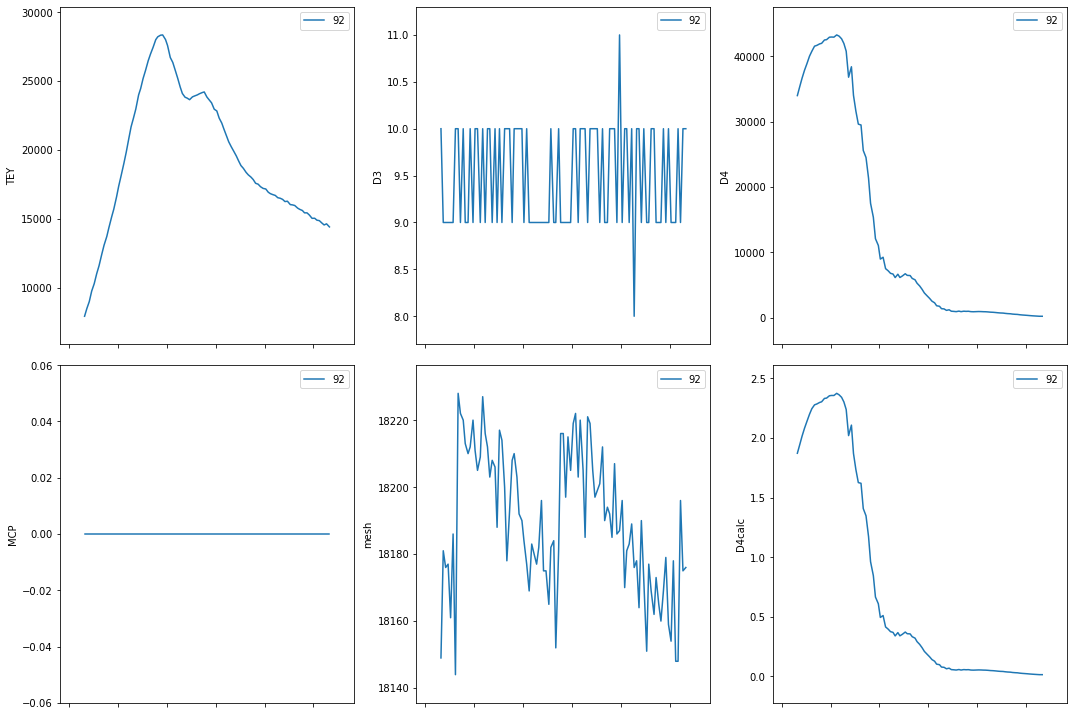

In [99]:
RE(th2th_plan(1,6,0.05,myomega))
#RE(th2th_plan(4,12,0.05,myomega))
#RE(th2th_plan(10,16,0.05,myomega))
#RE(th2th_plan(14,20,0.05,myomega))
#RE(th2th_plan(18,25,0.05,myomega))
#RE(th2th_plan(23,28,0.05,myomega))


In [101]:
d4_gain()

sensitivity: 200 nA/V
gain: 2.0000000000000002e-07


2.0000000000000002e-07

In [102]:
d4_gain()

sensitivity: 2 nA/V
gain: 2e-09


2e-09



Transient Scan ID: 93     Time: 2021-12-03 15:53:44
Persistent Unique Scan ID: '160caaa1-dcbc-4f56-869a-2daf8d9a9cda'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49730563163757324            |
|                    mono_energy | 520.0019616                    |
|              mono_mirror_pitch | 3.6361724853515627             |
|             mono_grating_pitch | 4.928734716796875              |
|                    centroidM3R | 112.1455584544664              |
|                kappa_motors_m2 | 402.517                        |
|                kappa_motors_m3 | 0.241                          |
|                kappa_motors_m4 | -219.993                       |
|                kappa_motors_m9 | 12.0                           |
|                kappa_motors_m8 | 63.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('160caaa1-dcbc-4f56-869a-2daf8d9a9cda',)

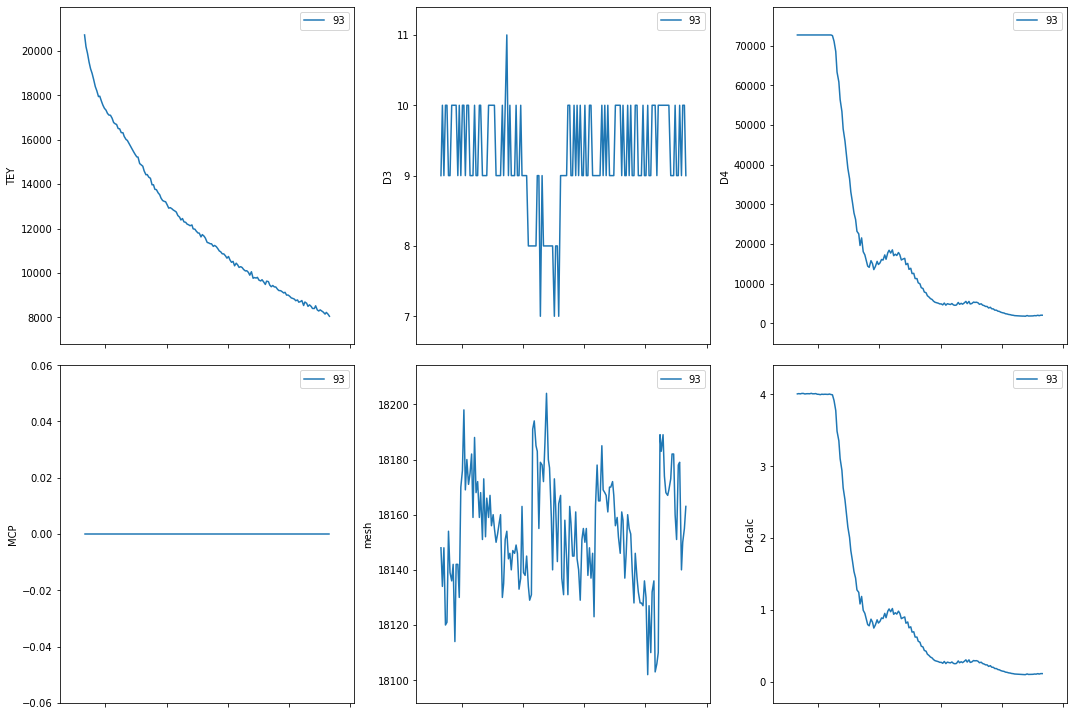

In [103]:
#RE(th2th_plan(1,6,0.05,myomega))
RE(th2th_plan(4,12,0.05,myomega))
#RE(th2th_plan(10,16,0.05,myomega))
#RE(th2th_plan(14,20,0.05,myomega))
#RE(th2th_plan(18,25,0.05,myomega))
#RE(th2th_plan(23,28,0.05,myomega))


In [104]:
d4_gain()

sensitivity: 500 pA/V
gain: 5e-10


5e-10



Transient Scan ID: 94     Time: 2021-12-03 16:00:52
Persistent Unique Scan ID: '90f14284-3ac3-44ee-8e71-aff2da199d9c'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49751967191696167            |
|                    mono_energy | 519.9927951                    |
|              mono_mirror_pitch | 3.6361926269531253             |
|             mono_grating_pitch | 4.928721899414063              |
|                    centroidM3R | 112.4352682475824              |
|                kappa_motors_m2 | 402.524                        |
|                kappa_motors_m3 | 0.23800000000000002            |
|                kappa_motors_m4 | -219.989                       |
|                kappa_motors_m9 | 24.0                           |
|                kappa_motors_m8 | 69.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('90f14284-3ac3-44ee-8e71-aff2da199d9c',)

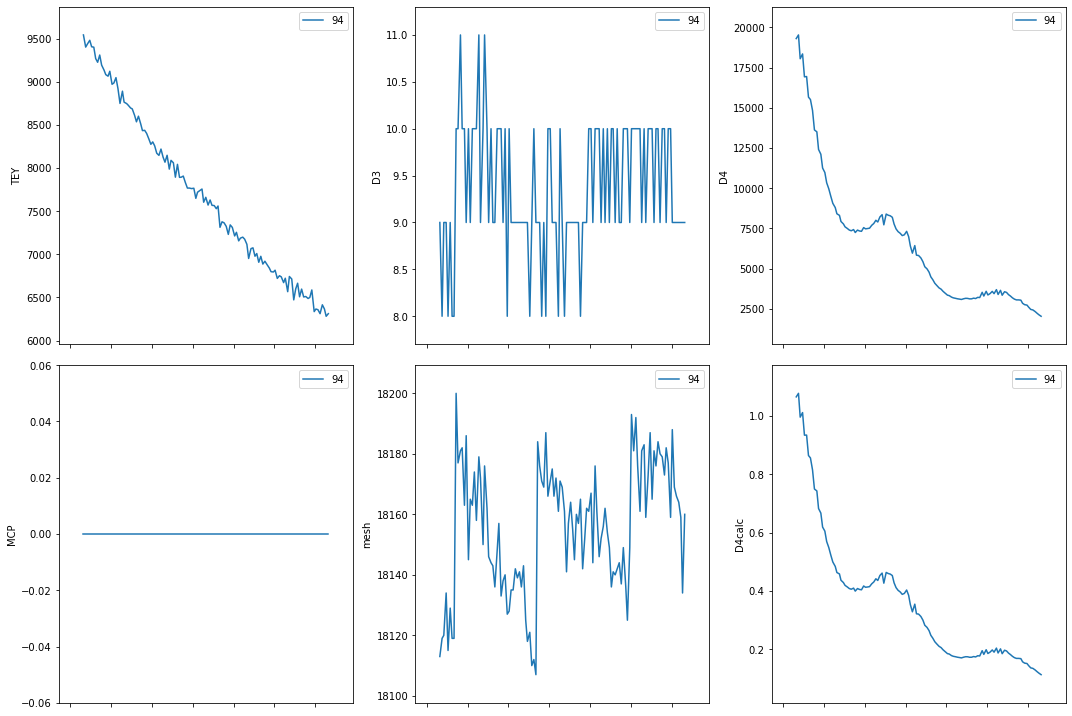

In [105]:
#RE(th2th_plan(1,6,0.05,myomega))
#RE(th2th_plan(4,12,0.05,myomega))
RE(th2th_plan(10,16,0.05,myomega))
#RE(th2th_plan(14,20,0.05,myomega))
#RE(th2th_plan(18,25,0.05,myomega))
#RE(th2th_plan(23,28,0.05,myomega))


In [106]:
d4_gain()

sensitivity: 100 pA/V
gain: 1e-10


1e-10



Transient Scan ID: 95     Time: 2021-12-03 16:10:09
Persistent Unique Scan ID: 'a80c3b81-3134-458a-8a93-242499c83099'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4972343444824219             |
|                    mono_energy | 520.0052252                    |
|              mono_mirror_pitch | 3.6362237548828125             |
|             mono_grating_pitch | 4.928759741210937              |
|                    centroidM3R | 112.64529192546584             |
|                kappa_motors_m2 | 402.524                        |
|                kappa_motors_m3 | 0.23600000000000002            |
|                kappa_motors_m4 | -219.991                       |
|                kappa_motors_m9 | 32.0                           |
|                kappa_motors_m8 | 73.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|        

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 519.9997188                    |
|              mono_mirror_pitch | 3.63619384765625               |
|             mono_grating_pitch | 4.928747534179688              |
|                    centroidM3R | 113.18732181371941             |
|                kappa_motors_m2 | 402.52500000000003             |
|                kappa_motors_m3 | 0.234                          |
|                kappa_motors_m4 | -219.99                        |
|                kappa_motors_m9 | 40.0                           |
|                kappa_motors_m8 | 77.32314238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04516631999999              |
|                select_detector | d4                             |
+-----------------

('a80c3b81-3134-458a-8a93-242499c83099',)

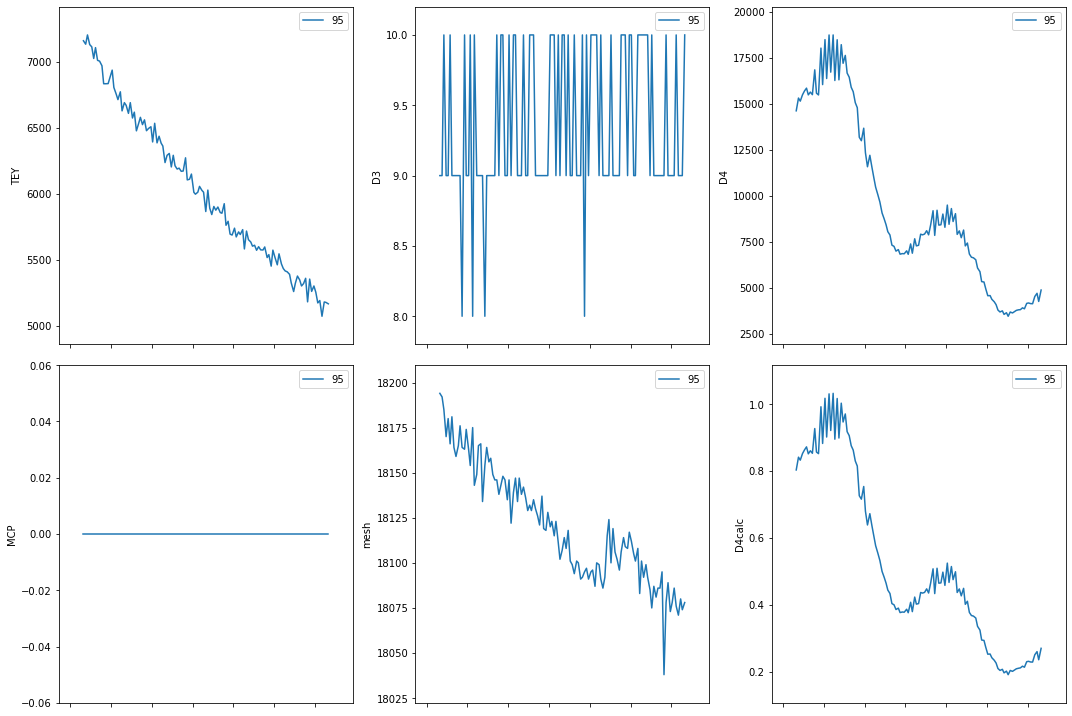

In [107]:
#RE(th2th_plan(1,6,0.05,myomega))
#RE(th2th_plan(4,12,0.05,myomega))
#RE(th2th_plan(10,16,0.05,myomega))
RE(th2th_plan(14,20,0.05,myomega))
#RE(th2th_plan(18,25,0.05,myomega))
#RE(th2th_plan(23,28,0.05,myomega))


In [111]:
x_motor.move(-400)

MoveStatus(done=True, pos=kappa_motors_m2, elapsed=1.2, success=True, settle_time=0.0)



Transient Scan ID: 96     Time: 2021-12-03 16:15:30
Persistent Unique Scan ID: 'a4bdf64a-b30c-4373-be3c-0e3d33b9f088'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4974483549594879             |
|                    mono_energy | 519.995371                     |
|              mono_mirror_pitch | 3.6361669921875                |
|             mono_grating_pitch | 4.9287298339843755             |
|                    centroidM3R | 113.32921421097214             |
|                kappa_motors_m2 | -399.918                       |
|                kappa_motors_m3 | 0.281                          |
|                kappa_motors_m4 | -219.933                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|        

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.0035273                    |
|              mono_mirror_pitch | 3.63619140625                  |
|             mono_grating_pitch | 4.928732275390625              |
|                    centroidM3R | 113.23760043646463             |
|                kappa_motors_m2 | -400.091                       |
|                kappa_motors_m3 | 0.245                          |
|                kappa_motors_m4 | -219.994                       |
|                kappa_motors_m9 | 12.0                           |
|                kappa_motors_m8 | 63.32314238179001              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04486896                    |
|                select_detector | d4                             |
+-----------------

('a4bdf64a-b30c-4373-be3c-0e3d33b9f088',)

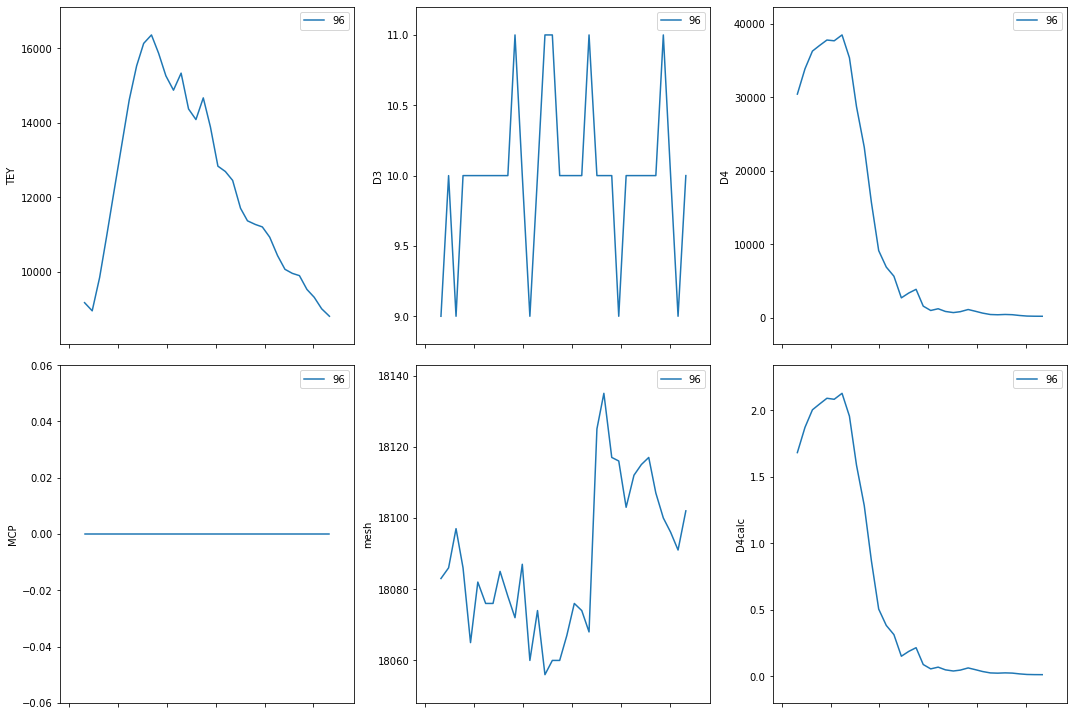

In [112]:
RE(th2th_plan(1,6,0.15,myomega))
#RE(th2th_plan(4,12,0.05,myomega))
#RE(th2th_plan(10,16,0.05,myomega))
#RE(th2th_plan(14,20,0.05,myomega))
#RE(th2th_plan(18,25,0.05,myomega))
#RE(th2th_plan(23,28,0.05,myomega))


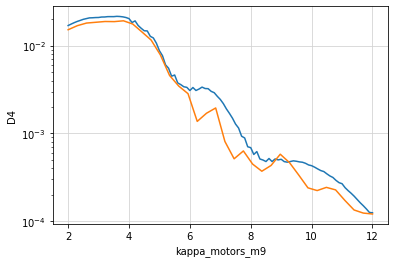

In [113]:
plot_run([[92,0,5e-7],[96,0,5e-7]],tth_motor,D4,log=True)

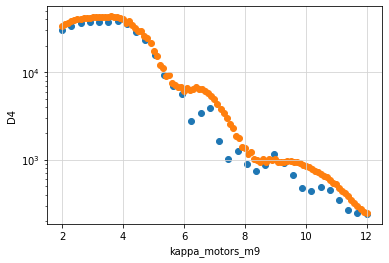

In [12]:
plot_scatter(-1,tth_motor,D4,True)
plot_scatter(92,tth_motor,D4,True)

In [118]:
mprint()

x,y,z,tth,th,chi,phi = [-400.0,0.0,-220.0,2.0,58.32,134.75600000000003,57.05]


[-400.0, 0.0, -220.0, 2.0, 58.32, 134.75600000000003, 57.05]

In [120]:
undulator.energy.get()

UndulatorEnergyTuple(setpoint=0.529501, readback=0.4971630573272705, done=True)

In [121]:
mono.energy.get()

MonoEnergyTuple(setpoint=520.0, readback=519.9921181, done='Ready')

In [ ]:
Q=3;x_motor.move(-1200);RE(v th2th_N_plan(Q,0.05,myomega))

In [17]:
54/2/12

2.25

In [11]:
for N in range(1,13):
    start=(N-1)*2.25+1
    stop=N*2.25+1+1.5
    print('==N:',N)
    print('start:',start*2)
    print('stop:',stop*2)
    print('\n')

==N: 1
start: 2.0
stop: 9.5


==N: 2
start: 6.5
stop: 14.0


==N: 3
start: 11.0
stop: 18.5


==N: 4
start: 15.5
stop: 23.0


==N: 5
start: 20.0
stop: 27.5


==N: 6
start: 24.5
stop: 32.0


==N: 7
start: 29.0
stop: 36.5


==N: 8
start: 33.5
stop: 41.0


==N: 9
start: 38.0
stop: 45.5


==N: 10
start: 42.5
stop: 50.0


==N: 11
start: 47.0
stop: 54.5


==N: 12
start: 51.5
stop: 59.0




[clueless ~] su rodolakis
Password: 
[clueless /home/beams/29IDUSER] cd
[clueless ~] become_bluesky 
Python 3.9.7 (default, Sep 16 2021, 13:09:58) 
Type 'copyright', 'credits' or 'license' for more information
IPython 7.29.0 -- An enhanced Interactive Python. Type '?' for help.

IPython profile: bluesky


/home/beams/RODOLAKIS/.ipython-bluesky/profile_bluesky/startup/00-PythonPath.py
/home/beams/RODOLAKIS/.ipython-bluesky/profile_bluesky/startup/90-StartDir.py

WARNING: You are running as FANNY



   ...: kap_motor=kappa_motors.m7
   ...: kth_motor=kappa_motors.m8
   ...: tth_motor=kappa_motors.m9
   ...: srs1=srs.A1
   ...: srs2=srs.A2
   ...: srs3=srs.A3
   ...: srs4=srs.A4
   ...: 
   ...: myomega=57.322396707958816
   ...: 
   ...: scaler.stage_sigs['preset_time']=0.1
   ...: 
   ...: sd.baseline.append(undulator)
   ...: sd.baseline.append(mono)
   ...: sd.baseline.append(centroid_m3r)
   ...: sd.baseline.append(x_motor)
   ...: sd.baseline.append(y_motor)
   ...: sd.baseline.append(z_motor)
   ...: sd.baseline.append(tth_motor)
   ...: sd.baseline.append(kth_motor)
   ...: sd.baseline.append(kap_motor)
   ...: sd.baseline.append(kphi_motor)
   ...: sd.baseline.append(select_detector)
   ...: sd.baseline.append(srs4)

I Fri-17:10:15 - ############################################################ startup
I Fri-17:10:15 - logging started
I Fri-17:10:15 - logging level = 10
['29idd', '29idd_retired_2021_12_01']
Number of scans in catalog: 96

In [2]: 
QStandardPaths: wrong ownership on runtime directory /run/user/2256, 2256 instead of 1791

   ...:     """
   ...:     table_array=np.array([])
   ...:     if type(StartStopStepLists) is not list:
   ...:         start=StartStopStepLists[0]
   ...:         stop=StartStopStepLists[1]
   ...:         step=StartStopStepLists[2]
   ...:         j=start
   ...:         while j<=stop:
   ...:             table_array=np.append(table_array, j)
   ...:             j+=step
   ...:     else:
   ...:         for i in range(0,len(StartStopStepLists)):
   ...:             start=StartStopStepLists[i][0]
   ...:             stop=StartStopStepLists[i][1]
   ...:             step=StartStopStepLists[i][2]
   ...:             j=start
   ...:             while j<=stop:
   ...:                 table_array=np.append(table_array, j)
   ...:                 j+=step
   ...:     table_array=np.unique(table_array)#removing duplicate
   ...:     table_array=np.sort(table_array) #sort into ascending order    
   ...: 
   ...:     return table_array.tolist()
   ...: 

In [3]: mprint()
x,y,z,tth,th,chi,phi = [-400.0,0.0,-220.0,2.0,58.32,134.75600000000003,57.05]
Out[3]: [-400.0, 0.0, -220.0, 2.0, 58.32, 134.75600000000003, 57.05]

In [4]: undulator.energy.get()
Out[4]: UndulatorEnergyTuple(setpoint=0.529501, readback=0.4974483549594879, done=True)

In [5]: undulator.mono.get()
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-5-87d359d61646> in <module>
----> 1 undulator.mono.get()

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/ophyd/device.py in __getattr__(self, name)
   1195         # Components will be instantiated through the descriptor mechanism in
   1196         # the Component class, so anything reaching this point is an error.
-> 1197         raise AttributeError(name)
   1198 
   1199     def _instantiate_component(self, attr):

AttributeError: mono

In [6]: mono.energy.get()
Out[6]: MonoEnergyTuple(setpoint=520.0, readback=519.9946093, done='Ready')

In [7]: undulator.energy.get()
Out[7]: UndulatorEnergyTuple(setpoint=0.529501, readback=0.4974483549594879, done=True)

In [8]: mprint()
x,y,z,tth,th,chi,phi = [-400.0,0.0,-220.0,2.0,58.32,134.75600000000003,57.05]
Out[8]: [-400.0, 0.0, -220.0, 2.0, 58.32, 134.75600000000003, 57.05]

In [9]: d4_gain()
sensitivity: 200 nA/V
gain: 2.0000000000000002e-07
Out[9]: 2.0000000000000002e-07

In [10]: g=d4_gain()
sensitivity: 200 nA/V
gain: 2.0000000000000002e-07

In [11]: g
Out[11]: 2.0000000000000002e-07

In [12]: 55/2/12
Out[12]: 2.2916666666666665

In [13]: 54/2/12
Out[13]: 2.25

In [14]: start=1;start+2.25+1.5
Out[14]: 4.75

In [15]: 4.75/0.05
Out[15]: 95.0

In [16]: start=1

In [17]: stop=start+2.25+1.5

In [18]: x_motor.move(-600);RE(th2th_plan(start,stop,0.05,myomega))


Transient Scan ID: 97     Time: 2021-12-03 17:20:27
Persistent Unique Scan ID: '3429fcbe-86d3-42cd-9190-c62b3dc4e568'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4972343444824219             |
|                    mono_energy | 520.0058705                    |
|              mono_mirror_pitch | 3.6362432861328124             |
|             mono_grating_pitch | 4.928758520507812              |
|                    centroidM3R | 110.21404105369508             |
|                kappa_motors_m2 | -599.962                       |
|                kappa_motors_m3 | 0.257                          |
|                kappa_motors_m4 | -220.04                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.32214238179                 |
|                kappa_motors_m7 | 134.757                        |
|                kappa_motors_m1 | 57.04501836                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 17:20:27.6 |         58.3221 |          2.0000 |      1.781 |       6474 |          9 |      32127 |          0 |      18041 |
|         2 | 17:20:28.8 |         58.3711 |          2.1000 |      1.834 |       6391 |          9 |      33087 |          0 |      18037 |
|         3 | 17:20:29.5 |         58.4191 |          2.2000 |      1.896 |       6431 |          9 |      34188 |          0 |      18036 |
|         4 | 17:20:30.2 |         58.4721 |          2.3000 |      1.957 |       6678 |          8 |      35298 |          0 |      18037 |
|         5 | 17:20:30.8 |         58.5181 |          2.4000 |      2.013 |       7105 |          9 |      36283 |          0 |      18028 |
|         6 | 17:20:31.5 |         58.5771 |          2.5000 |      2.071 |       7473 |          9 |      37356 |          0 |      18040 |
|         7 | 17:20:32.2 |         58.6251 |          2.6000 |      2.105 |       7796 |          9 |      37984 |          0 |      18046 |
|         8 | 17:20:32.8 |         58.6741 |          2.7000 |      2.125 |       8093 |          8 |      38335 |          0 |      18044 |
|         9 | 17:20:33.6 |         58.7181 |          2.8000 |      2.141 |       8328 |          8 |      38612 |          0 |      18033 |
|        10 | 17:20:34.6 |         58.7771 |          2.9000 |      2.152 |       8638 |          9 |      38822 |          0 |      18036 |
|        11 | 17:20:35.4 |         58.8201 |          3.0000 |      2.150 |       8787 |          9 |      38780 |          0 |      18040 |
|        12 | 17:20:36.0 |         58.8681 |          3.1000 |      2.153 |       9190 |          9 |      38819 |          0 |      18032 |
|        13 | 17:20:36.7 |         58.9191 |          3.2000 |      2.158 |       9544 |          9 |      38915 |          0 |      18035 |
|        14 | 17:20:37.4 |         58.9701 |          3.3000 |      2.162 |       9822 |          9 |      38984 |          0 |      18034 |
|        15 | 17:20:38.0 |         59.0251 |          3.4000 |      2.189 |      10279 |          9 |      39461 |          0 |      18029 |
|        16 | 17:20:38.8 |         59.0691 |          3.5000 |      2.146 |      10625 |          8 |      38722 |          0 |      18043 |
|        17 | 17:20:39.5 |         59.1191 |          3.6000 |      2.138 |      11035 |          9 |      38545 |          0 |      18025 |
|        18 | 17:20:40.1 |         59.1701 |          3.7000 |      2.145 |      11525 |          9 |      38693 |          0 |      18035 |
|        19 | 17:20:40.8 |         59.2241 |          3.8000 |      2.153 |      12062 |          9 |      38822 |          0 |      18035 |
|        20 | 17:20:41.4 |         59.2711 |          3.9000 |      2.103 |      12291 |          9 |      37887 |          0 |      18014 |
|        21 | 17:20:42.2 |         59.3271 |          4.0000 |      2.094 |      12719 |          9 |      37770 |          0 |      18040 |
|        22 | 17:20:42.9 |         59.3701 |          4.1000 |      1.970 |      12908 |          9 |      35528 |          0 |      18034 |
|        23 | 17:20:43.5 |         59.4271 |          4.2000 |      1.956 |      13155 |          9 |      35300 |          0 |      18046 |
|        24 | 17:20:44.2 |         59.4731 |          4.3000 |      1.824 |      13481 |          9 |      32861 |          0 |      18016 |
|        25 | 17:20:44.8 |         59.5181 |          4.4000 |      1.689 |      13658 |          8 |      30443 |          0 |      18025 |
|        26 | 17:20:45.5 |         59.5691 |          4.5000 |      1.654 |      13929 |          9 |      29818 |          0 |      18030 |
|        27 | 17:20:46.1 |         59.6261 |          4.6000 |      1.544 |      13906 |          9 |      27859 |          0 |      18043 |
|        28 | 17:20:46.8 |         59.6751 |          4.7000 |      1.356 |      13972 |          8 |      24445 |          0 |      18021 |
|        29 | 17:20:47.5 |         59.7251 |          4.8000 |      1.204 |      14076 |          9 |      21707 |          0 |      18035 |
|        30 | 17:20:48.1 |         59.7751 |          4.9000 |      1.071 |      13966 |          9 |      19313 |          0 |      18032 |
|        31 | 17:20:48.7 |         59.8221 |          5.0000 |      0.926 |      13907 |          9 |      16698 |          0 |      18026 |
|        32 | 17:20:49.4 |         59.8681 |          5.1000 |      0.808 |      13864 |          9 |      14562 |          0 |      18016 |
|        33 | 17:20:50.1 |         59.9201 |          5.2000 |      0.704 |      13800 |          8 |      12692 |          0 |      18024 |
|        34 | 17:20:50.8 |         59.9721 |          5.3000 |      0.607 |      13621 |          9 |      10946 |          0 |      18021 |
|        35 | 17:20:51.5 |         60.0181 |          5.4000 |      0.498 |      13371 |          9 |       8968 |          0 |      18020 |
|        36 | 17:20:52.1 |         60.0681 |          5.5000 |      0.427 |      13161 |          9 |       7700 |          0 |      18018 |
|        37 | 17:20:52.8 |         60.1181 |          5.6000 |      0.395 |      13035 |          9 |       7115 |          0 |      18028 |
|        38 | 17:20:53.5 |         60.1721 |          5.7000 |      0.388 |      13124 |          9 |       6994 |          0 |      18026 |
|        39 | 17:20:54.1 |         60.2271 |          5.8000 |      0.390 |      13326 |          9 |       7031 |          0 |      18018 |
|        40 | 17:20:54.8 |         60.2711 |          5.9000 |      0.357 |      13407 |          9 |       6433 |          0 |      18016 |
|        41 | 17:20:55.4 |         60.3201 |          6.0000 |      0.311 |      13471 |         10 |       5618 |          0 |      18037 |
|        42 | 17:20:56.3 |         60.3761 |          6.1000 |      0.259 |      13288 |          9 |       4671 |          0 |      18008 |
|        43 | 17:20:56.9 |         60.4181 |          6.2000 |      0.200 |      13045 |          9 |       3603 |          0 |      18016 |
|        44 | 17:20:57.6 |         60.4741 |          6.3000 |      0.170 |      12746 |          9 |       3065 |          0 |      18033 |
|        45 | 17:20:58.2 |         60.5181 |          6.4000 |      0.173 |      12370 |         10 |       3111 |          0 |      18008 |
|        46 | 17:20:58.9 |         60.5691 |          6.5000 |      0.197 |      12451 |          8 |       3552 |          0 |      18026 |
|        47 | 17:20:59.8 |         60.6261 |          6.6000 |      0.209 |      12767 |          9 |       3767 |          0 |      18024 |
|        48 | 17:21:00.5 |         60.6771 |          6.7000 |      0.226 |      13003 |          8 |       4081 |          0 |      18019 |
|        49 | 17:21:01.1 |         60.7221 |          6.8000 |      0.213 |      13023 |          9 |       3838 |          0 |      18011 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 17:21:01.8 |         60.7681 |          6.9000 |      0.192 |      13133 |          9 |       3450 |          0 |      18013 |
|        51 | 17:21:02.4 |         60.8191 |          7.0000 |      0.160 |      12985 |          8 |       2878 |          0 |      18012 |
|        52 | 17:21:03.0 |         60.8681 |          7.1000 |      0.126 |      12688 |          9 |       2268 |          0 |      18009 |
|        53 | 17:21:03.7 |         60.9181 |          7.2000 |      0.095 |      12395 |          9 |       1720 |          0 |      18015 |
|        54 | 17:21:04.4 |         60.9701 |          7.3000 |      0.074 |      11971 |          9 |       1332 |          0 |      18039 |
|        55 | 17:21:05.0 |         61.0221 |          7.4000 |      0.064 |      11792 |          8 |       1150 |          0 |      17995 |
|        56 | 17:21:05.7 |         61.0751 |          7.5000 |      0.065 |      11628 |          9 |       1168 |          0 |      18012 |
|        57 | 17:21:06.3 |         61.1211 |          7.6000 |      0.069 |      11596 |          9 |       1245 |          0 |      18030 |
|        58 | 17:21:07.0 |         61.1771 |          7.7000 |      0.079 |      11617 |          9 |       1419 |          0 |      18001 |
|        59 | 17:21:07.6 |         61.2221 |          7.8000 |      0.081 |      11671 |          8 |       1462 |          0 |      18007 |
|        60 | 17:21:08.3 |         61.2711 |          7.9000 |      0.081 |      11651 |          9 |       1466 |          0 |      17998 |
|        61 | 17:21:08.9 |         61.3261 |          8.0000 |      0.079 |      11518 |          9 |       1420 |          0 |      18009 |
|        62 | 17:21:09.6 |         61.3721 |          8.1000 |      0.069 |      11593 |          9 |       1245 |          0 |      18008 |
|        63 | 17:21:10.2 |         61.4241 |          8.2000 |      0.059 |      11423 |          9 |       1069 |          0 |      18008 |
|        64 | 17:21:10.8 |         61.4711 |          8.3000 |      0.049 |      11242 |          9 |        885 |          0 |      18010 |
|        65 | 17:21:11.5 |         61.5281 |          8.4000 |      0.042 |      10928 |          8 |        749 |          0 |      18010 |
|        66 | 17:21:12.2 |         61.5691 |          8.5000 |      0.037 |      10703 |          9 |        670 |          0 |      18011 |
|        67 | 17:21:13.5 |         61.6271 |          8.6000 |      0.037 |      10719 |          9 |        673 |          0 |      18003 |
|        68 | 17:21:14.6 |         61.6681 |          8.7000 |      0.039 |      10620 |          8 |        704 |          0 |      18005 |
|        69 | 17:21:15.7 |         61.7271 |          8.8000 |      0.044 |      10500 |          9 |        788 |          0 |      18009 |
|        70 | 17:21:16.4 |         61.7691 |          8.9000 |      0.050 |      10385 |          8 |        893 |          0 |      18010 |
|        71 | 17:21:17.3 |         61.8181 |          9.0000 |      0.055 |      10520 |          9 |        991 |          0 |      18012 |
|        72 | 17:21:18.0 |         61.8691 |          9.1000 |      0.060 |      10449 |          8 |       1078 |          0 |      18007 |
|        73 | 17:21:18.6 |         61.9191 |          9.2000 |      0.062 |      10371 |          9 |       1126 |          0 |      18031 |
|        74 | 17:21:19.2 |         61.9681 |          9.3000 |      0.063 |      10403 |          9 |       1133 |          0 |      18007 |
|        75 | 17:21:19.9 |         62.0191 |          9.4000 |      0.061 |      10391 |          9 |       1100 |          0 |      18012 |
|        76 | 17:21:20.5 |         62.0731 |          9.5000 |      0.058 |      10314 |          8 |       1046 |          0 |      18009 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['3429fcbe'] (scan num: 97)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.0023213                    |
|              mono_mirror_pitch | 3.6362322998046874             |
|             mono_grating_pitch | 4.92871640625                  |
|                    centroidM3R | 110.21241781964478             |
|                kappa_motors_m2 | -600.109                       |
|                kappa_motors_m3 | 0.252                          |
|                kappa_motors_m4 | -219.993                       |
|                kappa_motors_m9 | 9.5                            |
|                kappa_motors_m8 | 62.07314238179001              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.045121679999994             |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



Out[18]: ('3429fcbe-86d3-42cd-9190-c62b3dc4e568',)

In [19]: d4_gain()
sensitivity: 10 nA/V
gain: 1e-08
Out[19]: 1e-08

In [20]: print(start,stop)
1 4.75

In [21]: start=4.75-1.25

In [22]: plot_latest(tth_motor,D4)
/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png

In [23]: plot_latest(tth_motor,D4)
/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png

In [24]: plot_latest(tth_motor,D4,log=1)
/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


In [25]: 

In [25]: def th2th_N_plan(N,step,offset):
    ...:     """
    ...:     N = section number
    ...:     start(N=0) = 1
    ...:     overlap=1.5
    ...:     range size = 2.25 = (55-1)/12
    ...:     """
    ...:     start=(N-1)*2.25+1
    ...:     stop=N*2.25+1+1.5
    ...:     npts=int((stop-start)/step+1)
    ...:     yield from bp.scan([scaler,D4calc],kth_motor,start+offset,stop+offset,tth_motor,start*2,stop*2,npts)
    ...: 

In [26]: 

In [26]: d4_gain()
sensitivity: 10 nA/V
gain: 1e-08
Out[26]: 1e-08

In [27]: g=d4_gain()
sensitivity: 10 nA/V
gain: 1e-08

In [28]: x_motor.move(-800);RE(th2th_N_plan(2,0.05,myomega))


Transient Scan ID: 98     Time: 2021-12-03 17:37:04
Persistent Unique Scan ID: '073a491d-9775-4dc2-b41e-546a6f079da5'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4972343444824219             |
|                    mono_energy | 520.0057436                    |
|              mono_mirror_pitch | 3.636187744140625              |
|             mono_grating_pitch | 4.928737158203125              |
|                    centroidM3R | 110.43127845453427             |
|                kappa_motors_m2 | -799.924                       |
|                kappa_motors_m3 | 0.234                          |
|                kappa_motors_m4 | -219.97                        |
|                kappa_motors_m9 | 9.5                            |
|                kappa_motors_m8 | 62.07214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.0453708                     |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 17:37:07.4 |         60.5721 |          6.5000 |      3.564 |      15741 |         10 |      64181 |          0 |      18006 |
|         2 | 17:37:08.0 |         60.6201 |          6.6000 |      3.583 |      15576 |         10 |      64584 |          0 |      18026 |
|         3 | 17:37:08.8 |         60.6771 |          6.7000 |      3.482 |      15519 |          9 |      62709 |          0 |      18008 |
|         4 | 17:37:09.4 |         60.7241 |          6.8000 |      3.583 |      15426 |         10 |      64567 |          0 |      18020 |
|         5 | 17:37:10.1 |         60.7691 |          6.9000 |      3.369 |      15222 |          9 |      60729 |          0 |      18027 |
|         6 | 17:37:10.8 |         60.8181 |          7.0000 |      2.663 |      14750 |          9 |      47947 |          0 |      18002 |
|         7 | 17:37:11.5 |         60.8691 |          7.1000 |      2.066 |      14298 |         10 |      37246 |          0 |      18025 |
|         8 | 17:37:12.2 |         60.9191 |          7.2000 |      1.628 |      13824 |         11 |      29307 |          0 |      18006 |
|         9 | 17:37:12.8 |         60.9701 |          7.3000 |      1.412 |      13545 |         10 |      25447 |          0 |      18018 |
|        10 | 17:37:13.5 |         61.0191 |          7.4000 |      1.398 |      13222 |         10 |      25188 |          0 |      18021 |
|        11 | 17:37:14.2 |         61.0751 |          7.5000 |      1.544 |      13112 |         10 |      27801 |          0 |      18010 |
|        12 | 17:37:14.9 |         61.1191 |          7.6000 |      1.633 |      13051 |          9 |      29414 |          0 |      18016 |
|        13 | 17:37:15.8 |         61.1761 |          7.7000 |      1.786 |      13022 |         10 |      32193 |          0 |      18023 |
|        14 | 17:37:16.5 |         61.2181 |          7.8000 |      1.683 |      12989 |          9 |      30317 |          0 |      18009 |
|        15 | 17:37:17.1 |         61.2721 |          7.9000 |      1.569 |      12862 |          9 |      28259 |          0 |      18014 |
|        16 | 17:37:17.8 |         61.3271 |          8.0000 |      1.369 |      12789 |          9 |      24659 |          0 |      18016 |
|        17 | 17:37:18.5 |         61.3741 |          8.1000 |      1.101 |      12534 |          9 |      19818 |          0 |      18003 |
|        18 | 17:37:19.1 |         61.4261 |          8.2000 |      0.870 |      12156 |          9 |      15663 |          0 |      18006 |
|        19 | 17:37:19.8 |         61.4701 |          8.3000 |      0.709 |      11884 |         10 |      12762 |          0 |      17998 |
|        20 | 17:37:20.4 |         61.5211 |          8.4000 |      0.649 |      11714 |          9 |      11679 |          0 |      18007 |
|        21 | 17:37:21.4 |         61.5711 |          8.5000 |      0.695 |      11555 |         10 |      12522 |          0 |      18011 |
|        22 | 17:37:22.4 |         61.6271 |          8.6000 |      0.832 |      11376 |          9 |      14959 |          0 |      17990 |
|        23 | 17:37:23.6 |         61.6701 |          8.7000 |      0.968 |      11343 |         10 |      17428 |          0 |      17998 |
|        24 | 17:37:24.7 |         61.7271 |          8.8000 |      1.185 |      11262 |          9 |      21330 |          0 |      18001 |
|        25 | 17:37:25.3 |         61.7691 |          8.9000 |      1.320 |      11169 |         10 |      23739 |          0 |      17984 |
|        26 | 17:37:26.0 |         61.8201 |          9.0000 |      1.465 |      11294 |         10 |      26349 |          0 |      17982 |
|        27 | 17:37:26.7 |         61.8691 |          9.1000 |      1.504 |      11356 |          9 |      27073 |          0 |      18000 |
|        28 | 17:37:27.5 |         61.9181 |          9.2000 |      1.502 |      11267 |         10 |      27013 |          0 |      17982 |
|        29 | 17:37:28.5 |         61.9691 |          9.3000 |      1.419 |      11238 |          9 |      25557 |          0 |      18008 |
|        30 | 17:37:29.3 |         62.0191 |          9.4000 |      1.332 |      11081 |         10 |      23965 |          0 |      17993 |
|        31 | 17:37:30.0 |         62.0691 |          9.5000 |      1.178 |      10981 |         10 |      21182 |          0 |      17986 |
|        32 | 17:37:30.7 |         62.1241 |          9.6000 |      1.016 |      10994 |         10 |      18267 |          0 |      17981 |
|        33 | 17:37:31.4 |         62.1761 |          9.7000 |      0.853 |      10737 |          9 |      15346 |          0 |      17991 |
|        34 | 17:37:32.1 |         62.2201 |          9.8000 |      0.692 |      10715 |          8 |      12448 |          0 |      17989 |
|        35 | 17:37:32.7 |         62.2761 |          9.9000 |      0.588 |      10525 |          9 |      10590 |          0 |      18001 |
|        36 | 17:37:33.4 |         62.3211 |         10.0000 |      0.513 |      10378 |         10 |       9223 |          0 |      17991 |
|        37 | 17:37:34.0 |         62.3771 |         10.1000 |      0.474 |      10203 |          9 |       8533 |          0 |      17986 |
|        38 | 17:37:34.6 |         62.4271 |         10.2000 |      0.469 |      10180 |          9 |       8435 |          0 |      17976 |
|        39 | 17:37:35.3 |         62.4751 |         10.3000 |      0.487 |      10140 |         11 |       8755 |          0 |      17980 |
|        40 | 17:37:35.9 |         62.5251 |         10.4000 |      0.520 |      10004 |         10 |       9349 |          0 |      17984 |
|        41 | 17:37:36.7 |         62.5771 |         10.5000 |      0.555 |       9886 |          9 |       9982 |          0 |      17981 |
|        42 | 17:37:37.3 |         62.6221 |         10.6000 |      0.585 |       9801 |         10 |      10516 |          0 |      17973 |
|        43 | 17:37:38.0 |         62.6701 |         10.7000 |      0.605 |       9718 |         10 |      10875 |          0 |      17989 |
|        44 | 17:37:38.6 |         62.7191 |         10.8000 |      0.608 |       9765 |          9 |      10930 |          0 |      17967 |
|        45 | 17:37:39.6 |         62.7681 |         10.9000 |      0.591 |       9634 |         10 |      10623 |          0 |      17978 |
|        46 | 17:37:40.2 |         62.8181 |         11.0000 |      0.573 |       9587 |         10 |      10302 |          0 |      17977 |
|        47 | 17:37:40.9 |         62.8681 |         11.1000 |      0.543 |       9654 |          9 |       9751 |          0 |      17974 |
|        48 | 17:37:41.6 |         62.9191 |         11.2000 |      0.507 |       9580 |         10 |       9118 |          0 |      17975 |
|        49 | 17:37:42.3 |         62.9711 |         11.3000 |      0.464 |       9399 |          9 |       8339 |          0 |      17986 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 17:37:43.1 |         63.0191 |         11.4000 |      0.409 |       9351 |         10 |       7360 |          0 |      17986 |
|        51 | 17:37:43.8 |         63.0681 |         11.5000 |      0.365 |       9316 |         10 |       6566 |          0 |      17979 |
|        52 | 17:37:44.4 |         63.1241 |         11.6000 |      0.344 |       9123 |         10 |       6181 |          0 |      17974 |
|        53 | 17:37:45.0 |         63.1741 |         11.7000 |      0.312 |       9149 |          9 |       5612 |          0 |      17983 |
|        54 | 17:37:45.7 |         63.2271 |         11.8000 |      0.286 |       9062 |          9 |       5143 |          0 |      17980 |
|        55 | 17:37:46.3 |         63.2771 |         11.9000 |      0.269 |       8839 |          9 |       4835 |          0 |      17986 |
|        56 | 17:37:47.2 |         63.3271 |         12.0000 |      0.258 |       8796 |         10 |       4629 |          0 |      17972 |
|        57 | 17:37:47.8 |         63.3691 |         12.1000 |      0.254 |       8773 |         10 |       4570 |          0 |      17978 |
|        58 | 17:37:48.5 |         63.4241 |         12.2000 |      0.250 |       8690 |          9 |       4490 |          0 |      17970 |
|        59 | 17:37:49.2 |         63.4771 |         12.3000 |      0.247 |       8620 |         10 |       4442 |          0 |      17975 |
|        60 | 17:37:49.9 |         63.5261 |         12.4000 |      0.247 |       8683 |         10 |       4448 |          0 |      17988 |
|        61 | 17:37:50.5 |         63.5731 |         12.5000 |      0.247 |       8615 |          9 |       4438 |          0 |      17982 |
|        62 | 17:37:51.2 |         63.6271 |         12.6000 |      0.245 |       8456 |         10 |       4403 |          0 |      17963 |
|        63 | 17:37:51.8 |         63.6701 |         12.7000 |      0.238 |       8412 |         11 |       4279 |          0 |      17975 |
|        64 | 17:37:52.5 |         63.7181 |         12.8000 |      0.229 |       8420 |          9 |       4122 |          0 |      17976 |
|        65 | 17:37:53.1 |         63.7711 |         12.9000 |      0.226 |       8352 |         10 |       4067 |          0 |      17972 |
|        66 | 17:37:53.7 |         63.8231 |         13.0000 |      0.223 |       8248 |         10 |       4014 |          0 |      17985 |
|        67 | 17:37:54.4 |         63.8701 |         13.1000 |      0.214 |       8210 |         10 |       3842 |          0 |      17982 |
|        68 | 17:37:55.0 |         63.9231 |         13.2000 |      0.208 |       8096 |          9 |       3740 |          0 |      17971 |
|        69 | 17:37:55.7 |         63.9751 |         13.3000 |      0.204 |       8063 |         10 |       3662 |          0 |      17979 |
|        70 | 17:37:56.3 |         64.0181 |         13.4000 |      0.191 |       7996 |         11 |       3439 |          0 |      17973 |
|        71 | 17:37:57.0 |         64.0691 |         13.5000 |      0.185 |       8018 |         10 |       3325 |          0 |      17950 |
|        72 | 17:37:57.6 |         64.1201 |         13.6000 |      0.178 |       7968 |         10 |       3208 |          0 |      17981 |
|        73 | 17:37:58.3 |         64.1691 |         13.7000 |      0.171 |       7792 |         10 |       3083 |          0 |      17978 |
|        74 | 17:37:58.9 |         64.2251 |         13.8000 |      0.167 |       7865 |         10 |       3003 |          0 |      17962 |
|        75 | 17:37:59.6 |         64.2721 |         13.9000 |      0.159 |       7750 |          9 |       2865 |          0 |      17969 |
|        76 | 17:38:00.2 |         64.3231 |         14.0000 |      0.154 |       7696 |         10 |       2771 |          0 |      17953 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['073a491d'] (scan num: 98)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4972343444824219             |
|                    mono_energy | 519.9956777                    |
|              mono_mirror_pitch | 3.636219482421875              |
|             mono_grating_pitch | 4.928740209960938              |
|                    centroidM3R | 110.42386068914412             |
|                kappa_motors_m2 | -800.113                       |
|                kappa_motors_m3 | 0.249                          |
|                kappa_motors_m4 | -219.996                       |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.32314238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04512276                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



Out[28]: ('073a491d-9775-4dc2-b41e-546a6f079da5',)

In [29]: g=d4_gain()
sensitivity: 1 nA/V
gain: 1e-09

In [30]: from bluesky.callbacks import LivePlot

In [31]: x_motor.move(-800);RE(th2th_N_plan(2,0.05,myomega),LivePlot(D4.name,x_motor.name))


Transient Scan ID: 99     Time: 2021-12-03 17:44:07
Persistent Unique Scan ID: '014aabf4-0d4d-4318-a29f-2ba1ae46be50'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.0050929                    |
|              mono_mirror_pitch | 3.636260986328125              |
|             mono_grating_pitch | 4.928740209960938              |
|                    centroidM3R | 110.62763666617727             |
|                kappa_motors_m2 | -800.003                       |
|                kappa_motors_m3 | 0.247                          |
|                kappa_motors_m4 | -219.994                       |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04512024                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 17:44:13.5 |         60.5721 |          6.5000 |      3.584 |      16591 |         10 |      64543 |          0 |      18008 |
|         2 | 17:44:14.1 |         60.6191 |          6.6000 |      3.584 |      16288 |         10 |      64597 |          0 |      18023 |
|         3 | 17:44:14.8 |         60.6701 |          6.7000 |      3.589 |      15927 |         10 |      64659 |          0 |      18016 |
|         4 | 17:44:15.4 |         60.7261 |          6.8000 |      3.588 |      15733 |         10 |      64673 |          0 |      18026 |
|         5 | 17:44:16.1 |         60.7701 |          6.9000 |      3.588 |      15591 |         10 |      64697 |          0 |      18032 |
|         6 | 17:44:16.8 |         60.8201 |          7.0000 |      3.595 |      15431 |         10 |      64719 |          0 |      18001 |
|         7 | 17:44:17.5 |         60.8681 |          7.1000 |      3.591 |      15305 |         10 |      64725 |          0 |      18022 |
|         8 | 17:44:18.1 |         60.9191 |          7.2000 |      3.593 |      15101 |         11 |      64730 |          0 |      18015 |
|         9 | 17:44:18.9 |         60.9691 |          7.3000 |      3.597 |      14978 |         10 |      64733 |          0 |      17997 |
|        10 | 17:44:19.6 |         61.0181 |          7.4000 |      3.591 |      14725 |         10 |      64736 |          0 |      18027 |
|        11 | 17:44:20.2 |         61.0711 |          7.5000 |      3.593 |      14527 |         10 |      64738 |          0 |      18019 |
|        12 | 17:44:20.9 |         61.1211 |          7.6000 |      3.590 |      14487 |         10 |      64740 |          0 |      18034 |
|        13 | 17:44:21.6 |         61.1771 |          7.7000 |      3.594 |      14161 |         10 |      64742 |          0 |      18013 |
|        14 | 17:44:22.3 |         61.2231 |          7.8000 |      3.593 |      14047 |         10 |      64742 |          0 |      18020 |
|        15 | 17:44:22.9 |         61.2701 |          7.9000 |      3.596 |      13852 |         10 |      64744 |          0 |      18004 |
|        16 | 17:44:23.6 |         61.3261 |          8.0000 |      3.597 |      13750 |         10 |      64745 |          0 |      18002 |
|        17 | 17:44:24.3 |         61.3731 |          8.1000 |      3.594 |      13472 |         10 |      64746 |          0 |      18013 |
|        18 | 17:44:25.0 |         61.4231 |          8.2000 |      3.592 |      13285 |         10 |      64748 |          0 |      18026 |
|        19 | 17:44:25.6 |         61.4721 |          8.3000 |      3.595 |      13147 |         11 |      64749 |          0 |      18012 |
|        20 | 17:44:26.2 |         61.5271 |          8.4000 |      3.598 |      12884 |         10 |      64749 |          0 |      17994 |
|        21 | 17:44:27.0 |         61.5771 |          8.5000 |      3.595 |      12799 |          9 |      64750 |          0 |      18012 |
|        22 | 17:44:27.8 |         61.6191 |          8.6000 |      3.595 |      12567 |         11 |      64751 |          0 |      18010 |
|        23 | 17:44:28.9 |         61.6761 |          8.7000 |      3.595 |      12591 |         10 |      64752 |          0 |      18011 |
|        24 | 17:44:29.6 |         61.7191 |          8.8000 |      3.595 |      12376 |         10 |      64752 |          0 |      18011 |
|        25 | 17:44:30.5 |         61.7691 |          8.9000 |      3.593 |      12282 |         10 |      64753 |          0 |      18021 |
|        26 | 17:44:31.2 |         61.8181 |          9.0000 |      3.596 |      12144 |         10 |      64754 |          0 |      18007 |
|        27 | 17:44:31.9 |         61.8691 |          9.1000 |      3.596 |      12105 |         11 |      64754 |          0 |      18006 |
|        28 | 17:44:32.6 |         61.9181 |          9.2000 |      3.593 |      12002 |          9 |      64754 |          0 |      18024 |
|        29 | 17:44:33.3 |         61.9681 |          9.3000 |      3.593 |      11831 |         10 |      64755 |          0 |      18021 |
|        30 | 17:44:33.9 |         62.0181 |          9.4000 |      3.598 |      11721 |         11 |      64755 |          0 |      17999 |
|        31 | 17:44:34.6 |         62.0731 |          9.5000 |      3.591 |      11525 |         10 |      64754 |          0 |      18032 |
|        32 | 17:44:35.3 |         62.1261 |          9.6000 |      3.598 |      11563 |         10 |      64756 |          0 |      17997 |
|        33 | 17:44:36.2 |         62.1761 |          9.7000 |      3.596 |      11415 |         10 |      64756 |          0 |      18006 |
|        34 | 17:44:36.8 |         62.2251 |          9.8000 |      3.596 |      11345 |         10 |      64756 |          0 |      18008 |
|        35 | 17:44:37.7 |         62.2681 |          9.9000 |      3.597 |      11275 |         10 |      64758 |          0 |      18001 |
|        36 | 17:44:38.4 |         62.3181 |         10.0000 |      3.597 |      11083 |         10 |      64757 |          0 |      18005 |
|        37 | 17:44:39.0 |         62.3711 |         10.1000 |      3.596 |      11015 |         10 |      64756 |          0 |      18008 |
|        38 | 17:44:39.6 |         62.4221 |         10.2000 |      3.597 |      11055 |         11 |      64758 |          0 |      18003 |
|        39 | 17:44:40.3 |         62.4761 |         10.3000 |      3.597 |      10855 |         11 |      64758 |          0 |      18002 |
|        40 | 17:44:40.9 |         62.5191 |         10.4000 |      3.599 |      10713 |         10 |      64757 |          0 |      17991 |
|        41 | 17:44:41.7 |         62.5771 |         10.5000 |      3.592 |      10587 |         11 |      64759 |          0 |      18030 |
|        42 | 17:44:42.3 |         62.6221 |         10.6000 |      3.598 |      10543 |         10 |      64758 |          0 |      17999 |
|        43 | 17:44:43.0 |         62.6681 |         10.7000 |      3.597 |      10482 |         10 |      64758 |          0 |      18004 |
|        44 | 17:44:43.6 |         62.7191 |         10.8000 |      3.594 |      10407 |         10 |      64759 |          0 |      18019 |
|        45 | 17:44:44.5 |         62.7681 |         10.9000 |      3.594 |      10328 |          9 |      64751 |          0 |      18014 |
|        46 | 17:44:45.1 |         62.8181 |         11.0000 |      3.592 |      10287 |         10 |      64747 |          0 |      18027 |
|        47 | 17:44:45.9 |         62.8691 |         11.1000 |      3.583 |      10098 |         11 |      64469 |          0 |      17992 |
|        48 | 17:44:46.5 |         62.9241 |         11.2000 |      3.559 |      10065 |         10 |      64082 |          0 |      18004 |
|        49 | 17:44:47.2 |         62.9721 |         11.3000 |      3.517 |      10053 |         11 |      63220 |          0 |      17976 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 17:44:48.0 |         63.0181 |         11.4000 |      3.341 |       9853 |         10 |      60080 |          0 |      17981 |
|        51 | 17:44:48.6 |         63.0691 |         11.5000 |      3.241 |       9859 |          9 |      58311 |          0 |      17993 |
|        52 | 17:44:49.3 |         63.1251 |         11.6000 |      3.243 |       9664 |         10 |      58346 |          0 |      17992 |
|        53 | 17:44:50.0 |         63.1771 |         11.7000 |      3.102 |       9588 |         10 |      55815 |          0 |      17992 |
|        54 | 17:44:50.9 |         63.2271 |         11.8000 |      2.965 |       9595 |         10 |      53309 |          0 |      17982 |
|        55 | 17:44:51.5 |         63.2751 |         11.9000 |      2.842 |       9480 |         10 |      51194 |          0 |      18011 |
|        56 | 17:44:52.3 |         63.3271 |         12.0000 |      2.724 |       9249 |         10 |      49004 |          0 |      17989 |
|        57 | 17:44:53.0 |         63.3721 |         12.1000 |      2.649 |       9380 |          9 |      47613 |          0 |      17975 |
|        58 | 17:44:53.6 |         63.4181 |         12.2000 |      2.566 |       9163 |         10 |      46175 |          0 |      17996 |
|        59 | 17:44:54.4 |         63.4761 |         12.3000 |      2.511 |       9201 |         10 |      45185 |          0 |      17996 |
|        60 | 17:44:55.1 |         63.5191 |         12.4000 |      2.470 |       9218 |         10 |      44472 |          0 |      18003 |
|        61 | 17:44:55.7 |         63.5681 |         12.5000 |      2.433 |       8981 |         11 |      43826 |          0 |      18016 |
|        62 | 17:44:56.4 |         63.6201 |         12.6000 |      2.399 |       9062 |         10 |      43120 |          0 |      17976 |
|        63 | 17:44:57.0 |         63.6681 |         12.7000 |      2.359 |       8886 |          9 |      42439 |          0 |      17989 |
|        64 | 17:44:57.7 |         63.7251 |         12.8000 |      2.328 |       8886 |         10 |      41885 |          0 |      17989 |
|        65 | 17:44:58.4 |         63.7761 |         12.9000 |      2.298 |       8737 |         10 |      41359 |          0 |      17994 |
|        66 | 17:44:59.0 |         63.8241 |         13.0000 |      2.244 |       8752 |         10 |      40378 |          0 |      17990 |
|        67 | 17:44:59.7 |         63.8761 |         13.1000 |      2.194 |       8702 |         10 |      39496 |          0 |      18000 |
|        68 | 17:45:00.3 |         63.9241 |         13.2000 |      2.120 |       8660 |         10 |      38158 |          0 |      17998 |
|        69 | 17:45:01.0 |         63.9681 |         13.3000 |      1.991 |       8514 |         10 |      35770 |          0 |      17968 |
|        70 | 17:45:01.9 |         64.0191 |         13.4000 |      1.930 |       8583 |         10 |      34728 |          0 |      17990 |
|        71 | 17:45:02.6 |         64.0691 |         13.5000 |      1.868 |       8442 |          9 |      33599 |          0 |      17987 |
|        72 | 17:45:03.2 |         64.1201 |         13.6000 |      1.807 |       8397 |         10 |      32482 |          0 |      17975 |
|        73 | 17:45:03.9 |         64.1691 |         13.7000 |      1.749 |       8339 |         10 |      31469 |          0 |      17991 |
|        74 | 17:45:04.5 |         64.2211 |         13.8000 |      1.714 |       8101 |         10 |      30473 |          0 |      17777 |
|        75 | 17:45:05.4 |         64.2771 |         13.9000 |      1.693 |       8249 |         11 |      30508 |          0 |      18017 |
|        76 | 17:45:06.1 |         64.3231 |         14.0000 |      1.607 |       8178 |         10 |      28959 |          0 |      18020 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['014aabf4'] (scan num: 99)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49730563163757324            |
|                    mono_energy | 519.997894                     |
|              mono_mirror_pitch | 3.6362835693359377             |
|             mono_grating_pitch | 4.928756689453125              |
|                    centroidM3R | 110.50737288553533             |
|                kappa_motors_m2 | -800.003                       |
|                kappa_motors_m3 | 0.247                          |
|                kappa_motors_m4 | -219.995                       |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.32314238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04512276                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



LivePlot did not get any data that corresponds to the x axis. kappa_motors_m2
LivePlot did not get any data that corresponds to the y axis. D4
Out[31]: ('014aabf4-0d4d-4318-a29f-2ba1ae46be50',)

In [32]: g=d4_gain()
sensitivity: 2 nA/V
gain: 2e-09

In [33]: x_motor.move(-1000);RE(th2th_N_plan(2,0.05,myomega),LivePlot('D4','kappa_motor.m2'))


Transient Scan ID: 100     Time: 2021-12-03 17:49:57
Persistent Unique Scan ID: 'd3c9ce09-d261-4648-8fd0-b2511955d45c'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.0020092                    |
|              mono_mirror_pitch | 3.63624755859375               |
|             mono_grating_pitch | 4.928748754882813              |
|                    centroidM3R | 110.5153413734182              |
|                kappa_motors_m2 | -1000.0790000000001            |
|                kappa_motors_m3 | 0.20500000000000002            |
|                kappa_motors_m4 | -219.957                       |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04509899999999              |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 17:50:03.1 |         60.5721 |          6.5000 |      4.045 |      15689 |         10 |      72525 |          0 |      17931 |
|         2 | 17:50:03.8 |         60.6181 |          6.6000 |      4.042 |      15560 |         11 |      72526 |          0 |      17943 |
|         3 | 17:50:04.5 |         60.6771 |          6.7000 |      4.046 |      15646 |         10 |      72526 |          0 |      17924 |
|         4 | 17:50:05.1 |         60.7261 |          6.8000 |      4.033 |      15451 |          9 |      72527 |          0 |      17984 |
|         5 | 17:50:05.9 |         60.7771 |          6.9000 |      4.033 |      15179 |         10 |      72535 |          0 |      17984 |
|         6 | 17:50:06.5 |         60.8271 |          7.0000 |      4.034 |      14857 |          9 |      72565 |          0 |      17988 |
|         7 | 17:50:07.2 |         60.8771 |          7.1000 |      4.039 |      14369 |         10 |      72621 |          0 |      17981 |
|         8 | 17:50:07.9 |         60.9261 |          7.2000 |      4.039 |      13949 |         10 |      72669 |          0 |      17994 |
|         9 | 17:50:08.6 |         60.9681 |          7.3000 |      4.040 |      13717 |         10 |      72696 |          0 |      17994 |
|        10 | 17:50:09.3 |         61.0201 |          7.4000 |      4.043 |      13259 |         10 |      72699 |          0 |      17981 |
|        11 | 17:50:09.9 |         61.0681 |          7.5000 |      4.041 |      13304 |         10 |      72689 |          0 |      17986 |
|        12 | 17:50:10.6 |         61.1181 |          7.6000 |      4.041 |      13190 |         10 |      72676 |          0 |      17985 |
|        13 | 17:50:11.3 |         61.1771 |          7.7000 |      4.038 |      13252 |         10 |      72662 |          0 |      17994 |
|        14 | 17:50:12.0 |         61.2181 |          7.8000 |      4.041 |      13202 |          9 |      72683 |          0 |      17985 |
|        15 | 17:50:12.8 |         61.2681 |          7.9000 |      4.044 |      12939 |         10 |      72703 |          0 |      17978 |
|        16 | 17:50:13.5 |         61.3181 |          8.0000 |      4.042 |      12710 |         10 |      72699 |          0 |      17985 |
|        17 | 17:50:14.1 |         61.3691 |          8.1000 |      4.041 |      12522 |         10 |      72695 |          0 |      17990 |
|        18 | 17:50:14.8 |         61.4211 |          8.2000 |      3.992 |      12298 |          9 |      71833 |          0 |      17996 |
|        19 | 17:50:15.4 |         61.4761 |          8.3000 |      3.597 |      11970 |         10 |      64672 |          0 |      17979 |
|        20 | 17:50:16.1 |         61.5241 |          8.4000 |      3.556 |      11702 |         10 |      63976 |          0 |      17992 |
|        21 | 17:50:16.7 |         61.5731 |          8.5000 |      3.962 |      11516 |         10 |      71250 |          0 |      17982 |
|        22 | 17:50:17.3 |         61.6211 |          8.6000 |      4.045 |      11391 |         10 |      72694 |          0 |      17971 |
|        23 | 17:50:18.3 |         61.6761 |          8.7000 |      4.041 |      11361 |         10 |      72695 |          0 |      17989 |
|        24 | 17:50:19.1 |         61.7261 |          8.8000 |      4.042 |      11352 |          9 |      72709 |          0 |      17987 |
|        25 | 17:50:19.9 |         61.7771 |          8.9000 |      4.037 |      11423 |         10 |      72688 |          0 |      18006 |
|        26 | 17:50:20.6 |         61.8231 |          9.0000 |      4.044 |      11403 |         10 |      72676 |          0 |      17971 |
|        27 | 17:50:21.2 |         61.8701 |          9.1000 |      4.044 |      11471 |         10 |      72680 |          0 |      17972 |
|        28 | 17:50:21.9 |         61.9191 |          9.2000 |      4.043 |      11305 |         10 |      72687 |          0 |      17979 |
|        29 | 17:50:22.9 |         61.9681 |          9.3000 |      4.046 |      11260 |         10 |      72702 |          0 |      17970 |
|        30 | 17:50:23.5 |         62.0181 |          9.4000 |      4.041 |      11276 |         10 |      72705 |          0 |      17991 |
|        31 | 17:50:24.5 |         62.0681 |          9.5000 |      4.041 |      11056 |         10 |      72694 |          0 |      17988 |
|        32 | 17:50:25.3 |         62.1181 |          9.6000 |      4.041 |      10855 |          9 |      72695 |          0 |      17989 |
|        33 | 17:50:26.0 |         62.1691 |          9.7000 |      3.902 |      10733 |         10 |      70159 |          0 |      17981 |
|        34 | 17:50:26.8 |         62.2181 |          9.8000 |      3.282 |      10476 |          9 |      59026 |          0 |      17986 |
|        35 | 17:50:27.4 |         62.2681 |          9.9000 |      2.860 |      10394 |         10 |      51461 |          0 |      17995 |
|        36 | 17:50:28.1 |         62.3211 |         10.0000 |      2.628 |      10313 |         10 |      47260 |          0 |      17981 |
|        37 | 17:50:28.7 |         62.3741 |         10.1000 |      2.610 |      10225 |          9 |      46939 |          0 |      17983 |
|        38 | 17:50:29.3 |         62.4261 |         10.2000 |      2.702 |      10090 |         10 |      48576 |          0 |      17979 |
|        39 | 17:50:30.0 |         62.4761 |         10.3000 |      2.873 |      10109 |          9 |      51621 |          0 |      17969 |
|        40 | 17:50:31.0 |         62.5251 |         10.4000 |      3.025 |      10018 |          9 |      54373 |          0 |      17975 |
|        41 | 17:50:31.7 |         62.5771 |         10.5000 |      3.180 |      10045 |         11 |      57125 |          0 |      17963 |
|        42 | 17:50:32.5 |         62.6261 |         10.6000 |      3.259 |       9886 |          9 |      58547 |          0 |      17966 |
|        43 | 17:50:33.3 |         62.6771 |         10.7000 |      3.328 |       9715 |         10 |      59732 |          0 |      17947 |
|        44 | 17:50:34.0 |         62.7271 |         10.8000 |      3.294 |       9798 |         10 |      59185 |          0 |      17969 |
|        45 | 17:50:34.8 |         62.7771 |         10.9000 |      3.150 |       9767 |         10 |      56576 |          0 |      17959 |
|        46 | 17:50:35.7 |         62.8271 |         11.0000 |      2.949 |       9691 |         10 |      52981 |          0 |      17968 |
|        47 | 17:50:36.3 |         62.8691 |         11.1000 |      2.629 |       9504 |         10 |      47180 |          0 |      17943 |
|        48 | 17:50:37.3 |         62.9181 |         11.2000 |      2.378 |       9374 |         10 |      42697 |          0 |      17956 |
|        49 | 17:50:37.9 |         62.9721 |         11.3000 |      2.137 |       9398 |         10 |      38382 |          0 |      17963 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 17:50:38.6 |         63.0201 |         11.4000 |      1.886 |       9235 |          9 |      33883 |          0 |      17965 |
|        51 | 17:50:39.8 |         63.0691 |         11.5000 |      1.691 |       9229 |         10 |      30374 |          0 |      17957 |
|        52 | 17:50:40.5 |         63.1191 |         11.6000 |      1.527 |       9174 |         10 |      27414 |          0 |      17958 |
|        53 | 17:50:41.1 |         63.1681 |         11.7000 |      1.404 |       9017 |         10 |      25196 |          0 |      17947 |
|        54 | 17:50:41.8 |         63.2211 |         11.8000 |      1.319 |       8989 |         10 |      23692 |          0 |      17961 |
|        55 | 17:50:42.4 |         63.2751 |         11.9000 |      1.264 |       8875 |         10 |      22685 |          0 |      17954 |
|        56 | 17:50:43.1 |         63.3271 |         12.0000 |      1.254 |       8897 |          9 |      22533 |          0 |      17962 |
|        57 | 17:50:43.7 |         63.3701 |         12.1000 |      1.265 |       8801 |         10 |      22723 |          0 |      17958 |
|        58 | 17:50:44.4 |         63.4241 |         12.2000 |      1.283 |       8637 |         10 |      23024 |          0 |      17951 |
|        59 | 17:50:45.0 |         63.4761 |         12.3000 |      1.324 |       8560 |         10 |      23770 |          0 |      17949 |
|        60 | 17:50:45.6 |         63.5271 |         12.4000 |      1.354 |       8554 |         10 |      24312 |          0 |      17957 |
|        61 | 17:50:46.4 |         63.5771 |         12.5000 |      1.366 |       8511 |         10 |      24530 |          0 |      17961 |
|        62 | 17:50:47.1 |         63.6271 |         12.6000 |      1.367 |       8428 |          9 |      24546 |          0 |      17955 |
|        63 | 17:50:47.8 |         63.6771 |         12.7000 |      1.359 |       8367 |         10 |      24428 |          0 |      17969 |
|        64 | 17:50:48.4 |         63.7231 |         12.8000 |      1.301 |       8324 |         10 |      23339 |          0 |      17945 |
|        65 | 17:50:49.1 |         63.7771 |         12.9000 |      1.292 |       8260 |          9 |      23217 |          0 |      17964 |
|        66 | 17:50:49.8 |         63.8191 |         13.0000 |      1.184 |       8274 |         11 |      21240 |          0 |      17945 |
|        67 | 17:50:50.5 |         63.8681 |         13.1000 |      1.120 |       8206 |         10 |      20107 |          0 |      17956 |
|        68 | 17:50:51.3 |         63.9181 |         13.2000 |      1.065 |       8112 |         11 |      19133 |          0 |      17966 |
|        69 | 17:50:52.1 |         63.9681 |         13.3000 |      1.010 |       8018 |         10 |      18139 |          0 |      17959 |
|        70 | 17:50:52.7 |         64.0221 |         13.4000 |      0.968 |       7982 |         10 |      17376 |          0 |      17957 |
|        71 | 17:50:53.4 |         64.0731 |         13.5000 |      0.915 |       7887 |         10 |      16441 |          0 |      17963 |
|        72 | 17:50:54.0 |         64.1201 |         13.6000 |      0.849 |       7946 |         10 |      15248 |          0 |      17955 |
|        73 | 17:50:54.7 |         64.1721 |         13.7000 |      0.801 |       7919 |         10 |      14380 |          0 |      17961 |
|        74 | 17:50:55.3 |         64.2261 |         13.8000 |      0.756 |       7837 |         10 |      13573 |          0 |      17954 |
|        75 | 17:50:56.0 |         64.2751 |         13.9000 |      0.715 |       7664 |         10 |      12853 |          0 |      17969 |
|        76 | 17:50:56.6 |         64.3251 |         14.0000 |      0.690 |       7705 |          9 |      12376 |          0 |      17940 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['d3c9ce09'] (scan num: 100)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.0006762                    |
|              mono_mirror_pitch | 3.636229248046875              |
|             mono_grating_pitch | 4.92873837890625               |
|                    centroidM3R | 110.4086251908773              |
|                kappa_motors_m2 | -1000.092                      |
|                kappa_motors_m3 | 0.249                          |
|                kappa_motors_m4 | -219.995                       |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.32514238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.045122039999995             |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



LivePlot did not get any data that corresponds to the x axis. kappa_motor.m2
LivePlot did not get any data that corresponds to the y axis. D4
Out[33]: ('d3c9ce09-d261-4648-8fd0-b2511955d45c',)

In [34]: g=d4_gain()
sensitivity: 5 nA/V
gain: 5e-09

In [35]: Q=3;x_motor.move(-1200);RE(th2th_N_plan(Q,0.05,myomega),LivePlot('D4','kappa_motor_m9'))


Transient Scan ID: 101     Time: 2021-12-03 17:56:18
Persistent Unique Scan ID: '55233d09-71a4-4917-b57b-54409d2838ab'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 519.9950906                    |
|              mono_mirror_pitch | 3.6361492919921874             |
|             mono_grating_pitch | 4.928745703125                 |
|                    centroidM3R | 110.2947468679024              |
|                kappa_motors_m2 | -1200.02                       |
|                kappa_motors_m3 | 0.249                          |
|                kappa_motors_m4 | -219.973                       |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04511664                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 17:56:20.9 |         62.8241 |         11.0000 |      0.564 |       9843 |          9 |      10118 |          0 |      17951 |
|         2 | 17:56:21.6 |         62.8681 |         11.1000 |      0.603 |       9641 |          8 |      10828 |          0 |      17961 |
|         3 | 17:56:22.3 |         62.9181 |         11.2000 |      0.675 |       9465 |          9 |      12107 |          0 |      17941 |
|         4 | 17:56:23.1 |         62.9681 |         11.3000 |      0.756 |       9281 |          9 |      13567 |          0 |      17939 |
|         5 | 17:56:24.0 |         63.0191 |         11.4000 |      0.830 |       9400 |          9 |      14893 |          0 |      17935 |
|         6 | 17:56:25.0 |         63.0691 |         11.5000 |      0.881 |       9298 |          8 |      15800 |          0 |      17931 |
|         7 | 17:56:25.7 |         63.1191 |         11.6000 |      0.913 |       9284 |          9 |      16401 |          0 |      17956 |
|         8 | 17:56:26.3 |         63.1711 |         11.7000 |      0.914 |       9232 |          9 |      16408 |          0 |      17947 |
|         9 | 17:56:27.0 |         63.2241 |         11.8000 |      0.899 |       9205 |          9 |      16130 |          0 |      17942 |
|        10 | 17:56:27.6 |         63.2721 |         11.9000 |      0.811 |       9018 |          9 |      14558 |          0 |      17953 |
|        11 | 17:56:28.5 |         63.3261 |         12.0000 |      0.735 |       9026 |          9 |      13187 |          0 |      17941 |
|        12 | 17:56:29.1 |         63.3741 |         12.1000 |      0.632 |       8917 |          8 |      11348 |          0 |      17942 |
|        13 | 17:56:29.8 |         63.4221 |         12.2000 |      0.534 |       8837 |          9 |       9564 |          0 |      17925 |
|        14 | 17:56:30.4 |         63.4761 |         12.3000 |      0.457 |       8638 |          8 |       8197 |          0 |      17943 |
|        15 | 17:56:31.1 |         63.5231 |         12.4000 |      0.396 |       8595 |          8 |       7102 |          0 |      17944 |
|        16 | 17:56:31.8 |         63.5761 |         12.5000 |      0.355 |       8478 |          8 |       6369 |          0 |      17934 |
|        17 | 17:56:32.5 |         63.6271 |         12.6000 |      0.336 |       8413 |          9 |       6039 |          0 |      17948 |
|        18 | 17:56:33.1 |         63.6771 |         12.7000 |      0.338 |       8317 |          9 |       6062 |          0 |      17940 |
|        19 | 17:56:33.8 |         63.7271 |         12.8000 |      0.354 |       8211 |          9 |       6350 |          0 |      17934 |
|        20 | 17:56:34.5 |         63.7721 |         12.9000 |      0.386 |       8231 |          9 |       6926 |          0 |      17932 |
|        21 | 17:56:35.1 |         63.8261 |         13.0000 |      0.409 |       8120 |          9 |       7328 |          0 |      17923 |
|        22 | 17:56:35.9 |         63.8681 |         13.1000 |      0.435 |       8017 |          9 |       7805 |          0 |      17935 |
|        23 | 17:56:36.5 |         63.9181 |         13.2000 |      0.447 |       8110 |          9 |       8026 |          0 |      17952 |
|        24 | 17:56:37.3 |         63.9681 |         13.3000 |      0.447 |       8023 |         10 |       8020 |          0 |      17932 |
|        25 | 17:56:38.2 |         64.0181 |         13.4000 |      0.437 |       7967 |         10 |       7843 |          0 |      17932 |
|        26 | 17:56:38.8 |         64.0681 |         13.5000 |      0.423 |       7855 |         10 |       7590 |          0 |      17928 |
|        27 | 17:56:39.5 |         64.1201 |         13.6000 |      0.409 |       7907 |          9 |       7325 |          0 |      17926 |
|        28 | 17:56:40.1 |         64.1701 |         13.7000 |      0.386 |       7857 |          9 |       6922 |          0 |      17930 |
|        29 | 17:56:40.8 |         64.2261 |         13.8000 |      0.373 |       7777 |          9 |       6689 |          0 |      17939 |
|        30 | 17:56:41.5 |         64.2731 |         13.9000 |      0.349 |       7630 |         10 |       6262 |          0 |      17945 |
|        31 | 17:56:42.2 |         64.3241 |         14.0000 |      0.327 |       7521 |          9 |       5852 |          0 |      17915 |
|        32 | 17:56:43.0 |         64.3761 |         14.1000 |      0.312 |       7564 |          9 |       5591 |          0 |      17930 |
|        33 | 17:56:43.7 |         64.4261 |         14.2000 |      0.297 |       7601 |          9 |       5316 |          0 |      17923 |
|        34 | 17:56:44.3 |         64.4731 |         14.3000 |      0.282 |       7466 |         10 |       5059 |          0 |      17926 |
|        35 | 17:56:45.0 |         64.5241 |         14.4000 |      0.278 |       7482 |         10 |       4980 |          0 |      17930 |
|        36 | 17:56:45.6 |         64.5771 |         14.5000 |      0.275 |       7405 |         10 |       4928 |          0 |      17929 |
|        37 | 17:56:46.3 |         64.6261 |         14.6000 |      0.274 |       7352 |          9 |       4909 |          0 |      17944 |
|        38 | 17:56:47.0 |         64.6841 |         14.7000 |      0.269 |       7305 |          9 |       4822 |          0 |      17909 |
|        39 | 17:56:47.6 |         64.7181 |         14.8000 |      0.272 |       7194 |         10 |       4882 |          0 |      17928 |
|        40 | 17:56:48.7 |         64.7681 |         14.9000 |      0.270 |       7080 |         10 |       4843 |          0 |      17923 |
|        41 | 17:56:49.7 |         64.8191 |         15.0000 |      0.267 |       7255 |         10 |       4781 |          0 |      17929 |
|        42 | 17:56:50.6 |         64.8701 |         15.1000 |      0.264 |       7055 |          9 |       4727 |          0 |      17919 |
|        43 | 17:56:51.2 |         64.9181 |         15.2000 |      0.270 |       7191 |         10 |       4849 |          0 |      17954 |
|        44 | 17:56:51.9 |         64.9721 |         15.3000 |      0.268 |       6920 |         10 |       4795 |          0 |      17917 |
|        45 | 17:56:52.9 |         65.0271 |         15.4000 |      0.261 |       6878 |          9 |       4675 |          0 |      17902 |
|        46 | 17:56:53.6 |         65.0681 |         15.5000 |      0.246 |       7029 |         10 |       4405 |          0 |      17926 |
|        47 | 17:56:54.2 |         65.1211 |         15.6000 |      0.243 |       6818 |         10 |       4363 |          0 |      17921 |
|        48 | 17:56:55.1 |         65.1711 |         15.7000 |      0.237 |       6883 |          9 |       4239 |          0 |      17923 |
|        49 | 17:56:56.1 |         65.2191 |         15.8000 |      0.225 |       6795 |         10 |       4037 |          0 |      17932 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 17:56:56.8 |         65.2751 |         15.9000 |      0.229 |       6781 |         10 |       4105 |          0 |      17922 |
|        51 | 17:56:57.4 |         65.3211 |         16.0000 |      0.215 |       6777 |         10 |       3849 |          0 |      17915 |
|        52 | 17:56:58.5 |         65.3771 |         16.1000 |      0.211 |       6640 |          9 |       3785 |          0 |      17930 |
|        53 | 17:56:59.2 |         65.4201 |         16.2000 |      0.196 |       6704 |         10 |       3511 |          0 |      17921 |
|        54 | 17:56:59.8 |         65.4701 |         16.3000 |      0.193 |       6606 |         10 |       3455 |          0 |      17917 |
|        55 | 17:57:00.7 |         65.5261 |         16.4000 |      0.184 |       6518 |          9 |       3308 |          0 |      17940 |
|        56 | 17:57:01.5 |         65.5771 |         16.5000 |      0.178 |       6608 |          9 |       3183 |          0 |      17928 |
|        57 | 17:57:02.2 |         65.6271 |         16.6000 |      0.170 |       6461 |         10 |       3046 |          0 |      17914 |
|        58 | 17:57:02.8 |         65.6741 |         16.7000 |      0.164 |       6545 |         10 |       2938 |          0 |      17921 |
|        59 | 17:57:03.5 |         65.7181 |         16.8000 |      0.153 |       6461 |         10 |       2748 |          0 |      17926 |
|        60 | 17:57:04.2 |         65.7681 |         16.9000 |      0.148 |       6365 |         10 |       2644 |          0 |      17924 |
|        61 | 17:57:05.2 |         65.8181 |         17.0000 |      0.143 |       6435 |         10 |       2575 |          0 |      17961 |
|        62 | 17:57:06.1 |         65.8681 |         17.1000 |      0.139 |       6281 |         10 |       2500 |          0 |      17946 |
|        63 | 17:57:06.8 |         65.9181 |         17.2000 |      0.135 |       6220 |          9 |       2427 |          0 |      17952 |
|        64 | 17:57:07.5 |         65.9711 |         17.3000 |      0.134 |       6343 |         10 |       2408 |          0 |      17945 |
|        65 | 17:57:08.1 |         66.0211 |         17.4000 |      0.131 |       6172 |          9 |       2348 |          0 |      17936 |
|        66 | 17:57:08.8 |         66.0701 |         17.5000 |      0.127 |       6170 |         10 |       2281 |          0 |      17944 |
|        67 | 17:57:09.5 |         66.1251 |         17.6000 |      0.124 |       6219 |         10 |       2233 |          0 |      17953 |
|        68 | 17:57:10.1 |         66.1751 |         17.7000 |      0.121 |       6135 |         10 |       2180 |          0 |      17948 |
|        69 | 17:57:10.7 |         66.2251 |         17.8000 |      0.119 |       6110 |         10 |       2126 |          0 |      17925 |
|        70 | 17:57:11.4 |         66.2751 |         17.9000 |      0.116 |       6192 |         10 |       2078 |          0 |      17953 |
|        71 | 17:57:12.0 |         66.3191 |         18.0000 |      0.112 |       6005 |          9 |       2017 |          0 |      17937 |
|        72 | 17:57:12.7 |         66.3741 |         18.1000 |      0.110 |       6034 |          9 |       1977 |          0 |      17955 |
|        73 | 17:57:13.3 |         66.4241 |         18.2000 |      0.108 |       5968 |         10 |       1934 |          0 |      17945 |
|        74 | 17:57:14.2 |         66.4771 |         18.3000 |      0.106 |       5856 |         11 |       1900 |          0 |      17936 |
|        75 | 17:57:14.8 |         66.5241 |         18.4000 |      0.102 |       5847 |          9 |       1833 |          0 |      17951 |
|        76 | 17:57:15.5 |         66.5691 |         18.5000 |      0.100 |       5953 |         10 |       1792 |          0 |      17925 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['55233d09'] (scan num: 101)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 520.0075632                    |
|              mono_mirror_pitch | 3.6362554931640627             |
|             mono_grating_pitch | 4.928746313476562              |
|                    centroidM3R | 110.44128166547446             |
|                kappa_motors_m2 | -1200.1390000000001            |
|                kappa_motors_m3 | 0.249                          |
|                kappa_motors_m4 | -219.995                       |
|                kappa_motors_m9 | 18.5                           |
|                kappa_motors_m8 | 66.56914238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04511735999999              |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



LivePlot did not get any data that corresponds to the x axis. kappa_motor_m9
LivePlot did not get any data that corresponds to the y axis. D4
Out[35]: ('55233d09-71a4-4917-b57b-54409d2838ab',)

In [36]: g=d4_gain()
sensitivity: 2 nA/V
gain: 2e-09

In [37]: Q=3;x_motor.move(-1400);RE(th2th_N_plan(Q,0.05,myomega),LivePlot('D4','kappa_motors_m9'))


Transient Scan ID: 102     Time: 2021-12-03 18:01:54
Persistent Unique Scan ID: '9b52f537-bc08-4cc5-b45b-263543d8d513'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.01481                      |
|              mono_mirror_pitch | 3.6361956787109375             |
|             mono_grating_pitch | 4.928727392578125              |
|                    centroidM3R | 110.51739130434783             |
|                kappa_motors_m2 | -1399.939                      |
|                kappa_motors_m3 | 0.20600000000000002            |
|                kappa_motors_m4 | -219.966                       |
|                kappa_motors_m9 | 18.5                           |
|                kappa_motors_m8 | 66.57214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.045182159999996             |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 18:02:00.1 |         62.8221 |         11.0000 |      1.558 |       9885 |         10 |      27924 |          0 |      17927 |
|         2 | 18:02:00.8 |         62.8731 |         11.1000 |      1.691 |       9698 |         10 |      30305 |          0 |      17923 |
|         3 | 18:02:01.4 |         62.9191 |         11.2000 |      1.868 |       9528 |         10 |      33487 |          0 |      17924 |
|         4 | 18:02:02.1 |         62.9681 |         11.3000 |      2.062 |       9474 |         10 |      36959 |          0 |      17924 |
|         5 | 18:02:02.9 |         63.0181 |         11.4000 |      2.224 |       9443 |          9 |      39855 |          0 |      17920 |
|         6 | 18:02:03.8 |         63.0701 |         11.5000 |      2.336 |       9435 |         10 |      41917 |          0 |      17943 |
|         7 | 18:02:04.4 |         63.1221 |         11.6000 |      2.341 |       9277 |          9 |      41968 |          0 |      17930 |
|         8 | 18:02:05.0 |         63.1681 |         11.7000 |      2.252 |       9303 |          9 |      40498 |          0 |      17983 |
|         9 | 18:02:05.7 |         63.2211 |         11.8000 |      2.099 |       9188 |         11 |      37752 |          0 |      17989 |
|        10 | 18:02:06.3 |         63.2771 |         11.9000 |      1.907 |       9111 |          9 |      34332 |          0 |      18003 |
|        11 | 18:02:07.2 |         63.3261 |         12.0000 |      1.658 |       9081 |         10 |      29830 |          0 |      17994 |
|        12 | 18:02:07.9 |         63.3681 |         12.1000 |      1.389 |       9026 |         10 |      25169 |          0 |      18125 |
|        13 | 18:02:08.5 |         63.4191 |         12.2000 |      1.180 |       8821 |          9 |      21171 |          0 |      17949 |
|        14 | 18:02:09.2 |         63.4761 |         12.3000 |      1.009 |       8738 |         11 |      18254 |          0 |      18085 |
|        15 | 18:02:09.9 |         63.5261 |         12.4000 |      0.904 |       8698 |         10 |      16242 |          0 |      17966 |
|        16 | 18:02:10.5 |         63.5771 |         12.5000 |      0.849 |       8493 |          9 |      15276 |          0 |      17995 |
|        17 | 18:02:11.4 |         63.6261 |         12.6000 |      0.853 |       8521 |         11 |      15351 |          0 |      17986 |
|        18 | 18:02:12.2 |         63.6761 |         12.7000 |      0.896 |       8395 |         10 |      16104 |          0 |      17983 |
|        19 | 18:02:12.8 |         63.7221 |         12.8000 |      0.961 |       8492 |          9 |      17269 |          0 |      17975 |
|        20 | 18:02:13.5 |         63.7771 |         12.9000 |      1.051 |       8271 |         10 |      18911 |          0 |      17989 |
|        21 | 18:02:14.1 |         63.8181 |         13.0000 |      1.101 |       8106 |         10 |      19786 |          0 |      17974 |
|        22 | 18:02:14.8 |         63.8681 |         13.1000 |      1.148 |       8320 |         10 |      20672 |          0 |      18001 |
|        23 | 18:02:15.4 |         63.9181 |         13.2000 |      1.178 |       8150 |         10 |      21175 |          0 |      17977 |
|        24 | 18:02:16.1 |         63.9701 |         13.3000 |      1.179 |       8051 |         10 |      21205 |          0 |      17981 |
|        25 | 18:02:16.8 |         64.0181 |         13.4000 |      1.148 |       8084 |         10 |      20654 |          0 |      17991 |
|        26 | 18:02:17.6 |         64.0691 |         13.5000 |      1.101 |       8003 |         10 |      19806 |          0 |      17985 |
|        27 | 18:02:18.3 |         64.1221 |         13.6000 |      1.050 |       7898 |         10 |      18876 |          0 |      17982 |
|        28 | 18:02:19.0 |         64.1681 |         13.7000 |      0.950 |       7851 |         10 |      17090 |          0 |      17981 |
|        29 | 18:02:19.7 |         64.2211 |         13.8000 |      0.906 |       7772 |         10 |      16298 |          0 |      17993 |
|        30 | 18:02:20.4 |         64.2731 |         13.9000 |      0.842 |       7758 |         10 |      15136 |          0 |      17977 |
|        31 | 18:02:21.1 |         64.3271 |         14.0000 |      0.786 |       7750 |          9 |      14135 |          0 |      17983 |
|        32 | 18:02:22.0 |         64.3761 |         14.1000 |      0.737 |       7571 |         10 |      13248 |          0 |      17977 |
|        33 | 18:02:22.7 |         64.4241 |         14.2000 |      0.694 |       7503 |          9 |      12482 |          0 |      17978 |
|        34 | 18:02:23.3 |         64.4771 |         14.3000 |      0.667 |       7585 |         11 |      11981 |          0 |      17972 |
|        35 | 18:02:24.0 |         64.5251 |         14.4000 |      0.655 |       7368 |         10 |      11774 |          0 |      17972 |
|        36 | 18:02:24.6 |         64.5761 |         14.5000 |      0.645 |       7453 |         10 |      11600 |          0 |      17972 |
|        37 | 18:02:25.3 |         64.6211 |         14.6000 |      0.638 |       7381 |         10 |      11466 |          0 |      17973 |
|        38 | 18:02:25.9 |         64.6821 |         14.7000 |      0.654 |       7337 |         10 |      11740 |          0 |      17959 |
|        39 | 18:02:26.6 |         64.7181 |         14.8000 |      0.670 |       7303 |         10 |      12041 |          0 |      17980 |
|        40 | 18:02:27.6 |         64.7681 |         14.9000 |      0.670 |       7253 |         10 |      12052 |          0 |      17984 |
|        41 | 18:02:29.1 |         64.8271 |         15.0000 |      0.675 |       7211 |          9 |      12130 |          0 |      17975 |
|        42 | 18:02:30.5 |         64.8691 |         15.1000 |      0.657 |       7296 |         10 |      11803 |          0 |      17960 |
|        43 | 18:02:31.8 |         64.9271 |         15.2000 |      0.677 |       7108 |         10 |      12164 |          0 |      17967 |
|        44 | 18:02:33.3 |         64.9681 |         15.3000 |      0.648 |       6990 |         10 |      11632 |          0 |      17960 |
|        45 | 18:02:34.6 |         65.0271 |         15.4000 |      0.654 |       7056 |         10 |      11755 |          0 |      17976 |
|        46 | 18:02:35.4 |         65.0681 |         15.5000 |      0.622 |       7040 |         10 |      11173 |          0 |      17972 |
|        47 | 18:02:36.2 |         65.1181 |         15.6000 |      0.626 |       6939 |         11 |      11238 |          0 |      17965 |
|        48 | 18:02:37.6 |         65.1691 |         15.7000 |      0.600 |       6869 |         10 |      10787 |          0 |      17971 |
|        49 | 18:02:39.2 |         65.2271 |         15.8000 |      0.614 |       6801 |         10 |      11026 |          0 |      17971 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 18:02:40.6 |         65.2691 |         15.9000 |      0.563 |       6777 |          9 |      10106 |          0 |      17965 |
|        51 | 18:02:42.4 |         65.3271 |         16.0000 |      0.577 |       6776 |          9 |      10382 |          0 |      17985 |
|        52 | 18:02:43.6 |         65.3681 |         16.1000 |      0.524 |       6744 |         10 |       9405 |          0 |      17961 |
|        53 | 18:02:45.0 |         65.4271 |         16.2000 |      0.537 |       6715 |         10 |       9647 |          0 |      17971 |
|        54 | 18:02:45.7 |         65.4701 |         16.3000 |      0.484 |       6705 |         11 |       8702 |          0 |      17968 |
|        55 | 18:02:46.3 |         65.5201 |         16.4000 |      0.466 |       6537 |         10 |       8360 |          0 |      17953 |
|        56 | 18:02:47.0 |         65.5721 |         16.5000 |      0.452 |       6634 |         10 |       8124 |          0 |      17965 |
|        57 | 18:02:47.6 |         65.6221 |         16.6000 |      0.421 |       6474 |         11 |       7573 |          0 |      17977 |
|        58 | 18:02:48.2 |         65.6701 |         16.7000 |      0.399 |       6599 |         10 |       7163 |          0 |      17972 |
|        59 | 18:02:48.9 |         65.7181 |         16.8000 |      0.379 |       6402 |         10 |       6810 |          0 |      17966 |
|        60 | 18:02:49.5 |         65.7701 |         16.9000 |      0.363 |       6519 |         10 |       6530 |          0 |      17971 |
|        61 | 18:02:50.2 |         65.8261 |         17.0000 |      0.359 |       6338 |         10 |       6459 |          0 |      17979 |
|        62 | 18:02:50.8 |         65.8721 |         17.1000 |      0.340 |       6331 |         10 |       6102 |          0 |      17962 |
|        63 | 18:02:51.7 |         65.9261 |         17.2000 |      0.334 |       6336 |         11 |       6000 |          0 |      17953 |
|        64 | 18:02:52.3 |         65.9701 |         17.3000 |      0.317 |       6392 |         11 |       5733 |          0 |      18077 |
|        65 | 18:02:53.0 |         66.0241 |         17.4000 |      0.315 |       6367 |         10 |       5718 |          0 |      18124 |
|        66 | 18:02:53.9 |         66.0681 |         17.5000 |      0.300 |       6226 |         10 |       5452 |          0 |      18146 |
|        67 | 18:02:54.6 |         66.1181 |         17.6000 |      0.295 |       6184 |         10 |       5351 |          0 |      18114 |
|        68 | 18:02:55.2 |         66.1721 |         17.7000 |      0.297 |       6111 |         10 |       5351 |          0 |      18039 |
|        69 | 18:02:56.1 |         66.2261 |         17.8000 |      0.297 |       6194 |         10 |       5332 |          0 |      17976 |
|        70 | 18:02:56.8 |         66.2771 |         17.9000 |      0.294 |       6141 |         10 |       5287 |          0 |      17973 |
|        71 | 18:02:57.5 |         66.3191 |         18.0000 |      0.284 |       6071 |         11 |       5099 |          0 |      17975 |
|        72 | 18:02:58.2 |         66.3741 |         18.1000 |      0.285 |       6092 |         10 |       5114 |          0 |      17952 |
|        73 | 18:02:58.8 |         66.4261 |         18.2000 |      0.283 |       5986 |         10 |       5090 |          0 |      17957 |
|        74 | 18:02:59.5 |         66.4701 |         18.3000 |      0.272 |       5979 |         10 |       4886 |          0 |      17965 |
|        75 | 18:03:00.1 |         66.5221 |         18.4000 |      0.269 |       5852 |         10 |       4825 |          0 |      17966 |
|        76 | 18:03:00.8 |         66.5741 |         18.5000 |      0.263 |       5957 |         10 |       4725 |          0 |      17961 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['9b52f537'] (scan num: 102)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4974483549594879             |
|                    mono_energy | 520.00787                      |
|              mono_mirror_pitch | 3.6361846923828125             |
|             mono_grating_pitch | 4.928739599609375              |
|                    centroidM3R | 110.4935979199372              |
|                kappa_motors_m2 | -1400.098                      |
|                kappa_motors_m3 | 0.247                          |
|                kappa_motors_m4 | -219.993                       |
|                kappa_motors_m9 | 18.5                           |
|                kappa_motors_m8 | 66.57414238179001              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04511232                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



Out[37]: ('9b52f537-bc08-4cc5-b45b-263543d8d513',)

In [38]: g=d4_gain()
sensitivity: 500 pA/V
gain: 5e-10

In [39]: Q=4;x_motor.move(-1600);RE(th2th_N_plan(Q,0.05,myomega),LivePlot('D4','kappa_motors_m9'))


Transient Scan ID: 103     Time: 2021-12-03 18:04:46
Persistent Unique Scan ID: 'a1db152a-3ad4-4c18-a481-0f2113a743b4'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4974483549594879             |
|                    mono_energy | 520.009203                     |
|              mono_mirror_pitch | 3.6362103271484374             |
|             mono_grating_pitch | 4.92873349609375               |
|                    centroidM3R | 110.3828265640798              |
|                kappa_motors_m2 | -1600.063                      |
|                kappa_motors_m3 | 0.248                          |
|                kappa_motors_m4 | -220.016                       |
|                kappa_motors_m9 | 18.5                           |
|                kappa_motors_m8 | 66.57214238179                 |
|                kappa_motors_m7 | 134.757                        |
|                kappa_motors_m1 | 57.0451044                     |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 18:04:49.6 |         65.0731 |         15.5000 |      2.348 |       7190 |         11 |      42212 |          0 |      17975 |
|         2 | 18:04:50.3 |         65.1191 |         15.6000 |      2.496 |       7025 |         10 |      44897 |          0 |      17984 |
|         3 | 18:04:51.0 |         65.1711 |         15.7000 |      2.597 |       6974 |         10 |      46734 |          0 |      17998 |
|         4 | 18:04:51.6 |         65.2261 |         15.8000 |      2.621 |       6842 |         10 |      47121 |          0 |      17978 |
|         5 | 18:04:52.3 |         65.2731 |         15.9000 |      2.553 |       6932 |         10 |      45907 |          0 |      17984 |
|         6 | 18:04:52.9 |         65.3201 |         16.0000 |      2.423 |       6886 |          9 |      43553 |          0 |      17975 |
|         7 | 18:04:53.5 |         65.3741 |         16.1000 |      2.273 |       6686 |         10 |      40883 |          0 |      17986 |
|         8 | 18:04:54.3 |         65.4271 |         16.2000 |      2.069 |       6701 |         10 |      37197 |          0 |      17981 |
|         9 | 18:04:55.0 |         65.4741 |         16.3000 |      1.816 |       6689 |         10 |      32653 |          0 |      17976 |
|        10 | 18:04:55.6 |         65.5231 |         16.4000 |      1.595 |       6656 |         10 |      28703 |          0 |      17992 |
|        11 | 18:04:56.2 |         65.5721 |         16.5000 |      1.400 |       6592 |         10 |      25155 |          0 |      17970 |
|        12 | 18:04:56.9 |         65.6251 |         16.6000 |      1.257 |       6572 |          9 |      22568 |          0 |      17958 |
|        13 | 18:04:57.6 |         65.6761 |         16.7000 |      1.144 |       6422 |          9 |      20569 |          0 |      17976 |
|        14 | 18:04:58.2 |         65.7201 |         16.8000 |      1.070 |       6390 |         10 |      19217 |          0 |      17963 |
|        15 | 18:04:58.9 |         65.7711 |         16.9000 |      1.050 |       6462 |          9 |      18861 |          0 |      17970 |
|        16 | 18:04:59.6 |         65.8191 |         17.0000 |      1.055 |       6384 |          9 |      18943 |          0 |      17958 |
|        17 | 18:05:00.3 |         65.8701 |         17.1000 |      1.079 |       6350 |         10 |      19408 |          0 |      17987 |
|        18 | 18:05:01.0 |         65.9261 |         17.2000 |      1.076 |       6270 |          9 |      19311 |          0 |      17947 |
|        19 | 18:05:01.6 |         65.9681 |         17.3000 |      1.138 |       6294 |          9 |      20433 |          0 |      17962 |
|        20 | 18:05:02.3 |         66.0181 |         17.4000 |      1.155 |       6223 |          9 |      20737 |          0 |      17949 |
|        21 | 18:05:03.0 |         66.0721 |         17.5000 |      1.166 |       6110 |         10 |      20939 |          0 |      17952 |
|        22 | 18:05:03.6 |         66.1201 |         17.6000 |      1.163 |       6157 |         10 |      20879 |          0 |      17947 |
|        23 | 18:05:04.3 |         66.1741 |         17.7000 |      1.143 |       6192 |         11 |      20532 |          0 |      17956 |
|        24 | 18:05:04.9 |         66.2231 |         17.8000 |      1.122 |       6121 |          9 |      20148 |          0 |      17964 |
|        25 | 18:05:05.6 |         66.2731 |         17.9000 |      1.090 |       6041 |          9 |      19573 |          0 |      17960 |
|        26 | 18:05:06.2 |         66.3191 |         18.0000 |      1.039 |       5996 |         10 |      18668 |          0 |      17962 |
|        27 | 18:05:07.0 |         66.3691 |         18.1000 |      1.002 |       5893 |          9 |      17997 |          0 |      17965 |
|        28 | 18:05:07.7 |         66.4271 |         18.2000 |      0.995 |       5886 |          9 |      17882 |          0 |      17971 |
|        29 | 18:05:08.4 |         66.4721 |         18.3000 |      0.931 |       5877 |         10 |      16728 |          0 |      17976 |
|        30 | 18:05:09.0 |         66.5261 |         18.4000 |      0.918 |       5908 |          9 |      16496 |          0 |      17971 |
|        31 | 18:05:09.6 |         66.5761 |         18.5000 |      0.883 |       5833 |          9 |      15864 |          0 |      17959 |
|        32 | 18:05:10.5 |         66.6271 |         18.6000 |      0.852 |       5845 |          9 |      15307 |          0 |      17967 |
|        33 | 18:05:11.1 |         66.6741 |         18.7000 |      0.827 |       5800 |          9 |      14860 |          0 |      17976 |
|        34 | 18:05:11.7 |         66.7261 |         18.8000 |      0.798 |       5750 |         10 |      14337 |          0 |      17968 |
|        35 | 18:05:12.4 |         66.7751 |         18.9000 |      0.775 |       5707 |          9 |      13928 |          0 |      17974 |
|        36 | 18:05:13.0 |         66.8201 |         19.0000 |      0.755 |       5730 |          9 |      13563 |          0 |      17965 |
|        37 | 18:05:13.7 |         66.8711 |         19.1000 |      0.742 |       5674 |         10 |      13334 |          0 |      17973 |
|        38 | 18:05:14.3 |         66.9201 |         19.2000 |      0.717 |       5617 |          9 |      12870 |          0 |      17953 |
|        39 | 18:05:15.0 |         66.9691 |         19.3000 |      0.700 |       5657 |          9 |      12580 |          0 |      17959 |
|        40 | 18:05:15.7 |         67.0211 |         19.4000 |      0.692 |       5617 |         10 |      12433 |          0 |      17968 |
|        41 | 18:05:16.4 |         67.0681 |         19.5000 |      0.660 |       5554 |          9 |      11855 |          0 |      17956 |
|        42 | 18:05:17.1 |         67.1201 |         19.6000 |      0.657 |       5510 |          9 |      11809 |          0 |      17970 |
|        43 | 18:05:17.7 |         67.1711 |         19.7000 |      0.646 |       5494 |         10 |      11601 |          0 |      17953 |
|        44 | 18:05:18.4 |         67.2201 |         19.8000 |      0.639 |       5500 |          8 |      11481 |          0 |      17958 |
|        45 | 18:05:19.1 |         67.2711 |         19.9000 |      0.627 |       5574 |          9 |      11253 |          0 |      17958 |
|        46 | 18:05:19.8 |         67.3271 |         20.0000 |      0.641 |       5523 |         10 |      11506 |          0 |      17951 |
|        47 | 18:05:20.7 |         67.3771 |         20.1000 |      0.635 |       5383 |          9 |      11412 |          0 |      17966 |
|        48 | 18:05:21.3 |         67.4211 |         20.2000 |      0.607 |       5353 |         10 |      10894 |          0 |      17950 |
|        49 | 18:05:22.0 |         67.4771 |         20.3000 |      0.618 |       5342 |         10 |      11096 |          0 |      17948 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 18:05:22.6 |         67.5251 |         20.4000 |      0.600 |       5321 |          8 |      10783 |          0 |      17958 |
|        51 | 18:05:23.3 |         67.5721 |         20.5000 |      0.581 |       5405 |         10 |      10429 |          0 |      17946 |
|        52 | 18:05:24.0 |         67.6231 |         20.6000 |      0.571 |       5266 |          9 |      10246 |          0 |      17942 |
|        53 | 18:05:24.6 |         67.6701 |         20.7000 |      0.559 |       5317 |          9 |      10043 |          0 |      17954 |
|        54 | 18:05:25.3 |         67.7261 |         20.8000 |      0.557 |       5253 |          9 |       9984 |          0 |      17931 |
|        55 | 18:05:26.0 |         67.7701 |         20.9000 |      0.541 |       5212 |          9 |       9716 |          0 |      17959 |
|        56 | 18:05:26.7 |         67.8201 |         21.0000 |      0.534 |       5131 |          9 |       9586 |          0 |      17945 |
|        57 | 18:05:27.8 |         67.8761 |         21.1000 |      0.527 |       5189 |          9 |       9453 |          0 |      17940 |
|        58 | 18:05:28.5 |         67.9191 |         21.2000 |      0.513 |       5129 |         10 |       9203 |          0 |      17955 |
|        59 | 18:05:29.1 |         67.9721 |         21.3000 |      0.508 |       5132 |         10 |       9107 |          0 |      17937 |
|        60 | 18:05:29.8 |         68.0201 |         21.4000 |      0.501 |       5052 |         10 |       8996 |          0 |      17939 |
|        61 | 18:05:31.3 |         68.0681 |         21.5000 |      0.485 |       5200 |         10 |       8704 |          0 |      17938 |
|        62 | 18:05:32.7 |         68.1261 |         21.6000 |      0.491 |       5130 |          9 |       8809 |          0 |      17948 |
|        63 | 18:05:33.7 |         68.1681 |         21.7000 |      0.472 |       4993 |         10 |       8464 |          0 |      17928 |
|        64 | 18:05:34.8 |         68.2181 |         21.8000 |      0.463 |       5081 |          9 |       8304 |          0 |      17941 |
|        65 | 18:05:35.4 |         68.2731 |         21.9000 |      0.456 |       4950 |          9 |       8176 |          0 |      17930 |
|        66 | 18:05:36.1 |         68.3271 |         22.0000 |      0.443 |       5006 |          9 |       7946 |          0 |      17943 |
|        67 | 18:05:37.3 |         68.3761 |         22.1000 |      0.441 |       4961 |          9 |       7911 |          0 |      17949 |
|        68 | 18:05:38.0 |         68.4231 |         22.2000 |      0.428 |       4907 |          9 |       7689 |          0 |      17946 |
|        69 | 18:05:38.8 |         68.4771 |         22.3000 |      0.419 |       4937 |          9 |       7522 |          0 |      17945 |
|        70 | 18:05:39.4 |         68.5201 |         22.4000 |      0.400 |       4871 |         10 |       7183 |          0 |      17938 |
|        71 | 18:05:40.0 |         68.5741 |         22.5000 |      0.397 |       4881 |          9 |       7127 |          0 |      17951 |
|        72 | 18:05:40.7 |         68.6241 |         22.6000 |      0.389 |       4841 |          9 |       6974 |          0 |      17933 |
|        73 | 18:05:41.3 |         68.6741 |         22.7000 |      0.382 |       4878 |          9 |       6863 |          0 |      17951 |
|        74 | 18:05:41.9 |         68.7211 |         22.8000 |      0.371 |       4847 |         10 |       6655 |          0 |      17932 |
|        75 | 18:05:42.6 |         68.7701 |         22.9000 |      0.365 |       4702 |          8 |       6558 |          0 |      17947 |
|        76 | 18:05:43.2 |         68.8201 |         23.0000 |      0.362 |       4773 |          9 |       6488 |          0 |      17936 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['a1db152a'] (scan num: 103)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 519.9920969                    |
|              mono_mirror_pitch | 3.6361920166015627             |
|             mono_grating_pitch | 4.9287255615234375             |
|                    centroidM3R | 110.57516973811833             |
|                kappa_motors_m2 | -1600.122                      |
|                kappa_motors_m3 | 0.246                          |
|                kappa_motors_m4 | -219.991                       |
|                kappa_motors_m9 | 23.0                           |
|                kappa_motors_m8 | 68.82014238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04511735999999              |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



Out[39]: ('a1db152a-3ad4-4c18-a481-0f2113a743b4',)

In [40]: g=d4_gain()
sensitivity: 200 pA/V
gain: 2e-10

In [41]: Q=5;x_motor.move(-1800);RE(th2th_N_plan(Q,0.05,myomega))


Transient Scan ID: 104     Time: 2021-12-03 18:17:59
Persistent Unique Scan ID: '8d247645-2f46-4e72-87d0-6057666dbfee'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 519.992885                     |
|              mono_mirror_pitch | 3.6361968994140628             |
|             mono_grating_pitch | 4.928729223632812              |
|                    centroidM3R | 110.41740848230617             |
|                kappa_motors_m2 | -1800.111                      |
|                kappa_motors_m3 | 0.20600000000000002            |
|                kappa_motors_m4 | -219.96                        |
|                kappa_motors_m9 | 23.0                           |
|                kappa_motors_m8 | 68.82214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04506479999999              |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 18:18:02.1 |         67.3221 |         20.0000 |      1.435 |       5540 |         10 |      25689 |          0 |      17897 |
|         2 | 18:18:03.1 |         67.3751 |         20.1000 |      1.424 |       5520 |          9 |      25525 |          0 |      17920 |
|         3 | 18:18:03.8 |         67.4191 |         20.2000 |      1.433 |       5328 |         10 |      25660 |          0 |      17907 |
|         4 | 18:18:04.4 |         67.4741 |         20.3000 |      1.417 |       5393 |         10 |      25180 |          0 |      17764 |
|         5 | 18:18:05.1 |         67.5271 |         20.4000 |      1.399 |       5436 |          9 |      25144 |          0 |      17979 |
|         6 | 18:18:05.7 |         67.5741 |         20.5000 |      1.379 |       5334 |         10 |      24762 |          0 |      17955 |
|         7 | 18:18:06.4 |         67.6261 |         20.6000 |      1.356 |       5270 |         10 |      24384 |          0 |      17978 |
|         8 | 18:18:07.2 |         67.6771 |         20.7000 |      1.341 |       5337 |         10 |      24083 |          0 |      17964 |
|         9 | 18:18:07.9 |         67.7271 |         20.8000 |      1.318 |       5252 |         10 |      23681 |          0 |      17974 |
|        10 | 18:18:08.5 |         67.7721 |         20.9000 |      1.244 |       5349 |          9 |      22350 |          0 |      17963 |
|        11 | 18:18:09.2 |         67.8271 |         21.0000 |      1.313 |       5115 |          9 |      23601 |          0 |      17975 |
|        12 | 18:18:10.2 |         67.8761 |         21.1000 |      1.251 |       5255 |         10 |      22476 |          0 |      17969 |
|        13 | 18:18:10.8 |         67.9191 |         21.2000 |      1.182 |       5279 |         10 |      21250 |          0 |      17975 |
|        14 | 18:18:11.5 |         67.9681 |         21.3000 |      1.192 |       5146 |         10 |      21417 |          0 |      17964 |
|        15 | 18:18:12.4 |         68.0181 |         21.4000 |      1.190 |       5121 |          9 |      21378 |          0 |      17961 |
|        16 | 18:18:13.6 |         68.0681 |         21.5000 |      1.194 |       5135 |         10 |      21445 |          0 |      17963 |
|        17 | 18:18:14.3 |         68.1261 |         21.6000 |      1.238 |       4920 |         10 |      22238 |          0 |      17962 |
|        18 | 18:18:15.5 |         68.1771 |         21.7000 |      1.223 |       5080 |         10 |      21968 |          0 |      17961 |
|        19 | 18:18:16.9 |         68.2181 |         21.8000 |      1.189 |       5054 |         10 |      21346 |          0 |      17958 |
|        20 | 18:18:17.5 |         68.2771 |         21.9000 |      1.200 |       5062 |         10 |      21550 |          0 |      17956 |
|        21 | 18:18:18.8 |         68.3271 |         22.0000 |      1.180 |       4997 |         10 |      21199 |          0 |      17958 |
|        22 | 18:18:19.4 |         68.3681 |         22.1000 |      1.139 |       5029 |         11 |      20461 |          0 |      17962 |
|        23 | 18:18:20.3 |         68.4201 |         22.2000 |      1.126 |       4953 |         10 |      20231 |          0 |      17960 |
|        24 | 18:18:21.5 |         68.4761 |         22.3000 |      1.096 |       4953 |         10 |      19684 |          0 |      17957 |
|        25 | 18:18:22.1 |         68.5181 |         22.4000 |      1.052 |       4991 |         10 |      18879 |          0 |      17953 |
|        26 | 18:18:22.8 |         68.5681 |         22.5000 |      1.026 |       4869 |         10 |      18434 |          0 |      17967 |
|        27 | 18:18:23.4 |         68.6221 |         22.6000 |      0.999 |       4872 |         10 |      17944 |          0 |      17959 |
|        28 | 18:18:24.1 |         68.6731 |         22.7000 |      0.972 |       4833 |          9 |      17470 |          0 |      17972 |
|        29 | 18:18:24.7 |         68.7221 |         22.8000 |      0.943 |       4794 |         10 |      16942 |          0 |      17961 |
|        30 | 18:18:25.4 |         68.7731 |         22.9000 |      0.918 |       4726 |         10 |      16508 |          0 |      17974 |
|        31 | 18:18:26.0 |         68.8241 |         23.0000 |      0.906 |       4803 |         10 |      16272 |          0 |      17962 |
|        32 | 18:18:27.0 |         68.8681 |         23.1000 |      0.863 |       4840 |          9 |      15494 |          0 |      17960 |
|        33 | 18:18:28.0 |         68.9191 |         23.2000 |      0.842 |       4708 |         10 |      15117 |          0 |      17960 |
|        34 | 18:18:28.7 |         68.9711 |         23.3000 |      0.853 |       4746 |         10 |      15313 |          0 |      17953 |
|        35 | 18:18:29.4 |         69.0201 |         23.4000 |      0.838 |       4711 |          9 |      15055 |          0 |      17969 |
|        36 | 18:18:30.1 |         69.0701 |         23.5000 |      0.819 |       4661 |          9 |      14711 |          0 |      17960 |
|        37 | 18:18:30.7 |         69.1231 |         23.6000 |      0.819 |       4708 |          9 |      14712 |          0 |      17964 |
|        38 | 18:18:31.4 |         69.1691 |         23.7000 |      0.796 |       4617 |         10 |      14296 |          0 |      17952 |
|        39 | 18:18:32.2 |         69.2271 |         23.8000 |      0.844 |       4623 |          9 |      15147 |          0 |      17952 |
|        40 | 18:18:33.6 |         69.2771 |         23.9000 |      0.802 |       4661 |         10 |      14392 |          0 |      17955 |
|        41 | 18:18:34.3 |         69.3191 |         24.0000 |      0.770 |       4610 |          9 |      13832 |          0 |      17957 |
|        42 | 18:18:34.9 |         69.3711 |         24.1000 |      0.770 |       4564 |         10 |      13842 |          0 |      17965 |
|        43 | 18:18:35.6 |         69.4261 |         24.2000 |      0.776 |       4610 |          9 |      13930 |          0 |      17944 |
|        44 | 18:18:36.3 |         69.4701 |         24.3000 |      0.758 |       4635 |          9 |      13613 |          0 |      17954 |
|        45 | 18:18:36.9 |         69.5241 |         24.4000 |      0.765 |       4516 |          9 |      13731 |          0 |      17940 |
|        46 | 18:18:37.6 |         69.5701 |         24.5000 |      0.748 |       4493 |         10 |      13439 |          0 |      17977 |
|        47 | 18:18:38.2 |         69.6231 |         24.6000 |      0.746 |       4436 |         10 |      13381 |          0 |      17932 |
|        48 | 18:18:38.9 |         69.6691 |         24.7000 |      0.714 |       4449 |          9 |      12814 |          0 |      17937 |
|        49 | 18:18:39.5 |         69.7231 |         24.8000 |      0.728 |       4479 |         10 |      13060 |          0 |      17943 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 18:18:40.2 |         69.7701 |         24.9000 |      0.715 |       4481 |         10 |      12828 |          0 |      17933 |
|        51 | 18:18:40.9 |         69.8201 |         25.0000 |      0.698 |       4462 |          9 |      12529 |          0 |      17942 |
|        52 | 18:18:41.5 |         69.8741 |         25.1000 |      0.685 |       4405 |         10 |      12300 |          0 |      17953 |
|        53 | 18:18:42.2 |         69.9221 |         25.2000 |      0.668 |       4388 |         10 |      11983 |          0 |      17934 |
|        54 | 18:18:42.9 |         69.9711 |         25.3000 |      0.651 |       4359 |          9 |      11674 |          0 |      17933 |
|        55 | 18:18:43.5 |         70.0211 |         25.4000 |      0.640 |       4378 |         10 |      11485 |          0 |      17952 |
|        56 | 18:18:44.3 |         70.0691 |         25.5000 |      0.621 |       4262 |          9 |      11150 |          0 |      17951 |
|        57 | 18:18:45.0 |         70.1181 |         25.6000 |      0.602 |       4320 |         10 |      10812 |          0 |      17949 |
|        58 | 18:18:45.6 |         70.1691 |         25.7000 |      0.569 |       4286 |         10 |      10216 |          0 |      17953 |
|        59 | 18:18:46.3 |         70.2211 |         25.8000 |      0.572 |       4228 |         10 |      10267 |          0 |      17945 |
|        60 | 18:18:46.9 |         70.2721 |         25.9000 |      0.531 |       4207 |          9 |       9535 |          0 |      17941 |
|        61 | 18:18:47.6 |         70.3191 |         26.0000 |      0.552 |       4348 |          9 |       9899 |          0 |      17944 |
|        62 | 18:18:48.3 |         70.3701 |         26.1000 |      0.537 |       4344 |         10 |       9641 |          0 |      17965 |
|        63 | 18:18:48.9 |         70.4261 |         26.2000 |      0.541 |       4333 |          9 |       9712 |          0 |      17947 |
|        64 | 18:18:49.5 |         70.4731 |         26.3000 |      0.517 |       4242 |          9 |       9288 |          0 |      17955 |
|        65 | 18:18:50.2 |         70.5261 |         26.4000 |      0.506 |       4216 |         11 |       9082 |          0 |      17949 |
|        66 | 18:18:50.8 |         70.5761 |         26.5000 |      0.497 |       4300 |         10 |       8911 |          0 |      17945 |
|        67 | 18:18:51.7 |         70.6251 |         26.6000 |      0.486 |       4276 |         10 |       8718 |          0 |      17946 |
|        68 | 18:18:52.4 |         70.6731 |         26.7000 |      0.469 |       4174 |          9 |       8424 |          0 |      17945 |
|        69 | 18:18:53.1 |         70.7271 |         26.8000 |      0.472 |       4116 |          9 |       8459 |          0 |      17937 |
|        70 | 18:18:53.9 |         70.7681 |         26.9000 |      0.458 |       4105 |         10 |       8219 |          0 |      17940 |
|        71 | 18:18:54.9 |         70.8181 |         27.0000 |      0.452 |       4114 |          9 |       8100 |          0 |      17936 |
|        72 | 18:18:56.2 |         70.8771 |         27.1000 |      0.457 |       4066 |         10 |       8196 |          0 |      17933 |
|        73 | 18:18:57.1 |         70.9181 |         27.2000 |      0.441 |       4214 |          9 |       7918 |          0 |      17939 |
|        74 | 18:18:57.9 |         70.9681 |         27.3000 |      0.436 |       4065 |         10 |       7807 |          0 |      17921 |
|        75 | 18:18:58.8 |         71.0191 |         27.4000 |      0.433 |       4059 |         10 |       7764 |          0 |      17921 |
|        76 | 18:18:59.8 |         71.0681 |         27.5000 |      0.426 |       3947 |          9 |       7642 |          0 |      17936 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['8d247645'] (scan num: 104)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 520.0069496                    |
|              mono_mirror_pitch | 3.6362408447265624             |
|             mono_grating_pitch | 4.928768286132812              |
|                    centroidM3R | 110.6515169742319              |
|                kappa_motors_m2 | -1800.116                      |
|                kappa_motors_m3 | 0.249                          |
|                kappa_motors_m4 | -219.995                       |
|                kappa_motors_m9 | 27.5                           |
|                kappa_motors_m8 | 71.06814238179001              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04512276                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



Out[41]: ('8d247645-2f46-4e72-87d0-6057666dbfee',)

In [42]: g=d4_gain()
sensitivity: 100 pA/V
gain: 1e-10

In [43]: Q=6;x_motor.move(-2000);RE(th2th_N_plan(Q,0.05,myomega))


Transient Scan ID: 105     Time: 2021-12-03 18:20:02
Persistent Unique Scan ID: '3722256d-803a-485c-b0d1-d9b63553bf30'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49730563163757324            |
|                    mono_energy | 519.9977406                    |
|              mono_mirror_pitch | 3.6362335205078127             |
|             mono_grating_pitch | 4.9287426513671875             |
|                    centroidM3R | 110.85622800156433             |
|                kappa_motors_m2 | -2000.029                      |
|                kappa_motors_m3 | 0.244                          |
|                kappa_motors_m4 | -219.97                        |
|                kappa_motors_m9 | 27.5                           |
|                kappa_motors_m8 | 71.07214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.0451044                     |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 18:20:04.9 |         69.5731 |         24.5000 |      1.386 |       4608 |          9 |      24938 |          0 |      17987 |
|         2 | 18:20:05.6 |         69.6181 |         24.6000 |      1.470 |       4590 |         10 |      26441 |          0 |      17989 |
|         3 | 18:20:06.2 |         69.6721 |         24.7000 |      1.500 |       4559 |         10 |      26952 |          0 |      17965 |
|         4 | 18:20:06.9 |         69.7211 |         24.8000 |      1.499 |       4543 |         10 |      26935 |          0 |      17973 |
|         5 | 18:20:07.6 |         69.7741 |         24.9000 |      1.488 |       4499 |         11 |      26730 |          0 |      17965 |
|         6 | 18:20:08.3 |         69.8211 |         25.0000 |      1.460 |       4417 |         10 |      26258 |          0 |      17987 |
|         7 | 18:20:08.9 |         69.8771 |         25.1000 |      1.462 |       4419 |         10 |      26285 |          0 |      17982 |
|         8 | 18:20:09.6 |         69.9221 |         25.2000 |      1.395 |       4364 |         10 |      25073 |          0 |      17974 |
|         9 | 18:20:10.2 |         69.9751 |         25.3000 |      1.389 |       4386 |         10 |      24963 |          0 |      17978 |
|        10 | 18:20:10.9 |         70.0201 |         25.4000 |      1.315 |       4388 |         10 |      23635 |          0 |      17976 |
|        11 | 18:20:11.5 |         70.0691 |         25.5000 |      1.275 |       4296 |         10 |      22925 |          0 |      17975 |
|        12 | 18:20:12.2 |         70.1201 |         25.6000 |      1.243 |       4381 |         11 |      22338 |          0 |      17973 |
|        13 | 18:20:12.9 |         70.1691 |         25.7000 |      1.206 |       4313 |         10 |      21660 |          0 |      17961 |
|        14 | 18:20:13.5 |         70.2181 |         25.8000 |      1.178 |       4261 |         10 |      21169 |          0 |      17964 |
|        15 | 18:20:14.1 |         70.2681 |         25.9000 |      1.168 |       4187 |         10 |      20984 |          0 |      17967 |
|        16 | 18:20:15.0 |         70.3191 |         26.0000 |      1.140 |       4200 |          9 |      20486 |          0 |      17964 |
|        17 | 18:20:15.7 |         70.3691 |         26.1000 |      1.121 |       4247 |         10 |      20145 |          0 |      17963 |
|        18 | 18:20:16.4 |         70.4251 |         26.2000 |      1.112 |       4266 |         10 |      19983 |          0 |      17968 |
|        19 | 18:20:17.0 |         70.4751 |         26.3000 |      1.076 |       4173 |         10 |      19328 |          0 |      17969 |
|        20 | 18:20:17.7 |         70.5261 |         26.4000 |      1.057 |       4126 |         10 |      19001 |          0 |      17973 |
|        21 | 18:20:18.3 |         70.5741 |         26.5000 |      1.025 |       4181 |          9 |      18405 |          0 |      17955 |
|        22 | 18:20:19.2 |         70.6261 |         26.6000 |      0.993 |       4154 |         10 |      17832 |          0 |      17959 |
|        23 | 18:20:19.8 |         70.6721 |         26.7000 |      0.966 |       4234 |         10 |      17350 |          0 |      17958 |
|        24 | 18:20:20.5 |         70.7291 |         26.8000 |      0.922 |       4118 |          9 |      16571 |          0 |      17982 |
|        25 | 18:20:21.6 |         70.7681 |         26.9000 |      0.881 |       4200 |         10 |      15815 |          0 |      17961 |
|        26 | 18:20:22.4 |         70.8201 |         27.0000 |      0.869 |       4072 |         10 |      15612 |          0 |      17958 |
|        27 | 18:20:23.8 |         70.8761 |         27.1000 |      0.885 |       4099 |         10 |      15899 |          0 |      17965 |
|        28 | 18:20:24.8 |         70.9201 |         27.2000 |      0.852 |       4083 |          9 |      15315 |          0 |      17968 |
|        29 | 18:20:25.5 |         70.9731 |         27.3000 |      0.816 |       4165 |         10 |      14663 |          0 |      17961 |
|        30 | 18:20:26.2 |         71.0201 |         27.4000 |      0.828 |       4043 |         10 |      14877 |          0 |      17959 |
|        31 | 18:20:27.1 |         71.0691 |         27.5000 |      0.790 |       4071 |          9 |      14196 |          0 |      17959 |
|        32 | 18:20:27.8 |         71.1191 |         27.6000 |      0.793 |       3972 |         10 |      14255 |          0 |      17966 |
|        33 | 18:20:28.4 |         71.1721 |         27.7000 |      0.793 |       4097 |         10 |      14221 |          0 |      17936 |
|        34 | 18:20:29.0 |         71.2201 |         27.8000 |      0.777 |       4049 |         10 |      13957 |          0 |      17971 |
|        35 | 18:20:29.7 |         71.2731 |         27.9000 |      0.771 |       4051 |         10 |      13828 |          0 |      17936 |
|        36 | 18:20:30.3 |         71.3271 |         28.0000 |      0.767 |       3946 |         10 |      13755 |          0 |      17941 |
|        37 | 18:20:31.0 |         71.3771 |         28.1000 |      0.757 |       3979 |          9 |      13616 |          0 |      17978 |
|        38 | 18:20:31.6 |         71.4241 |         28.2000 |      0.749 |       3991 |         10 |      13464 |          0 |      17970 |
|        39 | 18:20:32.3 |         71.4691 |         28.3000 |      0.734 |       3851 |         10 |      13175 |          0 |      17955 |
|        40 | 18:20:33.0 |         71.5271 |         28.4000 |      0.736 |       3944 |          9 |      13212 |          0 |      17954 |
|        41 | 18:20:33.7 |         71.5761 |         28.5000 |      0.730 |       3836 |         10 |      13109 |          0 |      17965 |
|        42 | 18:20:34.3 |         71.6211 |         28.6000 |      0.731 |       3830 |         10 |      13128 |          0 |      17955 |
|        43 | 18:20:35.0 |         71.6731 |         28.7000 |      0.726 |       3891 |          9 |      13024 |          0 |      17940 |
|        44 | 18:20:35.7 |         71.7251 |         28.8000 |      0.718 |       3842 |         10 |      12901 |          0 |      17972 |
|        45 | 18:20:36.4 |         71.7721 |         28.9000 |      0.720 |       3831 |          9 |      12919 |          0 |      17948 |
|        46 | 18:20:37.1 |         71.8271 |         29.0000 |      0.717 |       3875 |         10 |      12882 |          0 |      17958 |
|        47 | 18:20:37.8 |         71.8701 |         29.1000 |      0.706 |       3837 |         10 |      12681 |          0 |      17960 |
|        48 | 18:20:39.0 |         71.9181 |         29.2000 |      0.688 |       3830 |          9 |      12346 |          0 |      17957 |
|        49 | 18:20:40.0 |         71.9681 |         29.3000 |      0.675 |       3757 |          9 |      12126 |          0 |      17953 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 18:20:40.7 |         72.0191 |         29.4000 |      0.680 |       3844 |         10 |      12196 |          0 |      17932 |
|        51 | 18:20:41.3 |         72.0681 |         29.5000 |      0.671 |       3812 |         11 |      12064 |          0 |      17968 |
|        52 | 18:20:42.0 |         72.1221 |         29.6000 |      0.669 |       3882 |         10 |      12014 |          0 |      17960 |
|        53 | 18:20:42.6 |         72.1771 |         29.7000 |      0.664 |       3745 |          9 |      11919 |          0 |      17954 |
|        54 | 18:20:43.2 |         72.2201 |         29.8000 |      0.642 |       3836 |         10 |      11534 |          0 |      17964 |
|        55 | 18:20:44.5 |         72.2761 |         29.9000 |      0.629 |       3646 |          9 |      11303 |          0 |      17962 |
|        56 | 18:20:45.5 |         72.3191 |         30.0000 |      0.603 |       3788 |         10 |      10825 |          0 |      17942 |
|        57 | 18:20:46.6 |         72.3761 |         30.1000 |      0.603 |       3763 |          9 |      10823 |          0 |      17954 |
|        58 | 18:20:47.3 |         72.4271 |         30.2000 |      0.596 |       3675 |         10 |      10690 |          0 |      17950 |
|        59 | 18:20:47.9 |         72.4751 |         30.3000 |      0.587 |       3656 |         10 |      10539 |          0 |      17939 |
|        60 | 18:20:48.6 |         72.5191 |         30.4000 |      0.574 |       3741 |          9 |      10296 |          0 |      17945 |
|        61 | 18:20:49.3 |         72.5691 |         30.5000 |      0.558 |       3716 |         10 |      10020 |          0 |      17966 |
|        62 | 18:20:50.0 |         72.6181 |         30.6000 |      0.548 |       3671 |         10 |       9854 |          0 |      17974 |
|        63 | 18:20:50.6 |         72.6691 |         30.7000 |      0.544 |       3637 |          9 |       9759 |          0 |      17940 |
|        64 | 18:20:51.3 |         72.7181 |         30.8000 |      0.529 |       3700 |         10 |       9488 |          0 |      17952 |
|        65 | 18:20:51.9 |         72.7691 |         30.9000 |      0.526 |       3638 |         10 |       9431 |          0 |      17921 |
|        66 | 18:20:52.6 |         72.8181 |         31.0000 |      0.513 |       3553 |          9 |       9192 |          0 |      17926 |
|        67 | 18:20:53.3 |         72.8691 |         31.1000 |      0.504 |       3654 |         11 |       9040 |          0 |      17931 |
|        68 | 18:20:54.0 |         72.9201 |         31.2000 |      0.494 |       3567 |         10 |       8857 |          0 |      17947 |
|        69 | 18:20:54.7 |         72.9771 |         31.3000 |      0.485 |       3655 |         10 |       8699 |          0 |      17938 |
|        70 | 18:20:55.4 |         73.0191 |         31.4000 |      0.477 |       3623 |         10 |       8552 |          0 |      17940 |
|        71 | 18:20:56.1 |         73.0771 |         31.5000 |      0.472 |       3563 |         10 |       8469 |          0 |      17937 |
|        72 | 18:20:56.7 |         73.1221 |         31.6000 |      0.463 |       3574 |         10 |       8299 |          0 |      17916 |
|        73 | 18:20:57.4 |         73.1771 |         31.7000 |      0.455 |       3515 |         11 |       8154 |          0 |      17918 |
|        74 | 18:20:58.3 |         73.2261 |         31.8000 |      0.445 |       3500 |          9 |       7977 |          0 |      17923 |
|        75 | 18:20:59.0 |         73.2721 |         31.9000 |      0.433 |       3530 |         10 |       7761 |          0 |      17916 |
|        76 | 18:20:59.6 |         73.3251 |         32.0000 |      0.433 |       3515 |         10 |       7770 |          0 |      17924 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['3722256d'] (scan num: 105)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 519.9924883                    |
|              mono_mirror_pitch | 3.6362530517578127             |
|             mono_grating_pitch | 4.928765844726563              |
|                    centroidM3R | 110.38945093802181             |
|                kappa_motors_m2 | -2000.1380000000001            |
|                kappa_motors_m3 | 0.249                          |
|                kappa_motors_m4 | -219.989                       |
|                kappa_motors_m9 | 32.0                           |
|                kappa_motors_m8 | 73.32514238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04511484                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



Out[43]: ('3722256d-803a-485c-b0d1-d9b63553bf30',)

In [44]: scaler.stage_sigs['preset_time']=0.1
    ...: 

In [45]: scaler.stage_sigs['preset_time']=0.

In [46]: scaler.stage_sigs['preset_time']=0.5

In [47]: Q=6;x_motor.move(-2200);RE(th2th_N_plan(Q,0.05,myomega))


Transient Scan ID: 106     Time: 2021-12-03 18:24:47
Persistent Unique Scan ID: 'e0f2ddaf-7488-4b39-afd3-6c76b3e168c7'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4974483549594879             |
|                    mono_energy | 519.9822485                    |
|              mono_mirror_pitch | 3.636207885742188              |
|             mono_grating_pitch | 4.92873837890625               |
|                    centroidM3R | 111.11936223121556             |
|                kappa_motors_m2 | -2200.02                       |
|                kappa_motors_m3 | 0.261                          |
|                kappa_motors_m4 | -220.01                        |
|                kappa_motors_m9 | 32.0                           |
|                kappa_motors_m8 | 73.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04513752                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 18:24:54.1 |         69.5721 |         24.5000 |      1.458 |      22753 |         51 |     130622 |          0 |      89605 |
|         2 | 18:24:55.1 |         69.6221 |         24.6000 |      1.490 |      22677 |         49 |     133600 |          0 |      89654 |
|         3 | 18:24:56.2 |         69.6711 |         24.7000 |      1.483 |      22497 |         50 |     132979 |          0 |      89661 |
|         4 | 18:24:57.2 |         69.7211 |         24.8000 |      1.465 |      22381 |         50 |     131245 |          0 |      89602 |
|         5 | 18:24:58.3 |         69.7711 |         24.9000 |      1.440 |      22289 |         51 |     129040 |          0 |      89581 |
|         6 | 18:24:59.3 |         69.8221 |         25.0000 |      1.405 |      22183 |         50 |     126024 |          0 |      89666 |
|         7 | 18:25:00.3 |         69.8721 |         25.1000 |      1.372 |      22135 |         51 |     123030 |          0 |      89668 |
|         8 | 18:25:01.4 |         69.9231 |         25.2000 |      1.333 |      21969 |         50 |     119491 |          0 |      89617 |
|         9 | 18:25:02.4 |         69.9711 |         25.3000 |      1.290 |      21905 |         50 |     115579 |          0 |      89595 |
|        10 | 18:25:03.5 |         70.0211 |         25.4000 |      1.263 |      21760 |         50 |     113027 |          0 |      89519 |
|        11 | 18:25:04.5 |         70.0731 |         25.5000 |      1.236 |      21643 |         48 |     110448 |          0 |      89356 |
|        12 | 18:25:05.7 |         70.1231 |         25.6000 |      1.207 |      21641 |         52 |     108496 |          0 |      89916 |
|        13 | 18:25:06.7 |         70.1741 |         25.7000 |      1.195 |      21609 |         48 |     107411 |          0 |      89882 |
|        14 | 18:25:07.8 |         70.2231 |         25.8000 |      1.161 |      21536 |         51 |     104332 |          0 |      89839 |
|        15 | 18:25:08.9 |         70.2741 |         25.9000 |      1.146 |      21425 |         49 |     103045 |          0 |      89901 |
|        16 | 18:25:09.9 |         70.3221 |         26.0000 |      1.125 |      21471 |         51 |     101082 |          0 |      89870 |
|        17 | 18:25:11.2 |         70.3711 |         26.1000 |      1.108 |      21286 |         48 |      99546 |          0 |      89880 |
|        18 | 18:25:12.3 |         70.4221 |         26.2000 |      1.089 |      21236 |         51 |      97847 |          0 |      89874 |
|        19 | 18:25:13.4 |         70.4711 |         26.3000 |      1.071 |      21110 |         50 |      96197 |          0 |      89827 |
|        20 | 18:25:14.5 |         70.5221 |         26.4000 |      1.053 |      21052 |         51 |      94574 |          0 |      89850 |
|        21 | 18:25:15.6 |         70.5721 |         26.5000 |      1.032 |      20949 |         52 |      92669 |          0 |      89826 |
|        22 | 18:25:16.6 |         70.6241 |         26.6000 |      1.015 |      20894 |         48 |      91175 |          0 |      89847 |
|        23 | 18:25:17.7 |         70.6721 |         26.7000 |      0.996 |      20862 |         51 |      89452 |          0 |      89827 |
|        24 | 18:25:18.8 |         70.7221 |         26.8000 |      0.982 |      20795 |         49 |      88154 |          0 |      89744 |
|        25 | 18:25:19.8 |         70.7731 |         26.9000 |      0.969 |      20696 |         51 |      86950 |          0 |      89761 |
|        26 | 18:25:20.9 |         70.8261 |         27.0000 |      0.952 |      20603 |         48 |      85493 |          0 |      89790 |
|        27 | 18:25:22.0 |         70.8701 |         27.1000 |      0.942 |      20545 |         51 |      84566 |          0 |      89795 |
|        28 | 18:25:23.1 |         70.9221 |         27.2000 |      0.936 |      20479 |         48 |      84026 |          0 |      89806 |
|        29 | 18:25:24.1 |         70.9731 |         27.3000 |      0.923 |      20338 |         50 |      82845 |          0 |      89738 |
|        30 | 18:25:25.3 |         71.0211 |         27.4000 |      0.895 |      20386 |         50 |      80337 |          0 |      89785 |
|        31 | 18:25:26.4 |         71.0721 |         27.5000 |      0.885 |      20258 |         48 |      79498 |          0 |      89779 |
|        32 | 18:25:27.4 |         71.1221 |         27.6000 |      0.876 |      20216 |         50 |      78671 |          0 |      89781 |
|        33 | 18:25:28.4 |         71.1721 |         27.7000 |      0.863 |      20107 |         49 |      77505 |          0 |      89805 |
|        34 | 18:25:29.5 |         71.2221 |         27.8000 |      0.843 |      20128 |         49 |      75639 |          0 |      89724 |
|        35 | 18:25:30.5 |         71.2721 |         27.9000 |      0.826 |      20021 |         49 |      74208 |          0 |      89806 |
|        36 | 18:25:31.8 |         71.3231 |         28.0000 |      0.809 |      19982 |         51 |      72680 |          0 |      89813 |
|        37 | 18:25:32.8 |         71.3741 |         28.1000 |      0.793 |      19925 |         48 |      71256 |          0 |      89806 |
|        38 | 18:25:33.9 |         71.4231 |         28.2000 |      0.781 |      19883 |         50 |      70144 |          0 |      89763 |
|        39 | 18:25:34.9 |         71.4721 |         28.3000 |      0.758 |      19734 |         47 |      67987 |          0 |      89669 |
|        40 | 18:25:35.9 |         71.5231 |         28.4000 |      0.754 |      19721 |         49 |      67726 |          0 |      89775 |
|        41 | 18:25:37.0 |         71.5741 |         28.5000 |      0.745 |      19634 |         49 |      66821 |          0 |      89748 |
|        42 | 18:25:38.1 |         71.6211 |         28.6000 |      0.724 |      19580 |         51 |      64991 |          0 |      89765 |
|        43 | 18:25:39.1 |         71.6721 |         28.7000 |      0.720 |      19448 |         48 |      64605 |          0 |      89711 |
|        44 | 18:25:40.1 |         71.7231 |         28.8000 |      0.716 |      19452 |         51 |      64260 |          0 |      89763 |
|        45 | 18:25:41.1 |         71.7721 |         28.9000 |      0.708 |      19327 |         49 |      63517 |          0 |      89756 |
|        46 | 18:25:42.3 |         71.8241 |         29.0000 |      0.699 |      19392 |         50 |      62701 |          0 |      89764 |
|        47 | 18:25:43.4 |         71.8711 |         29.1000 |      0.686 |      19277 |         49 |      61600 |          0 |      89760 |
|        48 | 18:25:44.4 |         71.9221 |         29.2000 |      0.679 |      19136 |         50 |      60865 |          0 |      89672 |
|        49 | 18:25:46.0 |         71.9741 |         29.3000 |      0.660 |      19141 |         49 |      59217 |          0 |      89759 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 |     D4calc |        TEY |         D3 |         D4 |        MCP |       mesh |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 18:25:47.1 |         72.0261 |         29.4000 |      0.657 |      19026 |         48 |      58927 |          0 |      89755 |
|        51 | 18:25:48.2 |         72.0711 |         29.5000 |      0.644 |      19023 |         51 |      57751 |          0 |      89743 |
|        52 | 18:25:49.2 |         72.1221 |         29.6000 |      0.633 |      18946 |         49 |      56794 |          0 |      89756 |
|        53 | 18:25:50.2 |         72.1751 |         29.7000 |      0.622 |      18915 |         51 |      55784 |          0 |      89722 |
|        54 | 18:25:51.3 |         72.2221 |         29.8000 |      0.609 |      18889 |         50 |      54607 |          0 |      89684 |
|        55 | 18:25:52.9 |         72.2741 |         29.9000 |      0.599 |      18726 |         48 |      53747 |          0 |      89730 |
|        56 | 18:25:54.5 |         72.3231 |         30.0000 |      0.587 |      18683 |         49 |      52663 |          0 |      89701 |
|        57 | 18:25:55.8 |         72.3731 |         30.1000 |      0.582 |      18635 |         49 |      52154 |          0 |      89665 |
|        58 | 18:25:56.9 |         72.4231 |         30.2000 |      0.576 |      18633 |         48 |      51706 |          0 |      89700 |
|        59 | 18:25:57.9 |         72.4731 |         30.3000 |      0.568 |      18587 |         51 |      50938 |          0 |      89702 |
|        60 | 18:25:59.0 |         72.5211 |         30.4000 |      0.559 |      18440 |         48 |      50113 |          0 |      89642 |
|        61 | 18:26:00.0 |         72.5711 |         30.5000 |      0.551 |      18403 |         52 |      49391 |          0 |      89616 |
|        62 | 18:26:01.1 |         72.6231 |         30.6000 |      0.543 |      18334 |         49 |      48641 |          0 |      89626 |
|        63 | 18:26:02.2 |         72.6721 |         30.7000 |      0.536 |      18282 |         51 |      48059 |          0 |      89695 |
|        64 | 18:26:03.2 |         72.7221 |         30.8000 |      0.530 |      18241 |         49 |      47479 |          0 |      89667 |
|        65 | 18:26:04.3 |         72.7731 |         30.9000 |      0.525 |      18195 |         50 |      47061 |          0 |      89669 |
|        66 | 18:26:05.4 |         72.8231 |         31.0000 |      0.509 |      18072 |         49 |      45668 |          0 |      89673 |
|        67 | 18:26:06.4 |         72.8721 |         31.1000 |      0.510 |      18031 |         50 |      45713 |          0 |      89593 |
|        68 | 18:26:07.4 |         72.9241 |         31.2000 |      0.507 |      18031 |         50 |      45391 |          0 |      89564 |
|        69 | 18:26:08.5 |         72.9721 |         31.3000 |      0.496 |      17989 |         51 |      44478 |          0 |      89647 |
|        70 | 18:26:09.6 |         73.0241 |         31.4000 |      0.491 |      17955 |         52 |      43965 |          0 |      89602 |
|        71 | 18:26:10.6 |         73.0711 |         31.5000 |      0.478 |      17923 |         50 |      42835 |          0 |      89639 |
|        72 | 18:26:11.7 |         73.1231 |         31.6000 |      0.475 |      17746 |         52 |      42556 |          0 |      89589 |
|        73 | 18:26:12.7 |         73.1721 |         31.7000 |      0.470 |      17743 |         49 |      42095 |          0 |      89593 |
|        74 | 18:26:13.9 |         73.2231 |         31.8000 |      0.463 |      17665 |         51 |      41490 |          0 |      89579 |
|        75 | 18:26:15.0 |         73.2721 |         31.9000 |      0.456 |      17666 |         49 |      40866 |          0 |      89572 |
|        76 | 18:26:16.1 |         73.3231 |         32.0000 |      0.450 |      17533 |         50 |      40261 |          0 |      89550 |
+-----------+------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['e0f2ddaf'] (scan num: 106)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4974483549594879             |
|                    mono_energy | 520.0087534                    |
|              mono_mirror_pitch | 3.6362542724609375             |
|             mono_grating_pitch | 4.928765844726563              |
|                    centroidM3R | 111.06216665851153             |
|                kappa_motors_m2 | -2200.103                      |
|                kappa_motors_m3 | 0.252                          |
|                kappa_motors_m4 | -219.991                       |
|                kappa_motors_m9 | 32.0                           |
|                kappa_motors_m8 | 73.32314238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04511124                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



Out[47]: ('e0f2ddaf-7488-4b39-afd3-6c76b3e168c7',)

In [48]: scaler.stage_sigs['preset_time']=0.1

In [49]: # killed the flus by factor of 3: 65/180 = 0.36 with energy(520,c=0.5)

In [50]: from IEX_29id.devices.slits import slits

In [51]: slits.V4size.move(100)
Out[51]: MoveStatus(done=True, pos=motors_V4size, elapsed=0.9, success=True, settle_time=0.0)

In [52]: slits.V4size.move(200)
Out[52]: MoveStatus(done=True, pos=motors_V4size, elapsed=0.9, success=True, settle_time=0.0)

In [53]: def th2thx_plan(th_start,th_stop,th_step,x_start,x_stop,offset):
    ...:     npts=int((stop-start)/step+1)
    ...:     yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,sth_top*2,motor_x,x_start,x_stop,npts)
    ...: 

In [54]: th_start,th_stop=1,12

In [55]: def th2thx_plan(th_start,th_stop,th_step,x_start,x_step,offset):
    ...:     npts=int((stop-start)/step+1)
    ...:     yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,sth_top*2,motor_x,x_start,x_stop,npts)
    ...: 
    ...: 

In [56]: 
    ...: def th2thx_plan_test(th_start,th_stop,th_step,x_start,x_step,offset):
    ...:     npts=int((th_stop-th_start)/th_step+1)
    ...:     x_stop=x_start+npts*x_step
    ...:     print('npts:',npts)
    ...:     print('x_start:',x_start)
    ...:     print('x_stop:',x_stop)
    ...:     print('x_step:',x_step)
    ...: 
    ...: 
    ...: def th2thx_plan(th_start,th_stop,th_step,x_start,x_stop,offset):
    ...:     npts=int((th_stop-th_start)/th_step+1)
    ...:     x_stop=x_start+npts*x_step
    ...:     yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,sth_top*2,motor_x,x_start,x_stop,npts)
    ...: 

In [57]: 

In [57]: 
    ...: def th2thx_plan_test(th_start,th_stop,th_step,x_start,x_step,offset):
    ...:     npts=int((th_stop-th_start)/th_step+1)
    ...:     x_stop=x_start+npts*x_step
    ...:     print('npts:',npts)
    ...:     print('x_start:',x_start)
    ...:     print('x_stop:',x_stop)
    ...:     print('x_step:',x_step)
    ...: 
    ...: 

In [58]: th2thx_plan_test(1,12,0.05,0,5,myomega)
npts: 221
x_start: 0
x_stop: 1105
x_step: 5

In [59]: th2thx_plan_test(1,24,0.05,0,5,myomega)
npts: 461
x_start: 0
x_stop: 2305
x_step: 5

In [60]: g=d4_gain()
sensitivity: 200 nA/V
gain: 2.0000000000000002e-07

In [61]: th2thx_plan_test(1,24,0.05,-2500,-5,myomega)
npts: 461
x_start: -2500
x_stop: -4805
x_step: -5

In [62]: RE(th2thx_plan(1,24,0.05,-2500,-5,myomega))
Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1503, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 803, in monitor_during_wrapper
    return (yield from plan2)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 861, in fly_during_wrapper
    return (yield from plan2)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "<ipython-input-56-f687c6f3ec92>", line 12, in th2thx_plan
    x_stop=x_start+npts*x_step
NameError: name 'x_step' is not defined
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-62-e9a1c428cc3d> in <module>
----> 1 RE(th2thx_plan(1,24,0.05,-2500,-5,myomega))

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in __call__(self, *args, **metadata_kw)
    880             self._task_fut.add_done_callback(set_blocking_event)
    881 
--> 882         plan_return = self._resume_task(init_func=_build_task)
    883 
    884         if self._interrupted:

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in _resume_task(self, init_func)
   1018                     if (exc is not None
   1019                             and not isinstance(exc, _RunEnginePanic)):
-> 1020                         raise exc
   1021                     # Only try to get a result if there wasn't an error,
   1022                     # (other than a cancelled error)

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in _run(self)
   1641             exit_reason = str(err)
   1642             self.log.exception("Run aborted")
-> 1643             raise err
   1644         finally:
   1645             if not exit_reason:

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in _run(self)
   1501                     else:
   1502                         try:
-> 1503                             msg = self._plan_stack[-1].send(resp)
   1504                         # We have exhausted the top generator
   1505                         except StopIteration:

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in __call__(self, plan)
   1305         plan = monitor_during_wrapper(plan, self.monitors)
   1306         plan = baseline_wrapper(plan, self.baseline)
-> 1307         return (yield from plan)
   1308 
   1309 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in baseline_wrapper(plan, devices, name)
   1160         return (yield from plan)
   1161     else:
-> 1162         return (yield from plan_mutator(plan, insert_baseline))
   1163 
   1164 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in monitor_during_wrapper(plan, signals)
    801     plan1 = plan_mutator(plan, insert_after_open)
    802     plan2 = plan_mutator(plan1, insert_before_close)
--> 803     return (yield from plan2)
    804 
    805 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in fly_during_wrapper(plan, flyers)
    859     plan1 = plan_mutator(plan, insert_after_open)
    860     plan2 = plan_mutator(plan1, insert_before_close)
--> 861     return (yield from plan2)
    862 
    863 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

<ipython-input-56-f687c6f3ec92> in th2thx_plan(th_start, th_stop, th_step, x_start, x_stop, offset)
     10 def th2thx_plan(th_start,th_stop,th_step,x_start,x_stop,offset):
     11     npts=int((th_stop-th_start)/th_step+1)
---> 12     x_stop=x_start+npts*x_step
     13     yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,sth_top*2,motor_x,x_start,x_stop,npts)
     14 

NameError: name 'x_step' is not defined

In [63]: 
    ...: def th2thx_plan_test(th_start,th_stop,th_step,x_start,x_step,offset):
    ...:     npts=int((th_stop-th_start)/th_step+1)
    ...:     x_stop=x_start+npts*x_step
    ...:     print('npts:',npts)
    ...:     print('x_start:',x_start)
    ...:     print('x_stop:',x_stop)
    ...:     print('x_step:',x_step)
    ...: 
    ...: 
    ...: def th2thx_plan(th_start,th_stop,th_step,x_start,x_step,offset):
    ...:     npts=int((th_stop-th_start)/th_step+1)
    ...:     x_stop=x_start+npts*x_step
    ...:     yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,sth_top*2,motor_x,x_start,x_stop,npts)
    ...: 

In [64]: RE(th2thx_plan(1,24,0.05,-2500,-5,myomega))
Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1503, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 803, in monitor_during_wrapper
    return (yield from plan2)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 861, in fly_during_wrapper
    return (yield from plan2)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "<ipython-input-63-3ca6debd4e5e>", line 13, in th2thx_plan
    yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,sth_top*2,motor_x,x_start,x_stop,npts)
NameError: name 'sth_top' is not defined
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-64-e9a1c428cc3d> in <module>
----> 1 RE(th2thx_plan(1,24,0.05,-2500,-5,myomega))

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in __call__(self, *args, **metadata_kw)
    880             self._task_fut.add_done_callback(set_blocking_event)
    881 
--> 882         plan_return = self._resume_task(init_func=_build_task)
    883 
    884         if self._interrupted:

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in _resume_task(self, init_func)
   1018                     if (exc is not None
   1019                             and not isinstance(exc, _RunEnginePanic)):
-> 1020                         raise exc
   1021                     # Only try to get a result if there wasn't an error,
   1022                     # (other than a cancelled error)

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in _run(self)
   1641             exit_reason = str(err)
   1642             self.log.exception("Run aborted")
-> 1643             raise err
   1644         finally:
   1645             if not exit_reason:

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in _run(self)
   1501                     else:
   1502                         try:
-> 1503                             msg = self._plan_stack[-1].send(resp)
   1504                         # We have exhausted the top generator
   1505                         except StopIteration:

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in __call__(self, plan)
   1305         plan = monitor_during_wrapper(plan, self.monitors)
   1306         plan = baseline_wrapper(plan, self.baseline)
-> 1307         return (yield from plan)
   1308 
   1309 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in baseline_wrapper(plan, devices, name)
   1160         return (yield from plan)
   1161     else:
-> 1162         return (yield from plan_mutator(plan, insert_baseline))
   1163 
   1164 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in monitor_during_wrapper(plan, signals)
    801     plan1 = plan_mutator(plan, insert_after_open)
    802     plan2 = plan_mutator(plan1, insert_before_close)
--> 803     return (yield from plan2)
    804 
    805 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in fly_during_wrapper(plan, flyers)
    859     plan1 = plan_mutator(plan, insert_after_open)
    860     plan2 = plan_mutator(plan1, insert_before_close)
--> 861     return (yield from plan2)
    862 
    863 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

<ipython-input-63-3ca6debd4e5e> in th2thx_plan(th_start, th_stop, th_step, x_start, x_step, offset)
     11     npts=int((th_stop-th_start)/th_step+1)
     12     x_stop=x_start+npts*x_step
---> 13     yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,sth_top*2,motor_x,x_start,x_stop,npts)
     14 

NameError: name 'sth_top' is not defined

In [65]: 
    ...: def th2thx_plan_test(th_start,th_stop,th_step,x_start,x_step,offset):
    ...:     npts=int((th_stop-th_start)/th_step+1)
    ...:     x_stop=x_start+npts*x_step
    ...:     print('npts:',npts)
    ...:     print('x_start:',x_start)
    ...:     print('x_stop:',x_stop)
    ...:     print('x_step:',x_step)
    ...: 
    ...: 
    ...: def th2thx_plan(th_start,th_stop,th_step,x_start,x_step,offset):
    ...:     npts=int((th_stop-th_start)/th_step+1)
    ...:     x_stop=x_start+npts*x_step
    ...:     yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,th_stop*2,motor_x,x_start,x_stop,npts)
    ...: 
    ...: 

In [66]: g=d4_gain()
sensitivity: 200 nA/V
gain: 2.0000000000000002e-07

In [67]: RE(th2thx_plan(1,24,0.05,-2500,-5,myomega))
Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1503, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 803, in monitor_during_wrapper
    return (yield from plan2)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 861, in fly_during_wrapper
    return (yield from plan2)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "<ipython-input-65-2db65e6641d3>", line 13, in th2thx_plan
    yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,th_stop*2,motor_x,x_start,x_stop,npts)
NameError: name 'motor_x' is not defined
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-67-e9a1c428cc3d> in <module>
----> 1 RE(th2thx_plan(1,24,0.05,-2500,-5,myomega))

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in __call__(self, *args, **metadata_kw)
    880             self._task_fut.add_done_callback(set_blocking_event)
    881 
--> 882         plan_return = self._resume_task(init_func=_build_task)
    883 
    884         if self._interrupted:

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in _resume_task(self, init_func)
   1018                     if (exc is not None
   1019                             and not isinstance(exc, _RunEnginePanic)):
-> 1020                         raise exc
   1021                     # Only try to get a result if there wasn't an error,
   1022                     # (other than a cancelled error)

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in _run(self)
   1641             exit_reason = str(err)
   1642             self.log.exception("Run aborted")
-> 1643             raise err
   1644         finally:
   1645             if not exit_reason:

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in _run(self)
   1501                     else:
   1502                         try:
-> 1503                             msg = self._plan_stack[-1].send(resp)
   1504                         # We have exhausted the top generator
   1505                         except StopIteration:

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in __call__(self, plan)
   1305         plan = monitor_during_wrapper(plan, self.monitors)
   1306         plan = baseline_wrapper(plan, self.baseline)
-> 1307         return (yield from plan)
   1308 
   1309 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in baseline_wrapper(plan, devices, name)
   1160         return (yield from plan)
   1161     else:
-> 1162         return (yield from plan_mutator(plan, insert_baseline))
   1163 
   1164 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in monitor_during_wrapper(plan, signals)
    801     plan1 = plan_mutator(plan, insert_after_open)
    802     plan2 = plan_mutator(plan1, insert_before_close)
--> 803     return (yield from plan2)
    804 
    805 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in fly_during_wrapper(plan, flyers)
    859     plan1 = plan_mutator(plan, insert_after_open)
    860     plan2 = plan_mutator(plan1, insert_before_close)
--> 861     return (yield from plan2)
    862 
    863 

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    168                     continue
    169                 else:
--> 170                     raise ex
    171         # if inserting / mutating, put new generator on the stack
    172         # and replace the current msg with the first element from the

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py in plan_mutator(plan, msg_proc)
    121             ret = result_stack.pop()
    122             try:
--> 123                 msg = plan_stack[-1].send(ret)
    124             except StopIteration as e:
    125                 # discard the exhausted generator

<ipython-input-65-2db65e6641d3> in th2thx_plan(th_start, th_stop, th_step, x_start, x_step, offset)
     11     npts=int((th_stop-th_start)/th_step+1)
     12     x_stop=x_start+npts*x_step
---> 13     yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,th_stop*2,motor_x,x_start,x_stop,npts)
     14 
     15 

NameError: name 'motor_x' is not defined

In [68]: 
    ...: def th2thx_plan_test(th_start,th_stop,th_step,x_start,x_step,offset):
    ...:     npts=int((th_stop-th_start)/th_step+1)
    ...:     x_stop=x_start+npts*x_step
    ...:     print('npts:',npts)
    ...:     print('x_start:',x_start)
    ...:     print('x_stop:',x_stop)
    ...:     print('x_step:',x_step)
    ...: 
    ...: 
    ...: def th2thx_plan(th_start,th_stop,th_step,x_start,x_step,offset):
    ...:     npts=int((th_stop-th_start)/th_step+1)
    ...:     x_stop=x_start+npts*x_step
    ...:     yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,th_stop*2,x_motor,x_start,x_stop,npts)
    ...: 
    ...: 
    ...: 

In [69]: RE(th2thx_plan(1,24,0.05,-2500,-5,myomega))


Transient Scan ID: 107     Time: 2021-12-03 20:26:34
Persistent Unique Scan ID: 'a9a1713d-f104-445e-b292-fab236c0383b'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.0074521                    |
|              mono_mirror_pitch | 3.6362237548828125             |
|             mono_grating_pitch | 4.928734716796875              |
|                    centroidM3R | 110.90274314214464             |
|                kappa_motors_m2 | -2200.175                      |
|                kappa_motors_m3 | 0.268                          |
|                kappa_motors_m4 | -220.001                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04493952                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 20:26:36.2 |         58.3221 |          2.0000 |  -2499.95200000 |       9661 |        641 |      32295 |          0 |      14508 |      2.226 |
|         2 | 20:26:37.2 |         58.3691 |          2.1000 |  -2505.03400000 |       8953 |        641 |      33114 |          0 |      14528 |      2.279 |
|         3 | 20:26:37.9 |         58.4201 |          2.2000 |  -2509.99300000 |       8973 |        642 |      33765 |          0 |      14532 |      2.323 |
|         4 | 20:26:38.5 |         58.4731 |          2.3000 |  -2515.07000000 |       9090 |        646 |      34254 |          0 |      14529 |      2.358 |
|         5 | 20:26:39.2 |         58.5201 |          2.4000 |  -2520.04400000 |       9241 |        644 |      34548 |          0 |      14523 |      2.379 |
|         6 | 20:26:39.9 |         58.5771 |          2.5000 |  -2525.05700000 |       9571 |        639 |      35028 |          0 |      14543 |      2.409 |
|         7 | 20:26:40.7 |         58.6261 |          2.6000 |  -2529.92600000 |       9933 |        652 |      35371 |          0 |      14512 |      2.437 |
|         8 | 20:26:41.3 |         58.6721 |          2.7000 |  -2535.03200000 |      10291 |        649 |      35644 |          0 |      14519 |      2.455 |
|         9 | 20:26:42.0 |         58.7261 |          2.8000 |  -2539.97000000 |      10847 |        643 |      36136 |          0 |      14522 |      2.488 |
|        10 | 20:26:42.7 |         58.7721 |          2.9000 |  -2545.14400000 |      11329 |        638 |      36460 |          0 |      14526 |      2.510 |
|        11 | 20:26:43.4 |         58.8261 |          3.0000 |  -2550.09100000 |      11807 |        641 |      36875 |          0 |      14517 |      2.540 |
|        12 | 20:26:44.0 |         58.8681 |          3.1000 |  -2555.12500000 |      12092 |        639 |      35741 |          0 |      14497 |      2.465 |
|        13 | 20:26:44.7 |         58.9181 |          3.2000 |  -2560.14900000 |      12695 |        636 |      34607 |          0 |      14531 |      2.382 |
|        14 | 20:26:45.6 |         58.9681 |          3.3000 |  -2565.05200000 |      13010 |        664 |      34426 |          0 |      14525 |      2.370 |
|        15 | 20:26:46.5 |         59.0181 |          3.4000 |  -2570.18500000 |      13264 |        653 |      34294 |          0 |      14509 |      2.364 |
|        16 | 20:26:47.1 |         59.0681 |          3.5000 |  -2575.15000000 |      13483 |        650 |      33455 |          0 |      14510 |      2.306 |
|        17 | 20:26:47.8 |         59.1181 |          3.6000 |  -2580.20400000 |      13887 |        653 |      33006 |          0 |      14512 |      2.274 |
|        18 | 20:26:48.4 |         59.1761 |          3.7000 |  -2585.23200000 |      14419 |        659 |      35507 |          0 |      14501 |      2.449 |
|        19 | 20:26:49.1 |         59.2241 |          3.8000 |  -2590.22500000 |      14664 |        660 |      33917 |          0 |      14506 |      2.338 |
|        20 | 20:26:49.8 |         59.2761 |          3.9000 |  -2595.20800000 |      15051 |        654 |      33776 |          0 |      14513 |      2.327 |
|        21 | 20:26:50.5 |         59.3271 |          4.0000 |  -2600.26300000 |      15507 |        656 |      33064 |          0 |      14489 |      2.282 |
|        22 | 20:26:51.3 |         59.3771 |          4.1000 |  -2605.27700000 |      15766 |        651 |      32281 |          0 |      14509 |      2.225 |
|        23 | 20:26:52.0 |         59.4191 |          4.2000 |  -2610.28600000 |      16017 |        661 |      29439 |          0 |      14503 |      2.030 |
|        24 | 20:26:52.7 |         59.4731 |          4.3000 |  -2615.29600000 |      16235 |        671 |      28476 |          0 |      14518 |      1.961 |
|        25 | 20:26:53.3 |         59.5261 |          4.4000 |  -2620.19000000 |      16566 |        661 |      27554 |          0 |      14517 |      1.898 |
|        26 | 20:26:54.0 |         59.5731 |          4.5000 |  -2625.29500000 |      16430 |        664 |      25328 |          0 |      14514 |      1.745 |
|        27 | 20:26:54.6 |         59.6221 |          4.6000 |  -2630.23700000 |      16498 |        660 |      23242 |          0 |      14501 |      1.603 |
|        28 | 20:26:55.3 |         59.6731 |          4.7000 |  -2635.29500000 |      16271 |        662 |      21362 |          0 |      14513 |      1.472 |
|        29 | 20:26:55.9 |         59.7221 |          4.8000 |  -2640.17400000 |      16091 |        663 |      18721 |          0 |      14521 |      1.289 |
|        30 | 20:26:56.8 |         59.7761 |          4.9000 |  -2645.35600000 |      15767 |        656 |      16940 |          0 |      14516 |      1.167 |
|        31 | 20:26:57.4 |         59.8191 |          5.0000 |  -2650.19500000 |      15487 |        657 |      14100 |          0 |      14493 |      0.973 |
|        32 | 20:26:58.0 |         59.8711 |          5.1000 |  -2655.33400000 |      15169 |        653 |      12444 |          0 |      14500 |      0.858 |
|        33 | 20:26:58.7 |         59.9221 |          5.2000 |  -2660.38700000 |      15018 |        669 |      10805 |          0 |      14502 |      0.745 |
|        34 | 20:26:59.3 |         59.9711 |          5.3000 |  -2665.38800000 |      14615 |        661 |       8862 |          0 |      14516 |      0.610 |
|        35 | 20:27:00.0 |         60.0181 |          5.4000 |  -2670.39600000 |      14381 |        659 |       7267 |          0 |      14492 |      0.501 |
|        36 | 20:27:00.6 |         60.0681 |          5.5000 |  -2675.41500000 |      13975 |        664 |       6465 |          0 |      14498 |      0.446 |
|        37 | 20:27:01.3 |         60.1181 |          5.6000 |  -2680.32900000 |      14020 |        660 |       6305 |          0 |      14501 |      0.435 |
|        38 | 20:27:01.9 |         60.1711 |          5.7000 |  -2685.42400000 |      14181 |        663 |       6472 |          0 |      14506 |      0.446 |
|        39 | 20:27:02.6 |         60.2251 |          5.8000 |  -2690.42200000 |      14222 |        664 |       6340 |          0 |      14488 |      0.438 |
|        40 | 20:27:03.3 |         60.2731 |          5.9000 |  -2695.30400000 |      14228 |        652 |       5557 |          0 |      14516 |      0.383 |
|        41 | 20:27:03.9 |         60.3221 |          6.0000 |  -2700.46100000 |      13862 |        652 |       4390 |          0 |      14508 |      0.303 |
|        42 | 20:27:04.7 |         60.3761 |          6.1000 |  -2705.50700000 |      13288 |        655 |       3226 |          0 |      14533 |      0.222 |
|        43 | 20:27:05.5 |         60.4271 |          6.2000 |  -2710.27400000 |      12742 |        656 |       2400 |          0 |      14530 |      0.165 |
|        44 | 20:27:06.2 |         60.4771 |          6.3000 |  -2715.39100000 |      12461 |        645 |       2238 |          0 |      14549 |      0.154 |
|        45 | 20:27:06.9 |         60.5271 |          6.4000 |  -2720.45400000 |      12496 |        650 |       2574 |          0 |      14534 |      0.177 |
|        46 | 20:27:07.5 |         60.5741 |          6.5000 |  -2725.46200000 |      12606 |        648 |       3055 |          0 |      14556 |      0.210 |
|        47 | 20:27:08.2 |         60.6181 |          6.6000 |  -2730.46900000 |      12887 |        652 |       3190 |          0 |      14543 |      0.219 |
|        48 | 20:27:08.8 |         60.6721 |          6.7000 |  -2735.53600000 |      13095 |        654 |       3309 |          0 |      14534 |      0.228 |
|        49 | 20:27:09.5 |         60.7191 |          6.8000 |  -2740.56600000 |      13015 |        656 |       2918 |          0 |      14542 |      0.201 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 20:27:10.2 |         60.7691 |          6.9000 |  -2745.44700000 |      12761 |        659 |       2300 |          0 |      14534 |      0.158 |
|        51 | 20:27:10.9 |         60.8181 |          7.0000 |  -2750.65200000 |      12333 |        649 |       1628 |          0 |      14530 |      0.112 |
|        52 | 20:27:11.6 |         60.8691 |          7.1000 |  -2755.47300000 |      11774 |        652 |       1084 |          0 |      14543 |      0.075 |
|        53 | 20:27:12.2 |         60.9201 |          7.2000 |  -2760.48400000 |      11331 |        649 |        772 |          0 |      14563 |      0.053 |
|        54 | 20:27:12.9 |         60.9691 |          7.3000 |  -2765.57800000 |      11040 |        651 |        700 |          0 |      14542 |      0.048 |
|        55 | 20:27:13.6 |         61.0241 |          7.4000 |  -2770.61100000 |      10892 |        650 |        883 |          0 |      14513 |      0.061 |
|        56 | 20:27:14.3 |         61.0731 |          7.5000 |  -2775.67800000 |      10965 |        654 |       1021 |          0 |      14539 |      0.070 |
|        57 | 20:27:14.9 |         61.1211 |          7.6000 |  -2780.62400000 |      11041 |        645 |       1134 |          0 |      14545 |      0.078 |
|        58 | 20:27:15.6 |         61.1741 |          7.7000 |  -2785.64200000 |      11027 |        660 |       1201 |          0 |      14536 |      0.083 |
|        59 | 20:27:16.2 |         61.2271 |          7.8000 |  -2790.67400000 |      11053 |        649 |       1125 |          0 |      14550 |      0.077 |
|        60 | 20:27:16.9 |         61.2711 |          7.9000 |  -2795.61800000 |      10823 |        679 |        930 |          0 |      14543 |      0.064 |
|        61 | 20:27:17.5 |         61.3271 |          8.0000 |  -2800.60200000 |      10663 |        649 |        761 |          0 |      14521 |      0.052 |
|        62 | 20:27:18.2 |         61.3731 |          8.1000 |  -2805.66400000 |      10436 |        649 |        622 |          0 |      14534 |      0.043 |
|        63 | 20:27:18.8 |         61.4211 |          8.2000 |  -2810.63100000 |      10163 |        645 |        574 |          0 |      14535 |      0.039 |
|        64 | 20:27:19.5 |         61.4741 |          8.3000 |  -2815.68500000 |       9984 |        650 |        686 |          0 |      14539 |      0.047 |
|        65 | 20:27:20.1 |         61.5211 |          8.4000 |  -2820.63100000 |       9766 |        649 |        804 |          0 |      14542 |      0.055 |
|        66 | 20:27:20.8 |         61.5711 |          8.5000 |  -2825.75100000 |       9708 |        646 |       1048 |          0 |      14536 |      0.072 |
|        67 | 20:27:21.5 |         61.6211 |          8.6000 |  -2830.73200000 |       9853 |        647 |       1266 |          0 |      14535 |      0.087 |
|        68 | 20:27:22.2 |         61.6721 |          8.7000 |  -2835.74200000 |       9919 |        648 |       1483 |          0 |      14546 |      0.102 |
|        69 | 20:27:22.9 |         61.7201 |          8.8000 |  -2840.75200000 |       9926 |        639 |       1607 |          0 |      14521 |      0.111 |
|        70 | 20:27:23.5 |         61.7721 |          8.9000 |  -2845.75900000 |      10070 |        647 |       1645 |          0 |      14527 |      0.113 |
|        71 | 20:27:24.2 |         61.8221 |          9.0000 |  -2850.77700000 |       9927 |        650 |       1562 |          0 |      14544 |      0.107 |
|        72 | 20:27:24.8 |         61.8711 |          9.1000 |  -2855.78700000 |       9946 |        638 |       1394 |          0 |      14535 |      0.096 |
|        73 | 20:27:25.5 |         61.9231 |          9.2000 |  -2860.71700000 |       9818 |        644 |       1162 |          0 |      14527 |      0.080 |
|        74 | 20:27:26.1 |         61.9691 |          9.3000 |  -2865.74900000 |       9717 |        654 |        915 |          0 |      14522 |      0.063 |
|        75 | 20:27:26.8 |         62.0191 |          9.4000 |  -2870.74500000 |       9549 |        646 |        695 |          0 |      14531 |      0.048 |
|        76 | 20:27:27.4 |         62.0751 |          9.5000 |  -2875.88300000 |       9294 |        644 |        516 |          0 |      14529 |      0.036 |
|        77 | 20:27:28.1 |         62.1241 |          9.6000 |  -2880.80700000 |       9004 |        638 |        414 |          0 |      14544 |      0.028 |
|        78 | 20:27:28.7 |         62.1721 |          9.7000 |  -2885.79700000 |       8907 |        656 |        374 |          0 |      14531 |      0.026 |
|        79 | 20:27:29.6 |         62.2261 |          9.8000 |  -2890.88300000 |       8902 |        644 |        408 |          0 |      14546 |      0.028 |
|        80 | 20:27:30.2 |         62.2771 |          9.9000 |  -2895.86400000 |       8813 |        635 |        477 |          0 |      14525 |      0.033 |
|        81 | 20:27:30.9 |         62.3271 |         10.0000 |  -2900.90500000 |       8833 |        641 |        559 |          0 |      14531 |      0.038 |
|        82 | 20:27:31.6 |         62.3681 |         10.1000 |  -2905.79300000 |       8775 |        641 |        556 |          0 |      14535 |      0.038 |
|        83 | 20:27:32.2 |         62.4191 |         10.2000 |  -2910.87700000 |       8798 |        639 |        597 |          0 |      14534 |      0.041 |
|        84 | 20:27:33.1 |         62.4691 |         10.3000 |  -2915.81800000 |       8706 |        644 |        611 |          0 |      14538 |      0.042 |
|        85 | 20:27:33.7 |         62.5201 |         10.4000 |  -2920.92400000 |       8734 |        643 |        589 |          0 |      14534 |      0.041 |
|        86 | 20:27:34.4 |         62.5691 |         10.5000 |  -2925.94600000 |       8559 |        645 |        536 |          0 |      14536 |      0.037 |
|        87 | 20:27:35.2 |         62.6271 |         10.6000 |  -2930.88100000 |       8445 |        646 |        459 |          0 |      14547 |      0.032 |
|        88 | 20:27:35.8 |         62.6711 |         10.7000 |  -2935.93500000 |       8376 |        643 |        376 |          0 |      14525 |      0.026 |
|        89 | 20:27:36.5 |         62.7221 |         10.8000 |  -2940.87400000 |       8223 |        644 |        301 |          0 |      14541 |      0.021 |
|        90 | 20:27:37.2 |         62.7731 |         10.9000 |  -2945.86300000 |       8130 |        642 |        248 |          0 |      14551 |      0.017 |
|        91 | 20:27:37.9 |         62.8221 |         11.0000 |  -2950.98000000 |       8023 |        650 |        221 |          0 |      14525 |      0.015 |
|        92 | 20:27:38.5 |         62.8691 |         11.1000 |  -2955.94000000 |       7960 |        643 |        215 |          0 |      14518 |      0.015 |
|        93 | 20:27:39.2 |         62.9191 |         11.2000 |  -2961.01700000 |       7940 |        640 |        230 |          0 |      14522 |      0.016 |
|        94 | 20:27:39.8 |         62.9691 |         11.3000 |  -2966.00800000 |       7709 |        641 |        260 |          0 |      14542 |      0.018 |
|        95 | 20:27:40.5 |         63.0231 |         11.4000 |  -2971.02000000 |       7776 |        649 |        302 |          0 |      14528 |      0.021 |
|        96 | 20:27:41.1 |         63.0681 |         11.5000 |  -2975.93100000 |       7679 |        647 |        308 |          0 |      14518 |      0.021 |
|        97 | 20:27:41.8 |         63.1181 |         11.6000 |  -2980.98800000 |       7702 |        643 |        328 |          0 |      14541 |      0.023 |
|        98 | 20:27:42.5 |         63.1771 |         11.7000 |  -2985.95600000 |       7757 |        639 |        349 |          0 |      14516 |      0.024 |
|        99 | 20:27:43.1 |         63.2241 |         11.8000 |  -2991.02200000 |       7587 |        647 |        330 |          0 |      14518 |      0.023 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       100 | 20:27:43.7 |         63.2771 |         11.9000 |  -2996.09600000 |       7599 |        637 |        297 |          0 |      14516 |      0.020 |
|       101 | 20:27:44.5 |         63.3241 |         12.0000 |  -3001.10400000 |       7482 |        645 |        261 |          0 |      14524 |      0.018 |
|       102 | 20:27:45.3 |         63.3761 |         12.1000 |  -3006.06200000 |       7377 |        640 |        223 |          0 |      14535 |      0.015 |
|       103 | 20:27:45.9 |         63.4241 |         12.2000 |  -3011.00600000 |       7293 |        653 |        190 |          0 |      14518 |      0.013 |
|       104 | 20:27:46.6 |         63.4701 |         12.3000 |  -3016.06400000 |       7254 |        634 |        166 |          0 |      14494 |      0.011 |
|       105 | 20:27:47.2 |         63.5241 |         12.4000 |  -3021.19800000 |       7187 |        642 |        155 |          0 |      14526 |      0.011 |
|       106 | 20:27:47.9 |         63.5701 |         12.5000 |  -3026.10100000 |       7131 |        647 |        152 |          0 |      14515 |      0.010 |
|       107 | 20:27:48.5 |         63.6271 |         12.6000 |  -3031.09500000 |       6936 |        644 |        166 |          0 |      14515 |      0.011 |
|       108 | 20:27:49.2 |         63.6711 |         12.7000 |  -3036.19600000 |       6948 |        636 |        175 |          0 |      14534 |      0.012 |
|       109 | 20:27:49.8 |         63.7221 |         12.8000 |  -3041.16900000 |       6901 |        640 |        195 |          0 |      14514 |      0.013 |
|       110 | 20:27:50.5 |         63.7721 |         12.9000 |  -3046.16800000 |       6902 |        640 |        209 |          0 |      14516 |      0.014 |
|       111 | 20:27:51.1 |         63.8261 |         13.0000 |  -3051.11800000 |       6897 |        653 |        227 |          0 |      14527 |      0.016 |
|       112 | 20:27:51.8 |         63.8711 |         13.1000 |  -3056.23900000 |       6979 |        644 |        218 |          0 |      14520 |      0.015 |
|       113 | 20:27:52.4 |         63.9211 |         13.2000 |  -3061.25300000 |       6921 |        652 |        212 |          0 |      14533 |      0.015 |
|       114 | 20:27:53.1 |         63.9731 |         13.3000 |  -3066.23500000 |       6852 |        643 |        203 |          0 |      14515 |      0.014 |
|       115 | 20:27:53.8 |         64.0221 |         13.4000 |  -3071.22600000 |       6614 |        643 |        183 |          0 |      14526 |      0.013 |
|       116 | 20:27:54.4 |         64.0691 |         13.5010 |  -3076.20800000 |       6701 |        638 |        163 |          0 |      14522 |      0.011 |
|       117 | 20:27:55.0 |         64.1241 |         13.6000 |  -3081.25200000 |       6642 |        641 |        149 |          0 |      14521 |      0.010 |
|       118 | 20:27:55.7 |         64.1691 |         13.7000 |  -3086.15500000 |       6527 |        643 |        135 |          0 |      14517 |      0.009 |
|       119 | 20:27:56.3 |         64.2191 |         13.8000 |  -3091.19900000 |       6486 |        647 |        126 |          0 |      14525 |      0.009 |
|       120 | 20:27:56.9 |         64.2691 |         13.9000 |  -3096.29700000 |       6483 |        649 |        125 |          0 |      14517 |      0.009 |
|       121 | 20:27:57.6 |         64.3201 |         14.0000 |  -3101.23800000 |       6400 |        645 |        131 |          0 |      14516 |      0.009 |
|       122 | 20:27:58.2 |         64.3751 |         14.1000 |  -3106.29600000 |       6443 |        636 |        145 |          0 |      14531 |      0.010 |
|       123 | 20:27:59.0 |         64.4271 |         14.2000 |  -3111.33500000 |       6395 |        646 |        157 |          0 |      14512 |      0.011 |
|       124 | 20:27:59.6 |         64.4741 |         14.3000 |  -3116.28100000 |       6259 |        654 |        159 |          0 |      14514 |      0.011 |
|       125 | 20:28:00.3 |         64.5231 |         14.4000 |  -3121.23200000 |       6348 |        646 |        163 |          0 |      14519 |      0.011 |
|       126 | 20:28:01.0 |         64.5701 |         14.5000 |  -3126.29500000 |       6327 |        645 |        163 |          0 |      14504 |      0.011 |
|       127 | 20:28:01.7 |         64.6231 |         14.6000 |  -3131.41200000 |       6256 |        651 |        162 |          0 |      14519 |      0.011 |
|       128 | 20:28:02.3 |         64.6731 |         14.7000 |  -3136.32600000 |       6162 |        642 |        153 |          0 |      14512 |      0.011 |
|       129 | 20:28:03.0 |         64.7241 |         14.8000 |  -3141.42100000 |       6095 |        642 |        142 |          0 |      14506 |      0.010 |
|       130 | 20:28:03.6 |         64.7721 |         14.9000 |  -3146.38900000 |       6102 |        655 |        127 |          0 |      14513 |      0.009 |
|       131 | 20:28:04.4 |         64.8261 |         15.0000 |  -3151.32900000 |       6029 |        644 |        113 |          0 |      14554 |      0.008 |
|       132 | 20:28:05.1 |         64.8761 |         15.1000 |  -3156.31200000 |       6067 |        651 |         99 |          0 |      14536 |      0.007 |
|       133 | 20:28:05.8 |         64.9231 |         15.2000 |  -3161.43900000 |       5933 |        637 |         89 |          0 |      14558 |      0.006 |
|       134 | 20:28:06.5 |         64.9721 |         15.3000 |  -3166.48700000 |       5852 |        641 |         82 |          0 |      14529 |      0.006 |
|       135 | 20:28:07.2 |         65.0231 |         15.4000 |  -3171.39900000 |       5827 |        637 |         78 |          0 |      14553 |      0.005 |
|       136 | 20:28:07.9 |         65.0731 |         15.5000 |  -3176.45400000 |       5716 |        640 |         77 |          0 |      14548 |      0.005 |
|       137 | 20:28:08.6 |         65.1241 |         15.6000 |  -3181.56600000 |       5721 |        647 |         79 |          0 |      14514 |      0.005 |
|       138 | 20:28:09.3 |         65.1721 |         15.7000 |  -3186.39100000 |       5760 |        641 |         79 |          0 |      14540 |      0.005 |
|       139 | 20:28:09.9 |         65.2181 |         15.8000 |  -3191.51100000 |       5739 |        644 |         85 |          0 |      14535 |      0.006 |
|       140 | 20:28:10.9 |         65.2731 |         15.9000 |  -3196.41800000 |       5634 |        645 |         87 |          0 |      14544 |      0.006 |
|       141 | 20:28:11.5 |         65.3211 |         16.0000 |  -3201.41900000 |       5639 |        644 |         89 |          0 |      14533 |      0.006 |
|       142 | 20:28:12.5 |         65.3771 |         16.1000 |  -3206.54700000 |       5677 |        641 |         82 |          0 |      14536 |      0.006 |
|       143 | 20:28:13.2 |         65.4181 |         16.2000 |  -3211.55200000 |       5598 |        641 |         74 |          0 |      14537 |      0.005 |
|       144 | 20:28:13.8 |         65.4691 |         16.3000 |  -3216.54600000 |       5469 |        641 |         71 |          0 |      14537 |      0.005 |
|       145 | 20:28:14.6 |         65.5241 |         16.4000 |  -3221.55600000 |       5429 |        638 |         68 |          0 |      14535 |      0.005 |
|       146 | 20:28:16.1 |         65.5691 |         16.5000 |  -3226.60300000 |       5450 |        640 |         64 |          0 |      14538 |      0.004 |
|       147 | 20:28:16.8 |         65.6231 |         16.6000 |  -3231.51900000 |       5439 |        638 |         61 |          0 |      14534 |      0.004 |
|       148 | 20:28:17.4 |         65.6701 |         16.7000 |  -3236.54500000 |       5306 |        640 |         59 |          0 |      14525 |      0.004 |
|       149 | 20:28:18.1 |         65.7231 |         16.8000 |  -3241.62300000 |       5443 |        639 |         58 |          0 |      14539 |      0.004 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       150 | 20:28:18.8 |         65.7701 |         16.9000 |  -3246.62000000 |       5322 |        639 |         57 |          0 |      14534 |      0.004 |
|       151 | 20:28:19.4 |         65.8241 |         17.0000 |  -3251.59500000 |       5283 |        641 |         60 |          0 |      14527 |      0.004 |
|       152 | 20:28:20.1 |         65.8711 |         17.1000 |  -3256.62400000 |       5203 |        639 |         61 |          0 |      14520 |      0.004 |
|       153 | 20:28:20.7 |         65.9241 |         17.2000 |  -3261.70000000 |       5127 |        637 |         61 |          0 |      14536 |      0.004 |
|       154 | 20:28:21.5 |         65.9711 |         17.3000 |  -3266.62600000 |       5277 |        645 |         62 |          0 |      14521 |      0.004 |
|       155 | 20:28:22.1 |         66.0191 |         17.4000 |  -3271.69900000 |       5182 |        648 |         62 |          0 |      14531 |      0.004 |
|       156 | 20:28:22.7 |         66.0711 |         17.5000 |  -3276.72300000 |       5154 |        641 |         62 |          0 |      14535 |      0.004 |
|       157 | 20:28:23.4 |         66.1211 |         17.6000 |  -3281.71700000 |       5168 |        638 |         60 |          0 |      14518 |      0.004 |
|       158 | 20:28:24.1 |         66.1721 |         17.7000 |  -3286.75200000 |       5063 |        646 |         60 |          0 |      14529 |      0.004 |
|       159 | 20:28:24.7 |         66.2231 |         17.8000 |  -3291.69000000 |       5100 |        636 |         56 |          0 |      14531 |      0.004 |
|       160 | 20:28:25.4 |         66.2721 |         17.9000 |  -3296.71000000 |       5060 |        643 |         55 |          0 |      14528 |      0.004 |
|       161 | 20:28:26.0 |         66.3221 |         18.0000 |  -3301.77300000 |       5016 |        642 |         51 |          0 |      14508 |      0.004 |
|       162 | 20:28:26.7 |         66.3741 |         18.1000 |  -3306.72600000 |       4947 |        638 |         49 |          0 |      14512 |      0.003 |
|       163 | 20:28:27.4 |         66.4191 |         18.2000 |  -3311.78700000 |       4905 |        642 |         48 |          0 |      14530 |      0.003 |
|       164 | 20:28:28.0 |         66.4741 |         18.3000 |  -3316.83500000 |       4934 |        640 |         48 |          0 |      14513 |      0.003 |
|       165 | 20:28:28.7 |         66.5211 |         18.4000 |  -3321.79500000 |       4966 |        642 |         47 |          0 |      14524 |      0.003 |
|       166 | 20:28:29.3 |         66.5721 |         18.5000 |  -3326.85000000 |       4968 |        641 |         48 |          0 |      14530 |      0.003 |
|       167 | 20:28:30.1 |         66.6261 |         18.6000 |  -3331.85600000 |       4829 |        638 |         49 |          0 |      14511 |      0.003 |
|       168 | 20:28:30.7 |         66.6771 |         18.7000 |  -3336.79400000 |       4845 |        633 |         51 |          0 |      14538 |      0.004 |
|       169 | 20:28:31.4 |         66.7231 |         18.8000 |  -3341.65800000 |       4827 |        637 |         51 |          0 |      14525 |      0.004 |
|       170 | 20:28:32.1 |         66.7731 |         18.9000 |  -3346.80900000 |       4769 |        660 |         50 |          0 |      14511 |      0.003 |
|       171 | 20:28:32.8 |         66.8221 |         19.0000 |  -3351.82000000 |       4766 |        643 |         50 |          0 |      14533 |      0.003 |
|       172 | 20:28:33.4 |         66.8701 |         19.1000 |  -3356.86100000 |       4804 |        650 |         49 |          0 |      14515 |      0.003 |
|       173 | 20:28:34.1 |         66.9201 |         19.2000 |  -3361.86400000 |       4797 |        646 |         47 |          0 |      14518 |      0.003 |
|       174 | 20:28:34.7 |         66.9681 |         19.3000 |  -3366.90600000 |       4623 |        633 |         45 |          0 |      14514 |      0.003 |
|       175 | 20:28:35.4 |         67.0211 |         19.4000 |  -3371.81300000 |       4713 |        639 |         45 |          0 |      14532 |      0.003 |
|       176 | 20:28:36.0 |         67.0701 |         19.5000 |  -3376.90500000 |       4599 |        639 |         43 |          0 |      14512 |      0.003 |
|       177 | 20:28:37.0 |         67.1191 |         19.6000 |  -3381.88700000 |       4599 |        640 |         41 |          0 |      14508 |      0.003 |
|       178 | 20:28:37.6 |         67.1711 |         19.7000 |  -3386.84200000 |       4680 |        644 |         41 |          0 |      14524 |      0.003 |
|       179 | 20:28:38.3 |         67.2221 |         19.8000 |  -3391.87600000 |       4644 |        637 |         40 |          0 |      14522 |      0.003 |
|       180 | 20:28:39.0 |         67.2771 |         19.9000 |  -3396.91600000 |       4524 |        636 |         39 |          0 |      14513 |      0.003 |
|       181 | 20:28:39.7 |         67.3181 |         20.0000 |  -3401.96900000 |       4523 |        633 |         38 |          0 |      14538 |      0.003 |
|       182 | 20:28:40.6 |         67.3751 |         20.1000 |  -3406.88200000 |       4442 |        645 |         39 |          0 |      14508 |      0.003 |
|       183 | 20:28:41.4 |         67.4271 |         20.2000 |  -3412.05100000 |       4445 |        643 |         40 |          0 |      14511 |      0.003 |
|       184 | 20:28:42.1 |         67.4681 |         20.3000 |  -3417.01900000 |       4359 |        638 |         38 |          0 |      14520 |      0.003 |
|       185 | 20:28:42.7 |         67.5241 |         20.4000 |  -3421.95100000 |       4435 |        623 |         39 |          0 |      14521 |      0.003 |
|       186 | 20:28:43.4 |         67.5711 |         20.5000 |  -3426.92800000 |       4501 |        642 |         38 |          0 |      14505 |      0.003 |
|       187 | 20:28:43.9 |         67.6251 |         20.6010 |  -3431.94200000 |       4417 |        629 |         38 |          0 |      14504 |      0.003 |
|       188 | 20:28:44.7 |         67.6711 |         20.7000 |  -3437.00300000 |       4417 |        641 |         37 |          0 |      14530 |      0.003 |
|       189 | 20:28:45.3 |         67.7261 |         20.8000 |  -3442.08200000 |       4361 |        633 |         37 |          0 |      14520 |      0.003 |
|       190 | 20:28:46.0 |         67.7721 |         20.9000 |  -3447.10900000 |       4316 |        636 |         37 |          0 |      14501 |      0.003 |
|       191 | 20:28:46.7 |         67.8251 |         21.0000 |  -3452.06000000 |       4362 |        647 |         36 |          0 |      14510 |      0.002 |
|       192 | 20:28:47.5 |         67.8761 |         21.1000 |  -3457.08900000 |       4358 |        639 |         36 |          0 |      14504 |      0.002 |
|       193 | 20:28:48.1 |         67.9191 |         21.2000 |  -3462.08000000 |       4304 |        633 |         36 |          0 |      14500 |      0.002 |
|       194 | 20:28:48.8 |         67.9761 |         21.3000 |  -3467.07000000 |       4287 |        631 |         36 |          0 |      14532 |      0.002 |
|       195 | 20:28:49.5 |         68.0201 |         21.4000 |  -3472.11300000 |       4222 |        630 |         37 |          0 |      14502 |      0.003 |
|       196 | 20:28:50.1 |         68.0681 |         21.5000 |  -3477.13700000 |       4289 |        646 |         36 |          0 |      14522 |      0.002 |
|       197 | 20:28:50.8 |         68.1181 |         21.6000 |  -3482.09700000 |       4265 |        632 |         37 |          0 |      14528 |      0.003 |
|       198 | 20:28:51.5 |         68.1701 |         21.7000 |  -3487.13300000 |       4273 |        639 |         39 |          0 |      14498 |      0.003 |
|       199 | 20:28:52.2 |         68.2201 |         21.8000 |  -3492.06100000 |       4117 |        636 |         39 |          0 |      14527 |      0.003 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       200 | 20:28:52.9 |         68.2721 |         21.9000 |  -3497.14200000 |       4156 |        634 |         40 |          0 |      14518 |      0.003 |
|       201 | 20:28:53.5 |         68.3241 |         22.0000 |  -3502.20100000 |       4123 |        632 |         40 |          0 |      14523 |      0.003 |
|       202 | 20:28:54.1 |         68.3711 |         22.1000 |  -3507.06400000 |       4160 |        649 |         39 |          0 |      14502 |      0.003 |
|       203 | 20:28:54.8 |         68.4251 |         22.2000 |  -3512.15100000 |       4122 |        635 |         39 |          0 |      14516 |      0.003 |
|       204 | 20:28:55.4 |         68.4771 |         22.3000 |  -3517.20600000 |       4098 |        639 |         38 |          0 |      14508 |      0.003 |
|       205 | 20:28:56.1 |         68.5251 |         22.4000 |  -3522.15000000 |       4079 |        634 |         36 |          0 |      14523 |      0.002 |
|       206 | 20:28:56.7 |         68.5701 |         22.5000 |  -3527.22400000 |       4065 |        592 |         35 |          0 |      14509 |      0.002 |
|       207 | 20:28:57.4 |         68.6221 |         22.6000 |  -3532.25300000 |       3976 |        610 |         35 |          0 |      14500 |      0.002 |
|       208 | 20:28:58.1 |         68.6721 |         22.7000 |  -3537.22100000 |       3944 |        626 |         34 |          0 |      14507 |      0.002 |
|       209 | 20:28:58.8 |         68.7241 |         22.8000 |  -3542.24200000 |       4017 |        612 |         33 |          0 |      14498 |      0.002 |
|       210 | 20:28:59.4 |         68.7731 |         22.9000 |  -3547.17500000 |       3998 |        631 |         33 |          0 |      14518 |      0.002 |
|       211 | 20:29:00.1 |         68.8241 |         23.0000 |  -3552.36200000 |       3909 |        607 |         33 |          0 |      14480 |      0.002 |
|       212 | 20:29:00.8 |         68.8701 |         23.1000 |  -3557.27000000 |       3912 |        616 |         32 |          0 |      14511 |      0.002 |
|       213 | 20:29:01.5 |         68.9201 |         23.2000 |  -3562.24600000 |       3997 |        605 |         33 |          0 |      14508 |      0.002 |
|       214 | 20:29:02.7 |         68.9691 |         23.3000 |  -3567.37400000 |       3966 |        630 |         33 |          0 |      14497 |      0.002 |
|       215 | 20:29:03.5 |         69.0201 |         23.4000 |  -3572.29100000 |       3844 |        617 |         33 |          0 |      14503 |      0.002 |
|       216 | 20:29:04.2 |         69.0721 |         23.5000 |  -3577.33700000 |       3860 |        642 |         32 |          0 |      14492 |      0.002 |
|       217 | 20:29:06.2 |         69.1271 |         23.6000 |  -3582.39100000 |       3932 |        636 |         32 |          0 |      14545 |      0.002 |
|       218 | 20:29:07.6 |         69.1701 |         23.7000 |  -3587.41100000 |       3883 |        653 |         32 |          0 |      14549 |      0.002 |
|       219 | 20:29:08.9 |         69.2261 |         23.8000 |  -3592.43300000 |       3782 |        640 |         32 |          0 |      14550 |      0.002 |
|       220 | 20:29:09.6 |         69.2711 |         23.9000 |  -3597.34700000 |       3794 |        632 |         31 |          0 |      14549 |      0.002 |
|       221 | 20:29:10.3 |         69.3211 |         24.0000 |  -3602.39300000 |       3763 |        612 |         31 |          0 |      14553 |      0.002 |
|       222 | 20:29:10.9 |         69.3711 |         24.1000 |  -3607.27700000 |       3735 |        631 |         30 |          0 |      14550 |      0.002 |
|       223 | 20:29:11.6 |         69.4231 |         24.2000 |  -3612.45000000 |       3836 |        622 |         30 |          0 |      14546 |      0.002 |
|       224 | 20:29:12.2 |         69.4691 |         24.3000 |  -3617.45100000 |       3721 |        601 |         30 |          0 |      14557 |      0.002 |
|       225 | 20:29:12.9 |         69.5251 |         24.4000 |  -3622.47600000 |       3778 |        628 |         29 |          0 |      14559 |      0.002 |
|       226 | 20:29:13.6 |         69.5701 |         24.5000 |  -3627.40900000 |       3798 |        633 |         31 |          0 |      14551 |      0.002 |
|       227 | 20:29:14.2 |         69.6251 |         24.6000 |  -3632.45700000 |       3788 |        646 |         29 |          0 |      14554 |      0.002 |
|       228 | 20:29:14.8 |         69.6691 |         24.7000 |  -3637.37400000 |       3746 |        616 |         29 |          0 |      14555 |      0.002 |
|       229 | 20:29:15.5 |         69.7221 |         24.8000 |  -3642.45500000 |       3658 |        631 |         29 |          0 |      14559 |      0.002 |
|       230 | 20:29:16.1 |         69.7691 |         24.9000 |  -3647.48100000 |       3699 |        641 |         29 |          0 |      14544 |      0.002 |
|       231 | 20:29:16.8 |         69.8201 |         25.0000 |  -3652.40600000 |       3686 |        629 |         29 |          0 |      14551 |      0.002 |
|       232 | 20:29:17.4 |         69.8711 |         25.1000 |  -3657.49800000 |       3673 |        630 |         29 |          0 |      14551 |      0.002 |
|       233 | 20:29:18.1 |         69.9211 |         25.2000 |  -3662.54300000 |       3657 |        634 |         29 |          0 |      14547 |      0.002 |
|       234 | 20:29:18.7 |         69.9731 |         25.3000 |  -3667.58300000 |       3612 |        640 |         27 |          0 |      14540 |      0.002 |
|       235 | 20:29:19.4 |         70.0191 |         25.4000 |  -3672.57100000 |       3700 |        632 |         28 |          0 |      14557 |      0.002 |
|       236 | 20:29:20.1 |         70.0711 |         25.5000 |  -3677.56100000 |       3606 |        624 |         28 |          0 |      14559 |      0.002 |
|       237 | 20:29:20.7 |         70.1241 |         25.6000 |  -3682.57600000 |       3681 |        567 |         27 |          0 |      14552 |      0.002 |
|       238 | 20:29:21.3 |         70.1701 |         25.7000 |  -3687.63300000 |       3490 |        643 |         27 |          0 |      14547 |      0.002 |
|       239 | 20:29:22.0 |         70.2241 |         25.8000 |  -3692.56800000 |       3551 |        559 |         27 |          0 |      14527 |      0.002 |
|       240 | 20:29:22.6 |         70.2731 |         25.9000 |  -3697.58500000 |       3516 |        636 |         26 |          0 |      14546 |      0.002 |
|       241 | 20:29:23.3 |         70.3231 |         26.0000 |  -3702.60800000 |       3547 |        615 |         28 |          0 |      14546 |      0.002 |
|       242 | 20:29:24.1 |         70.3711 |         26.1000 |  -3707.38800000 |       3611 |        641 |         27 |          0 |      14547 |      0.002 |
|       243 | 20:29:24.7 |         70.4191 |         26.2000 |  -3712.59600000 |       3561 |        616 |         27 |          0 |      14547 |      0.002 |
|       244 | 20:29:25.3 |         70.4761 |         26.3000 |  -3717.70300000 |       3500 |        624 |         27 |          0 |      14552 |      0.002 |
|       245 | 20:29:26.0 |         70.5201 |         26.4000 |  -3722.59700000 |       3435 |        641 |         27 |          0 |      14549 |      0.002 |
|       246 | 20:29:26.6 |         70.5751 |         26.5000 |  -3727.72100000 |       3444 |        644 |         26 |          0 |      14553 |      0.002 |
|       247 | 20:29:27.3 |         70.6221 |         26.6000 |  -3732.71400000 |       3524 |        638 |         27 |          0 |      14552 |      0.002 |
|       248 | 20:29:28.1 |         70.6761 |         26.7000 |  -3737.61600000 |       3378 |        640 |         26 |          0 |      14551 |      0.002 |
|       249 | 20:29:28.8 |         70.7201 |         26.8000 |  -3742.61000000 |       3522 |        617 |         26 |          0 |      14557 |      0.002 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       250 | 20:29:29.5 |         70.7741 |         26.9000 |  -3747.71400000 |       3429 |        643 |         26 |          0 |      14546 |      0.002 |
|       251 | 20:29:30.2 |         70.8211 |         27.0000 |  -3752.71500000 |       3398 |        626 |         26 |          0 |      14545 |      0.002 |
|       252 | 20:29:30.9 |         70.8711 |         27.1000 |  -3757.65800000 |       3424 |        643 |         25 |          0 |      14556 |      0.002 |
|       253 | 20:29:31.5 |         70.9191 |         27.2000 |  -3762.70600000 |       3452 |        621 |         26 |          0 |      14532 |      0.002 |
|       254 | 20:29:32.2 |         70.9681 |         27.3000 |  -3767.79000000 |       3357 |        651 |         25 |          0 |      14538 |      0.002 |
|       255 | 20:29:32.8 |         71.0221 |         27.4000 |  -3772.70800000 |       3399 |        641 |         25 |          0 |      14534 |      0.002 |
|       256 | 20:29:33.5 |         71.0721 |         27.5000 |  -3777.77600000 |       3430 |        646 |         26 |          0 |      14544 |      0.002 |
|       257 | 20:29:34.5 |         71.1181 |         27.6000 |  -3782.86200000 |       3420 |        639 |         25 |          0 |      14550 |      0.002 |
|       258 | 20:29:35.1 |         71.1711 |         27.7000 |  -3787.81600000 |       3300 |        623 |         25 |          0 |      14562 |      0.002 |
|       259 | 20:29:35.8 |         71.2231 |         27.8000 |  -3792.83600000 |       3275 |        641 |         26 |          0 |      14557 |      0.002 |
|       260 | 20:29:36.4 |         71.2711 |         27.9000 |  -3797.80400000 |       3306 |        643 |         26 |          0 |      14567 |      0.002 |
|       261 | 20:29:37.1 |         71.3181 |         28.0000 |  -3802.84000000 |       3364 |        639 |         25 |          0 |      14557 |      0.002 |
|       262 | 20:29:37.8 |         71.3761 |         28.1000 |  -3807.84700000 |       3314 |        633 |         26 |          0 |      14563 |      0.002 |
|       263 | 20:29:38.5 |         71.4251 |         28.2000 |  -3812.87800000 |       3287 |        636 |         25 |          0 |      14539 |      0.002 |
|       264 | 20:29:39.2 |         71.4721 |         28.3000 |  -3817.84100000 |       3337 |        633 |         24 |          0 |      14562 |      0.002 |
|       265 | 20:29:39.9 |         71.5231 |         28.4000 |  -3822.88400000 |       3292 |        632 |         25 |          0 |      14562 |      0.002 |
|       266 | 20:29:40.6 |         71.5741 |         28.5000 |  -3827.92300000 |       3276 |        634 |         25 |          0 |      14543 |      0.002 |
|       267 | 20:29:41.2 |         71.6251 |         28.6000 |  -3832.83200000 |       3288 |        625 |         24 |          0 |      14542 |      0.002 |
|       268 | 20:29:41.9 |         71.6731 |         28.7000 |  -3837.84400000 |       3308 |        642 |         25 |          0 |      14564 |      0.002 |
|       269 | 20:29:42.6 |         71.7211 |         28.8000 |  -3842.98100000 |       3214 |        638 |         24 |          0 |      14539 |      0.002 |
|       270 | 20:29:43.2 |         71.7731 |         28.9000 |  -3847.95400000 |       3187 |        630 |         24 |          0 |      14550 |      0.002 |
|       271 | 20:29:43.9 |         71.8221 |         29.0000 |  -3852.90500000 |       3278 |        628 |         24 |          0 |      14561 |      0.002 |
|       272 | 20:29:44.7 |         71.8761 |         29.1000 |  -3858.00700000 |       3224 |        644 |         24 |          0 |      14537 |      0.002 |
|       273 | 20:29:45.3 |         71.9191 |         29.2000 |  -3863.01500000 |       3082 |        631 |         24 |          0 |      14552 |      0.002 |
|       274 | 20:29:46.0 |         71.9731 |         29.3000 |  -3867.96200000 |       3104 |        633 |         24 |          0 |      14530 |      0.002 |
|       275 | 20:29:47.2 |         72.0191 |         29.4000 |  -3873.04300000 |       3184 |        633 |         23 |          0 |      14557 |      0.002 |
|       276 | 20:29:47.8 |         72.0721 |         29.5000 |  -3878.00100000 |       3101 |        636 |         25 |          0 |      14538 |      0.002 |
|       277 | 20:29:49.2 |         72.1271 |         29.6000 |  -3883.06000000 |       3109 |        636 |         24 |          0 |      14543 |      0.002 |
|       278 | 20:29:50.4 |         72.1691 |         29.7000 |  -3888.07800000 |       3091 |        644 |         24 |          0 |      14548 |      0.002 |
|       279 | 20:29:51.6 |         72.2271 |         29.8000 |  -3893.07900000 |       3153 |        623 |         24 |          0 |      14506 |      0.002 |
|       280 | 20:29:52.9 |         72.2691 |         29.9000 |  -3898.02300000 |       3067 |        643 |         23 |          0 |      14521 |      0.002 |
|       281 | 20:29:54.1 |         72.3271 |         30.0000 |  -3903.01900000 |       3095 |        641 |         23 |          0 |      14544 |      0.002 |
|       282 | 20:29:54.7 |         72.3691 |         30.1000 |  -3908.04900000 |       3090 |        640 |         22 |          0 |      14546 |      0.002 |
|       283 | 20:29:55.3 |         72.4261 |         30.2000 |  -3913.03900000 |       2919 |        623 |         23 |          0 |      14535 |      0.002 |
|       284 | 20:29:56.2 |         72.4771 |         30.3000 |  -3918.03800000 |       3106 |        639 |         22 |          0 |      14535 |      0.002 |
|       285 | 20:29:56.9 |         72.5261 |         30.4000 |  -3923.10300000 |       3071 |        637 |         22 |          0 |      14547 |      0.002 |
|       286 | 20:29:57.5 |         72.5711 |         30.5000 |  -3928.16100000 |       3051 |        641 |         23 |          0 |      14514 |      0.002 |
|       287 | 20:29:58.2 |         72.6241 |         30.6000 |  -3933.12200000 |       3047 |        640 |         22 |          0 |      14533 |      0.002 |
|       288 | 20:29:58.8 |         72.6731 |         30.7000 |  -3938.10700000 |       2989 |        633 |         23 |          0 |      14534 |      0.002 |
|       289 | 20:29:59.5 |         72.7221 |         30.8000 |  -3943.14000000 |       3029 |        634 |         23 |          0 |      14523 |      0.002 |
|       290 | 20:30:00.1 |         72.7721 |         30.9000 |  -3948.12800000 |       3057 |        659 |         22 |          0 |      14532 |      0.002 |
|       291 | 20:30:00.8 |         72.8241 |         31.0000 |  -3953.10000000 |       2987 |        632 |         22 |          0 |      14536 |      0.002 |
|       292 | 20:30:01.4 |         72.8701 |         31.1000 |  -3958.16900000 |       2947 |        645 |         23 |          0 |      14529 |      0.002 |
|       293 | 20:30:02.1 |         72.9211 |         31.2000 |  -3963.16500000 |       3015 |        639 |         22 |          0 |      14490 |      0.002 |
|       294 | 20:30:02.7 |         72.9721 |         31.3000 |  -3968.17400000 |       3009 |        632 |         22 |          0 |      14528 |      0.002 |
|       295 | 20:30:03.4 |         73.0231 |         31.4000 |  -3973.22500000 |       3028 |        630 |         22 |          0 |      14514 |      0.002 |
|       296 | 20:30:04.0 |         73.0691 |         31.5000 |  -3978.19000000 |       2935 |        641 |         23 |          0 |      14520 |      0.002 |
|       297 | 20:30:04.7 |         73.1201 |         31.6000 |  -3983.20100000 |       2927 |        641 |         22 |          0 |      14537 |      0.002 |
|       298 | 20:30:05.3 |         73.1691 |         31.7000 |  -3988.19800000 |       2973 |        643 |         22 |          0 |      14508 |      0.002 |
|       299 | 20:30:06.0 |         73.2211 |         31.8000 |  -3993.22600000 |       2913 |        657 |         22 |          0 |      14507 |      0.002 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       300 | 20:30:06.7 |         73.2771 |         31.9000 |  -3998.21700000 |       3006 |        643 |         22 |          0 |      14525 |      0.002 |
|       301 | 20:30:07.4 |         73.3231 |         32.0000 |  -4003.19500000 |       2951 |        640 |         23 |          0 |      14525 |      0.002 |
|       302 | 20:30:08.1 |         73.3701 |         32.1000 |  -4008.26900000 |       2994 |        633 |         23 |          0 |      14512 |      0.002 |
|       303 | 20:30:08.7 |         73.4241 |         32.2000 |  -4013.28600000 |       2862 |        637 |         23 |          0 |      14527 |      0.002 |
|       304 | 20:30:09.4 |         73.4711 |         32.3000 |  -4018.28000000 |       2922 |        646 |         23 |          0 |      14525 |      0.002 |
|       305 | 20:30:10.0 |         73.5241 |         32.4000 |  -4023.27000000 |       2934 |        644 |         23 |          0 |      14513 |      0.002 |
|       306 | 20:30:10.6 |         73.5711 |         32.5000 |  -4028.30000000 |       2827 |        498 |         21 |          0 |      14527 |      0.001 |
|       307 | 20:30:11.3 |         73.6241 |         32.6000 |  -4033.30000000 |       2866 |        649 |         23 |          0 |      14522 |      0.002 |
|       308 | 20:30:12.0 |         73.6701 |         32.7000 |  -4038.29900000 |       2807 |        657 |         22 |          0 |      14495 |      0.002 |
|       309 | 20:30:12.7 |         73.7261 |         32.8000 |  -4043.35100000 |       2853 |        650 |         22 |          0 |      14518 |      0.002 |
|       310 | 20:30:13.3 |         73.7701 |         32.9000 |  -4048.35200000 |       2788 |        650 |         23 |          0 |      14529 |      0.002 |
|       311 | 20:30:14.0 |         73.8211 |         33.0000 |  -4053.41400000 |       2857 |        647 |         23 |          0 |      14508 |      0.002 |
|       312 | 20:30:14.9 |         73.8691 |         33.1000 |  -4058.31800000 |       2848 |        648 |         22 |          0 |      14513 |      0.002 |
|       313 | 20:30:15.6 |         73.9211 |         33.2000 |  -4063.38900000 |       2840 |        646 |         23 |          0 |      14512 |      0.002 |
|       314 | 20:30:16.2 |         73.9711 |         33.3000 |  -4068.31900000 |       2840 |        642 |         23 |          0 |      14509 |      0.002 |
|       315 | 20:30:16.9 |         74.0231 |         33.4000 |  -4073.38800000 |       2861 |        655 |         23 |          0 |      14505 |      0.002 |
|       316 | 20:30:17.5 |         74.0721 |         33.5000 |  -4078.42500000 |       2753 |        653 |         24 |          0 |      14510 |      0.002 |
|       317 | 20:30:18.2 |         74.1241 |         33.6000 |  -4083.36400000 |       2712 |        654 |         22 |          0 |      14521 |      0.002 |
|       318 | 20:30:18.8 |         74.1741 |         33.7000 |  -4088.35800000 |       2796 |        648 |         22 |          0 |      14519 |      0.002 |
|       319 | 20:30:19.5 |         74.2231 |         33.8000 |  -4093.37300000 |       2747 |        656 |         23 |          0 |      14515 |      0.002 |
|       320 | 20:30:20.1 |         74.2711 |         33.9000 |  -4098.42200000 |       2787 |        657 |         22 |          0 |      14502 |      0.002 |
|       321 | 20:30:20.8 |         74.3231 |         34.0000 |  -4103.43800000 |       2873 |        648 |         22 |          0 |      14514 |      0.002 |
|       322 | 20:30:21.4 |         74.3701 |         34.1000 |  -4108.46200000 |       2740 |        649 |         23 |          0 |      14511 |      0.002 |
|       323 | 20:30:22.1 |         74.4191 |         34.2000 |  -4113.40300000 |       2794 |        652 |         22 |          0 |      14487 |      0.002 |
|       324 | 20:30:22.7 |         74.4741 |         34.3000 |  -4118.44700000 |       2779 |        637 |         22 |          0 |      14510 |      0.002 |
|       325 | 20:30:23.4 |         74.5201 |         34.4000 |  -4123.52500000 |       2710 |        649 |         22 |          0 |      14503 |      0.002 |
|       326 | 20:30:24.1 |         74.5711 |         34.5000 |  -4128.51400000 |       2654 |        653 |         22 |          0 |      14505 |      0.002 |
|       327 | 20:30:24.7 |         74.6271 |         34.6000 |  -4133.47100000 |       2679 |        642 |         22 |          0 |      14522 |      0.002 |
|       328 | 20:30:25.6 |         74.6761 |         34.7000 |  -4138.55600000 |       2759 |        653 |         22 |          0 |      14513 |      0.002 |
|       329 | 20:30:26.3 |         74.7181 |         34.8000 |  -4143.58300000 |       2647 |        642 |         23 |          0 |      14511 |      0.002 |
|       330 | 20:30:26.9 |         74.7701 |         34.9000 |  -4148.60800000 |       2695 |        650 |         22 |          0 |      14493 |      0.002 |
|       331 | 20:30:27.6 |         74.8251 |         35.0000 |  -4153.51100000 |       2723 |        645 |         22 |          0 |      14491 |      0.002 |
|       332 | 20:30:28.2 |         74.8721 |         35.1000 |  -4158.52000000 |       2689 |        643 |         22 |          0 |      14504 |      0.002 |
|       333 | 20:30:28.9 |         74.9221 |         35.2000 |  -4163.64700000 |       2611 |        646 |         22 |          0 |      14494 |      0.002 |
|       334 | 20:30:29.6 |         74.9701 |         35.3000 |  -4168.69500000 |       2639 |        625 |         22 |          0 |      14508 |      0.002 |
|       335 | 20:30:30.2 |         75.0231 |         35.4000 |  -4173.60800000 |       2599 |        644 |         22 |          0 |      14508 |      0.002 |
|       336 | 20:30:30.9 |         75.0721 |         35.5000 |  -4178.54400000 |       2623 |        655 |         22 |          0 |      14516 |      0.002 |
|       337 | 20:30:31.7 |         75.1181 |         35.6000 |  -4183.60800000 |       2687 |        644 |         21 |          0 |      14485 |      0.001 |
|       338 | 20:30:32.4 |         75.1681 |         35.7000 |  -4188.63000000 |       2636 |        650 |         21 |          0 |      14485 |      0.001 |
|       339 | 20:30:33.1 |         75.2211 |         35.8000 |  -4193.70200000 |       2633 |        648 |         21 |          0 |      14495 |      0.001 |
|       340 | 20:30:33.8 |         75.2761 |         35.9000 |  -4198.69700000 |       2624 |        644 |         22 |          0 |      14505 |      0.002 |
|       341 | 20:30:34.4 |         75.3231 |         36.0000 |  -4203.71900000 |       2593 |        649 |         22 |          0 |      14491 |      0.002 |
|       342 | 20:30:35.0 |         75.3741 |         36.1000 |  -4208.73400000 |       2619 |        647 |         21 |          0 |      14498 |      0.001 |
|       343 | 20:30:35.9 |         75.4271 |         36.2000 |  -4213.72300000 |       2569 |        648 |         22 |          0 |      14484 |      0.002 |
|       344 | 20:30:36.6 |         75.4691 |         36.3000 |  -4218.55300000 |       2517 |        609 |         21 |          0 |      14483 |      0.001 |
|       345 | 20:30:37.2 |         75.5221 |         36.4000 |  -4223.63000000 |       2658 |        638 |         21 |          0 |      14498 |      0.001 |
|       346 | 20:30:37.9 |         75.5681 |         36.5000 |  -4228.75300000 |       2583 |        647 |         21 |          0 |      14501 |      0.001 |
|       347 | 20:30:38.8 |         75.6181 |         36.6000 |  -4233.79700000 |       2535 |        639 |         22 |          0 |      14486 |      0.002 |
|       348 | 20:30:40.1 |         75.6761 |         36.7000 |  -4238.77300000 |       2577 |        661 |         21 |          0 |      14485 |      0.001 |
|       349 | 20:30:40.8 |         75.7201 |         36.8000 |  -4243.77900000 |       2580 |        651 |         21 |          0 |      14494 |      0.001 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       350 | 20:30:41.4 |         75.7741 |         36.9000 |  -4248.82500000 |       2540 |        648 |         22 |          0 |      14493 |      0.002 |
|       351 | 20:30:42.1 |         75.8231 |         37.0000 |  -4253.73100000 |       2533 |        648 |         22 |          0 |      14474 |      0.002 |
|       352 | 20:30:42.9 |         75.8771 |         37.1000 |  -4258.75900000 |       2561 |        648 |         22 |          0 |      14485 |      0.002 |
|       353 | 20:30:43.5 |         75.9201 |         37.2000 |  -4263.83100000 |       2540 |        646 |         22 |          0 |      14493 |      0.002 |
|       354 | 20:30:44.2 |         75.9711 |         37.3000 |  -4268.82500000 |       2501 |        652 |         22 |          0 |      14487 |      0.002 |
|       355 | 20:30:44.8 |         76.0241 |         37.4000 |  -4273.84100000 |       2560 |        615 |         21 |          0 |      14481 |      0.001 |
|       356 | 20:30:45.5 |         76.0681 |         37.5000 |  -4278.84000000 |       2540 |        649 |         21 |          0 |      14478 |      0.001 |
|       357 | 20:30:46.2 |         76.1181 |         37.6000 |  -4283.89800000 |       2505 |        653 |         21 |          0 |      14483 |      0.001 |
|       358 | 20:30:46.8 |         76.1681 |         37.7000 |  -4288.88500000 |       2502 |        643 |         21 |          0 |      14480 |      0.001 |
|       359 | 20:30:47.5 |         76.2191 |         37.8000 |  -4293.85300000 |       2469 |        646 |         21 |          0 |      14471 |      0.001 |
|       360 | 20:30:48.1 |         76.2711 |         37.9000 |  -4298.91700000 |       2489 |        659 |         21 |          0 |      14496 |      0.001 |
|       361 | 20:30:48.8 |         76.3231 |         38.0000 |  -4303.91300000 |       2437 |        643 |         21 |          0 |      14489 |      0.001 |
|       362 | 20:30:49.4 |         76.3731 |         38.1000 |  -4308.91100000 |       2467 |        646 |         21 |          0 |      14483 |      0.001 |
|       363 | 20:30:50.1 |         76.4191 |         38.2000 |  -4313.94700000 |       2486 |        648 |         21 |          0 |      14486 |      0.001 |
|       364 | 20:30:51.2 |         76.4761 |         38.3000 |  -4318.96200000 |       2448 |        627 |         22 |          0 |      14491 |      0.002 |
|       365 | 20:30:52.0 |         76.5191 |         38.4000 |  -4323.93400000 |       2438 |        646 |         22 |          0 |      14483 |      0.002 |
|       366 | 20:30:52.6 |         76.5741 |         38.5000 |  -4328.98400000 |       2466 |        653 |         21 |          0 |      14471 |      0.001 |
|       367 | 20:30:53.3 |         76.6231 |         38.6000 |  -4333.94400000 |       2459 |        618 |         21 |          0 |      14479 |      0.001 |
|       368 | 20:30:53.9 |         76.6721 |         38.7000 |  -4338.87300000 |       2482 |        650 |         22 |          0 |      14483 |      0.002 |
|       369 | 20:30:54.6 |         76.7221 |         38.8000 |  -4343.95400000 |       2430 |        653 |         21 |          0 |      14479 |      0.001 |
|       370 | 20:30:55.2 |         76.7701 |         38.9000 |  -4349.00700000 |       2460 |        634 |         21 |          0 |      14470 |      0.001 |
|       371 | 20:30:55.8 |         76.8201 |         39.0000 |  -4354.04600000 |       2445 |        645 |         21 |          0 |      14475 |      0.001 |
|       372 | 20:30:56.5 |         76.8701 |         39.1000 |  -4359.06400000 |       2376 |        644 |         21 |          0 |      14470 |      0.001 |
|       373 | 20:30:57.3 |         76.9271 |         39.2000 |  -4364.00100000 |       2395 |        646 |         21 |          0 |      14486 |      0.001 |
|       374 | 20:30:58.0 |         76.9691 |         39.3000 |  -4369.06400000 |       2435 |        644 |         22 |          0 |      14486 |      0.002 |
|       375 | 20:30:58.7 |         77.0211 |         39.4000 |  -4374.03000000 |       2347 |        660 |         20 |          0 |      14476 |      0.001 |
|       376 | 20:30:59.3 |         77.0711 |         39.5000 |  -4379.08800000 |       2463 |        648 |         21 |          0 |      14481 |      0.001 |
|       377 | 20:30:59.9 |         77.1241 |         39.6000 |  -4384.09500000 |       2408 |        647 |         21 |          0 |      14487 |      0.001 |
|       378 | 20:31:00.6 |         77.1701 |         39.7000 |  -4389.07600000 |       2456 |        655 |         21 |          0 |      14464 |      0.001 |
^CA 'deferred pause' has been requested. The RunEngine will pause at the next checkpoint. To pause immediately, hit Ctrl+C again in the next 10 seconds.
Deferred pause acknowledged. Continuing to checkpoint.
|       379 | 20:31:01.7 |         77.2181 |         39.8000 |  -4394.11300000 |       2467 |        644 |         21 |          0 |      14488 |      0.001 |
Pausing...
---------------------------------------------------------------------------
RunEngineInterrupted                      Traceback (most recent call last)
<ipython-input-69-e9a1c428cc3d> in <module>
----> 1 RE(th2thx_plan(1,24,0.05,-2500,-5,myomega))

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in __call__(self, *args, **metadata_kw)
    883 
    884         if self._interrupted:
--> 885             raise RunEngineInterrupted(self.pause_msg) from None
    886 
    887         if self._call_returns_result:

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


In [70]: RE.stop()
Stopping: running cleanup and marking exit_status as 'success'...
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['a9a1713d'] (scan num: 107)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4972343444824219             |
|                    mono_energy | 519.9804713                    |
|              mono_mirror_pitch | 3.6361511230468753             |
|             mono_grating_pitch | 4.928715795898437              |
|                    centroidM3R | 110.94778448096525             |
|                kappa_motors_m2 | -4394.203                      |
|                kappa_motors_m3 | 0.254                          |
|                kappa_motors_m4 | -219.99                        |
|                kappa_motors_m9 | 39.800000000000004             |
|                kappa_motors_m8 | 77.22214238179001              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04496184                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



Out[70]: ('a9a1713d-f104-445e-b292-fab236c0383b',)

In [71]: g=d4_gain()
sensitivity: 200 nA/V
gain: 2.0000000000000002e-07

In [72]: x_motor.position.get()
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-72-fed2b88e3587> in <module>
----> 1 x_motor.position.get()

AttributeError: 'float' object has no attribute 'get'

In [73]: x_motor.position
Out[73]: -4394.2210000000005

In [74]: g=d4_gain();RE(th2thx_plan(1,24,0.05,-4600,-5,myomega))
sensitivity: 200 pA/V
gain: 2e-10


Transient Scan ID: 108     Time: 2021-12-03 20:35:56
Persistent Unique Scan ID: 'cab186d0-dead-4d48-a727-d0ef8fb4e7de'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49751967191696167            |
|                    mono_energy | 519.9916103                    |
|              mono_mirror_pitch | 3.636180419921875              |
|             mono_grating_pitch | 4.9287426513671875             |
|                    centroidM3R | 111.07171139463264             |
|                kappa_motors_m2 | -4394.25                       |
|                kappa_motors_m3 | 0.26                           |
|                kappa_motors_m4 | -219.99                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.32214238179                 |
|                kappa_motors_m7 | 134.755                        |
|                kappa_motors_m1 | 57.04507524                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
^CA 'deferred pause' has been requested. The RunEngine will pause at the next checkpoint. To pause immediately, hit Ctrl+C again in the next 10 seconds.
Deferred pause acknowledged. Continuing to checkpoint.
New stream: 'primary'
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 20:36:09.6 |         58.3211 |          2.0000 |  -4600.12500000 |       7184 |        669 |      72526 |          0 |      14562 |      4.980 |
^Ctrying a second time
Pausing...
---------------------------------------------------------------------------
RunEngineInterrupted                      Traceback (most recent call last)
<ipython-input-74-6b029ae5e7fb> in <module>
----> 1 g=d4_gain();RE(th2thx_plan(1,24,0.05,-4600,-5,myomega))

~/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py in __call__(self, *args, **metadata_kw)
    883 
    884         if self._interrupted:
--> 885             raise RunEngineInterrupted(self.pause_msg) from None
    886 
    887         if self._call_returns_result:

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


In [75]: RE_abort()
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-75-3d6db6d61525> in <module>
----> 1 RE_abort()

NameError: name 'RE_abort' is not defined

In [76]: RE.abort()
Aborting: running cleanup and marking exit_status as 'abort'...
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['cab186d0'] (scan num: 108)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 519.9947521                    |
|              mono_mirror_pitch | 3.636202392578125              |
|             mono_grating_pitch | 4.928747534179688              |
|                    centroidM3R | 110.51124284546198             |
|                kappa_motors_m2 | -4600.124                      |
|                kappa_motors_m3 | 0.273                          |
|                kappa_motors_m4 | -219.996                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.045063                      |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
Run aborted
Traceback (most recent call last):
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/run_engine.py", line 1503, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 803, in monitor_during_wrapper
    return (yield from plan2)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 861, in fly_during_wrapper
    return (yield from plan2)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "<ipython-input-68-30e5463053e0>", line 13, in th2thx_plan
    yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,th_stop*2,x_motor,x_start,x_stop,npts)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/plans.py", line 1105, in scan
    return (yield from scan_nd(detectors, full_cycler,
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/plans.py", line 1000, in scan_nd
    return (yield from inner_scan_nd())
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/utils/__init__.py", line 1140, in dec_inner
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 952, in stage_wrapper
    return (yield from finalize_wrapper(inner(), unstage_devices()))
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 509, in finalize_wrapper
    ret = yield from plan
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 950, in inner
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/utils/__init__.py", line 1140, in dec_inner
    return (yield from plan)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 325, in run_wrapper
    yield from contingency_wrapper(plan,
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 575, in contingency_wrapper
    ret = yield from plan
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/plans.py", line 998, in inner_scan_nd
    yield from per_step(detectors, step, pos_cache)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/plan_stubs.py", line 1112, in one_nd_step
    yield from move_per_step(step, pos_cache)
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/plan_stubs.py", line 1076, in move_per_step
    yield Msg('checkpoint')
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 195, in plan_mutator
    inner_ret = yield msg
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 195, in plan_mutator
    inner_ret = yield msg
  File "/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/preprocessors.py", line 195, in plan_mutator
    inner_ret = yield msg
  [Previous line repeated 2 more times]
bluesky.utils.RequestAbort



Out[76]: ('cab186d0-dead-4d48-a727-d0ef8fb4e7de',)

In [77]: g=d4_gain();RE(th2thx_plan(10,28,0.05,-4800,-5,myomega))
sensitivity: 200 pA/V
gain: 2e-10


Transient Scan ID: 109     Time: 2021-12-03 20:36:54
Persistent Unique Scan ID: '0a402eb6-0eb8-40e1-9ad1-170e1aa85542'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 519.9920704                    |
|              mono_mirror_pitch | 3.6362359619140627             |
|             mono_grating_pitch | 4.9287310546875                |
|                    centroidM3R | 110.8896293211162              |
|                kappa_motors_m2 | -4600.131                      |
|                kappa_motors_m3 | 0.274                          |
|                kappa_motors_m4 | -219.996                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.32214238179                 |
|                kappa_motors_m7 | 134.755                        |
|                kappa_motors_m1 | 57.0450738                     |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|         1 | 20:37:07.1 |         67.3221 |         20.0000 |  -4800.06000000 |       4325 |        636 |      28779 |          0 |      14542 |      1.979 |
|         2 | 20:37:07.7 |         67.3741 |         20.1000 |  -4804.99700000 |       4254 |        624 |      31735 |          0 |      14532 |      2.184 |
|         3 | 20:37:08.6 |         67.4271 |         20.2000 |  -4809.99600000 |       4299 |        645 |      31657 |          0 |      14535 |      2.178 |
|         4 | 20:37:09.3 |         67.4681 |         20.3000 |  -4814.97300000 |       4289 |        631 |      26775 |          0 |      14545 |      1.841 |
|         5 | 20:37:10.0 |         67.5241 |         20.4000 |  -4819.98100000 |       4272 |        644 |      24622 |          0 |      14544 |      1.693 |
|         6 | 20:37:10.8 |         67.5761 |         20.5000 |  -4825.04700000 |       4334 |        641 |      20274 |          0 |      14549 |      1.393 |
|         7 | 20:37:11.4 |         67.6191 |         20.6000 |  -4830.08700000 |       4288 |        639 |      15504 |          0 |      14533 |      1.067 |
|         8 | 20:37:12.0 |         67.6711 |         20.7000 |  -4835.12200000 |       4290 |        647 |      11895 |          0 |      14540 |      0.818 |
|         9 | 20:37:12.7 |         67.7201 |         20.8000 |  -4840.06500000 |       4202 |        619 |       9426 |          0 |      14544 |      0.648 |
|        10 | 20:37:13.4 |         67.7751 |         20.9000 |  -4845.12700000 |       4208 |        646 |       9185 |          0 |      14516 |      0.633 |
|        11 | 20:37:14.1 |         67.8211 |         21.0000 |  -4850.10000000 |       4220 |        647 |       9993 |          0 |      14533 |      0.688 |
|        12 | 20:37:14.8 |         67.8761 |         21.1000 |  -4855.18800000 |       4149 |        637 |      13520 |          0 |      14536 |      0.930 |
|        13 | 20:37:15.5 |         67.9251 |         21.2000 |  -4860.12200000 |       4107 |        638 |      16576 |          0 |      14539 |      1.140 |
|        14 | 20:37:16.1 |         67.9701 |         21.3000 |  -4865.19100000 |       4243 |        646 |      19509 |          0 |      14537 |      1.342 |
|        15 | 20:37:16.8 |         68.0251 |         21.4000 |  -4870.08700000 |       4135 |        639 |      23963 |          0 |      14538 |      1.648 |
|        16 | 20:37:17.5 |         68.0681 |         21.5000 |  -4875.18100000 |       4234 |        641 |      24513 |          0 |      14518 |      1.688 |
|        17 | 20:37:18.1 |         68.1201 |         21.6000 |  -4880.26700000 |       4088 |        646 |      27189 |          0 |      14533 |      1.871 |
|        18 | 20:37:18.8 |         68.1711 |         21.7000 |  -4885.16600000 |       4098 |        630 |      26472 |          0 |      14524 |      1.823 |
|        19 | 20:37:19.4 |         68.2211 |         21.8000 |  -4890.10500000 |       4087 |        636 |      25415 |          0 |      14527 |      1.750 |
|        20 | 20:37:20.1 |         68.2691 |         21.9000 |  -4895.29400000 |       4119 |        632 |      22964 |          0 |      14523 |      1.581 |
|        21 | 20:37:20.8 |         68.3251 |         22.0000 |  -4900.29000000 |       4095 |        635 |      20677 |          0 |      14528 |      1.423 |
|        22 | 20:37:21.5 |         68.3741 |         22.1000 |  -4905.29500000 |       4193 |        636 |      17428 |          0 |      14521 |      1.200 |
|        23 | 20:37:22.1 |         68.4231 |         22.2000 |  -4910.30700000 |       4087 |        609 |      14405 |          0 |      14533 |      0.991 |
|        24 | 20:37:22.8 |         68.4771 |         22.3000 |  -4915.32100000 |       4048 |        639 |      12724 |          0 |      14529 |      0.876 |
|        25 | 20:37:23.5 |         68.5271 |         22.4000 |  -4920.27600000 |       3985 |        639 |      11649 |          0 |      14524 |      0.802 |
|        26 | 20:37:24.1 |         68.5721 |         22.5000 |  -4925.32700000 |       3971 |        634 |      11433 |          0 |      14510 |      0.788 |
|        27 | 20:37:24.7 |         68.6261 |         22.6000 |  -4930.33200000 |       3940 |        612 |      12688 |          0 |      14505 |      0.875 |
|        28 | 20:37:25.4 |         68.6711 |         22.7000 |  -4935.36300000 |       3973 |        638 |      13487 |          0 |      14524 |      0.929 |
|        29 | 20:37:26.1 |         68.7221 |         22.8000 |  -4940.43000000 |       3998 |        640 |      15817 |          0 |      14521 |      1.089 |
|        30 | 20:37:26.8 |         68.7711 |         22.9000 |  -4945.33000000 |       4006 |        628 |      17158 |          0 |      14521 |      1.182 |
|        31 | 20:37:27.5 |         68.8181 |         23.0000 |  -4950.39800000 |       4006 |        627 |      17933 |          0 |      14511 |      1.236 |
|        32 | 20:37:28.2 |         68.8711 |         23.1000 |  -4955.43800000 |       3959 |        616 |      18660 |          0 |      14526 |      1.285 |
|        33 | 20:37:28.9 |         68.9181 |         23.2000 |  -4960.45000000 |       3901 |        629 |      17542 |          0 |      14516 |      1.208 |
|        34 | 20:37:30.1 |         68.9691 |         23.3000 |  -4965.52500000 |       3817 |        638 |      16651 |          0 |      14508 |      1.148 |
|        35 | 20:37:30.7 |         69.0201 |         23.4000 |  -4970.47300000 |       3903 |        616 |      15128 |          0 |      14522 |      1.042 |
|        36 | 20:37:31.4 |         69.0761 |         23.5000 |  -4975.46700000 |       3948 |        629 |      13632 |          0 |      14528 |      0.938 |
|        37 | 20:37:32.1 |         69.1191 |         23.6000 |  -4980.49600000 |       3867 |        629 |      11046 |          0 |      14519 |      0.761 |
|        38 | 20:37:34.3 |         69.1771 |         23.7000 |  -4985.59000000 |       3878 |        641 |      10374 |          0 |      14507 |      0.715 |
|        39 | 20:37:35.8 |         69.2231 |         23.8000 |  -4990.58100000 |       3809 |        643 |       9350 |          0 |      14532 |      0.643 |
|        40 | 20:37:36.9 |         69.2771 |         23.9000 |  -4995.60000000 |       3797 |        642 |       8684 |          0 |      14509 |      0.599 |
|        41 | 20:37:37.7 |         69.3191 |         24.0000 |  -5000.44000000 |       3747 |        626 |       8134 |          0 |      14528 |      0.560 |
|        42 | 20:37:38.3 |         69.3701 |         24.1000 |  -5005.59200000 |       3796 |        620 |       8484 |          0 |      14505 |      0.585 |
|        43 | 20:37:39.0 |         69.4221 |         24.2000 |  -5010.62000000 |       3661 |        622 |       9360 |          0 |      14506 |      0.645 |
|        44 | 20:37:39.7 |         69.4721 |         24.3000 |  -5015.57600000 |       3693 |        622 |      10673 |          0 |      14510 |      0.736 |
|        45 | 20:37:40.3 |         69.5211 |         24.4000 |  -5020.58400000 |       3730 |        620 |      11366 |          0 |      14516 |      0.783 |
|        46 | 20:37:41.0 |         69.5741 |         24.5000 |  -5025.64900000 |       3660 |        628 |      12605 |          0 |      14529 |      0.868 |
|        47 | 20:37:41.6 |         69.6191 |         24.6000 |  -5030.53200000 |       3637 |        629 |      12499 |          0 |      14502 |      0.862 |
|        48 | 20:37:42.2 |         69.6731 |         24.7000 |  -5035.57200000 |       3735 |        598 |      12765 |          0 |      14515 |      0.879 |
|        49 | 20:37:42.9 |         69.7201 |         24.8000 |  -5040.68700000 |       3752 |        592 |      12033 |          0 |      14503 |      0.830 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|        50 | 20:37:43.5 |         69.7721 |         24.9000 |  -5045.71400000 |       3647 |        622 |      11365 |          0 |      14517 |      0.783 |
|        51 | 20:37:44.2 |         69.8211 |         25.0000 |  -5050.62300000 |       3733 |        615 |      10288 |          0 |      14515 |      0.709 |
|        52 | 20:37:44.8 |         69.8721 |         25.1000 |  -5055.69200000 |       3732 |        635 |       8807 |          0 |      14512 |      0.607 |
|        53 | 20:37:45.5 |         69.9231 |         25.2000 |  -5060.65100000 |       3657 |        624 |       7814 |          0 |      14502 |      0.539 |
|        54 | 20:37:46.1 |         69.9691 |         25.3000 |  -5065.74900000 |       3588 |        632 |       7053 |          0 |      14510 |      0.486 |
|        55 | 20:37:46.8 |         70.0211 |         25.4000 |  -5070.72200000 |       3721 |        623 |       6786 |          0 |      14513 |      0.468 |
|        56 | 20:37:47.4 |         70.0711 |         25.5000 |  -5075.77800000 |       3520 |        615 |       6888 |          0 |      14492 |      0.475 |
|        57 | 20:37:48.1 |         70.1211 |         25.6000 |  -5080.79100000 |       3705 |        644 |       7327 |          0 |      14504 |      0.505 |
|        58 | 20:37:48.8 |         70.1711 |         25.7000 |  -5085.84300000 |       3627 |        619 |       7896 |          0 |      14533 |      0.543 |
|        59 | 20:37:49.4 |         70.2221 |         25.8000 |  -5090.75100000 |       3565 |        615 |       8688 |          0 |      14504 |      0.599 |
|        60 | 20:37:50.1 |         70.2731 |         25.9000 |  -5095.80100000 |       3537 |        617 |       9408 |          0 |      14501 |      0.649 |
|        61 | 20:37:50.8 |         70.3201 |         26.0000 |  -5100.80000000 |       3515 |        627 |       9745 |          0 |      14520 |      0.671 |
|        62 | 20:37:51.3 |         70.3711 |         26.1010 |  -5105.71600000 |       3556 |        637 |       9910 |          0 |      14504 |      0.683 |
|        63 | 20:37:52.0 |         70.4231 |         26.2000 |  -5110.87600000 |       3515 |        613 |       9655 |          0 |      14508 |      0.665 |
|        64 | 20:37:52.7 |         70.4701 |         26.3000 |  -5115.82500000 |       3541 |        646 |       8970 |          0 |      14509 |      0.618 |
|        65 | 20:37:53.3 |         70.5231 |         26.4000 |  -5120.86400000 |       3427 |        629 |       8115 |          0 |      14503 |      0.560 |
|        66 | 20:37:53.9 |         70.5681 |         26.5000 |  -5125.81800000 |       3524 |        624 |       6968 |          0 |      14515 |      0.480 |
|        67 | 20:37:54.6 |         70.6211 |         26.6000 |  -5130.94900000 |       3530 |        687 |       6513 |          0 |      14504 |      0.449 |
|        68 | 20:37:55.3 |         70.6751 |         26.7000 |  -5135.86000000 |       3334 |        621 |       5389 |          0 |      14497 |      0.372 |
|        69 | 20:37:56.0 |         70.7211 |         26.8000 |  -5140.92200000 |       3372 |        611 |       4939 |          0 |      14487 |      0.341 |
|        70 | 20:37:56.6 |         70.7711 |         26.9000 |  -5145.89900000 |       3400 |        624 |       4893 |          0 |      14492 |      0.338 |
|        71 | 20:37:57.3 |         70.8211 |         27.0000 |  -5150.99800000 |       3392 |        628 |       5284 |          0 |      14511 |      0.364 |
|        72 | 20:37:57.9 |         70.8741 |         27.1000 |  -5155.97200000 |       3435 |        644 |       5698 |          0 |      14504 |      0.393 |
|        73 | 20:37:58.5 |         70.9201 |         27.2000 |  -5160.85700000 |       3428 |        624 |       5959 |          0 |      14496 |      0.411 |
|        74 | 20:37:59.2 |         70.9721 |         27.3000 |  -5165.99300000 |       3370 |        497 |       6515 |          0 |      14505 |      0.449 |
|        75 | 20:37:59.9 |         71.0261 |         27.4000 |  -5170.97400000 |       3272 |        614 |       7380 |          0 |      14515 |      0.508 |
|        76 | 20:38:00.5 |         71.0691 |         27.5000 |  -5175.97100000 |       3435 |        640 |       7509 |          0 |      14498 |      0.518 |
|        77 | 20:38:01.2 |         71.1181 |         27.6000 |  -5181.06000000 |       3431 |        625 |       7353 |          0 |      14500 |      0.507 |
|        78 | 20:38:01.9 |         71.1721 |         27.7000 |  -5186.03100000 |       3346 |        639 |       7492 |          0 |      14481 |      0.517 |
|        79 | 20:38:02.6 |         71.2211 |         27.8000 |  -5191.10600000 |       3229 |        646 |       7017 |          0 |      14490 |      0.484 |
|        80 | 20:38:03.2 |         71.2701 |         27.9000 |  -5196.14100000 |       3296 |        627 |       6325 |          0 |      14493 |      0.436 |
|        81 | 20:38:03.9 |         71.3191 |         28.0000 |  -5201.14400000 |       3232 |        638 |       5557 |          0 |      14486 |      0.384 |
|        82 | 20:38:04.7 |         71.3761 |         28.1000 |  -5206.13300000 |       3253 |        640 |       4967 |          0 |      14545 |      0.341 |
|        83 | 20:38:05.5 |         71.4191 |         28.2000 |  -5211.19800000 |       3372 |        645 |       4403 |          0 |      14538 |      0.303 |
|        84 | 20:38:06.3 |         71.4771 |         28.3000 |  -5216.10300000 |       3208 |        641 |       4134 |          0 |      14557 |      0.284 |
|        85 | 20:38:07.0 |         71.5221 |         28.4000 |  -5221.16300000 |       3284 |        627 |       3923 |          0 |      14544 |      0.270 |
|        86 | 20:38:07.7 |         71.5761 |         28.5000 |  -5226.20600000 |       3169 |        637 |       4172 |          0 |      14549 |      0.287 |
|        87 | 20:38:08.4 |         71.6201 |         28.6000 |  -5231.21400000 |       3246 |        640 |       4279 |          0 |      14542 |      0.294 |
|        88 | 20:38:09.0 |         71.6681 |         28.7000 |  -5236.21100000 |       3256 |        623 |       4525 |          0 |      14545 |      0.311 |
|        89 | 20:38:09.6 |         71.7231 |         28.8000 |  -5241.19700000 |       3276 |        635 |       5422 |          0 |      14551 |      0.373 |
|        90 | 20:38:10.4 |         71.7761 |         28.9000 |  -5246.21900000 |       3187 |        641 |       5848 |          0 |      14541 |      0.402 |
|        91 | 20:38:11.0 |         71.8211 |         29.0000 |  -5251.27000000 |       3155 |        646 |       5853 |          0 |      14543 |      0.402 |
|        92 | 20:38:11.7 |         71.8711 |         29.1000 |  -5256.29200000 |       3136 |        608 |       5866 |          0 |      14554 |      0.403 |
|        93 | 20:38:12.4 |         71.9221 |         29.2000 |  -5261.26600000 |       3190 |        635 |       5756 |          0 |      14532 |      0.396 |
|        94 | 20:38:13.1 |         71.9711 |         29.3000 |  -5266.29500000 |       3129 |        642 |       5518 |          0 |      14535 |      0.380 |
|        95 | 20:38:14.0 |         72.0181 |         29.4000 |  -5271.31900000 |       3133 |        639 |       4758 |          0 |      14532 |      0.327 |
|        96 | 20:38:14.7 |         72.0721 |         29.5000 |  -5276.31500000 |       3124 |        634 |       4451 |          0 |      14536 |      0.306 |
|        97 | 20:38:15.9 |         72.1271 |         29.6000 |  -5281.37500000 |       3163 |        648 |       4104 |          0 |      14534 |      0.282 |
|        98 | 20:38:16.9 |         72.1691 |         29.7000 |  -5286.21400000 |       3102 |        646 |       3648 |          0 |      14524 |      0.251 |
|        99 | 20:38:17.9 |         72.2271 |         29.8000 |  -5291.29300000 |       3134 |        641 |       3567 |          0 |      14536 |      0.245 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       100 | 20:38:18.8 |         72.2701 |         29.9000 |  -5296.31900000 |       3118 |        641 |       3410 |          0 |      14528 |      0.235 |
|       101 | 20:38:19.7 |         72.3251 |         30.0000 |  -5301.31300000 |       3106 |        639 |       3504 |          0 |      14542 |      0.241 |
|       102 | 20:38:20.5 |         72.3771 |         30.1000 |  -5306.43800000 |       3080 |        636 |       3744 |          0 |      14549 |      0.257 |
|       103 | 20:38:21.2 |         72.4241 |         30.2000 |  -5311.36300000 |       3099 |        627 |       3878 |          0 |      14544 |      0.267 |
|       104 | 20:38:21.8 |         72.4731 |         30.3000 |  -5316.42600000 |       3146 |        639 |       4136 |          0 |      14535 |      0.285 |
|       105 | 20:38:22.5 |         72.5271 |         30.4000 |  -5321.47300000 |       3043 |        630 |       4470 |          0 |      14527 |      0.308 |
|       106 | 20:38:23.2 |         72.5691 |         30.5000 |  -5326.51700000 |       3052 |        627 |       4405 |          0 |      14536 |      0.303 |
|       107 | 20:38:23.8 |         72.6241 |         30.6000 |  -5331.43900000 |       3036 |        642 |       4553 |          0 |      14528 |      0.313 |
|       108 | 20:38:24.5 |         72.6711 |         30.7000 |  -5336.51800000 |       3006 |        640 |       4318 |          0 |      14530 |      0.297 |
|       109 | 20:38:25.2 |         72.7211 |         30.8000 |  -5341.43800000 |       3020 |        627 |       4083 |          0 |      14548 |      0.281 |
|       110 | 20:38:26.0 |         72.7741 |         30.9000 |  -5346.50600000 |       2971 |        642 |       3863 |          0 |      14518 |      0.266 |
|       111 | 20:38:26.6 |         72.8221 |         31.0000 |  -5351.54400000 |       3026 |        645 |       3529 |          0 |      14526 |      0.243 |
|       112 | 20:38:27.4 |         72.8681 |         31.1000 |  -5356.51200000 |       2913 |        643 |       3091 |          0 |      14533 |      0.213 |
|       113 | 20:38:28.1 |         72.9271 |         31.2000 |  -5361.50300000 |       3036 |        641 |       3081 |          0 |      14532 |      0.212 |
|       114 | 20:38:28.8 |         72.9711 |         31.3000 |  -5366.58300000 |       2935 |        641 |       2887 |          0 |      14513 |      0.199 |
|       115 | 20:38:29.4 |         73.0211 |         31.4000 |  -5371.47500000 |       2893 |        632 |       2838 |          0 |      14505 |      0.196 |
|       116 | 20:38:30.1 |         73.0701 |         31.5000 |  -5376.53700000 |       2971 |        645 |       2933 |          0 |      14536 |      0.202 |
|       117 | 20:38:30.7 |         73.1211 |         31.6000 |  -5381.55600000 |       2931 |        625 |       3102 |          0 |      14524 |      0.214 |
|       118 | 20:38:31.7 |         73.1761 |         31.7000 |  -5386.59700000 |       2994 |        643 |       3446 |          0 |      14522 |      0.237 |
|       119 | 20:38:32.3 |         73.2191 |         31.8000 |  -5391.64800000 |       2864 |        629 |       3416 |          0 |      14536 |      0.235 |
|       120 | 20:38:33.0 |         73.2731 |         31.9000 |  -5396.62500000 |       2937 |        629 |       3738 |          0 |      14532 |      0.257 |
|       121 | 20:38:33.6 |         73.3231 |         32.0000 |  -5401.56000000 |       2832 |        618 |       3728 |          0 |      14536 |      0.256 |
|       122 | 20:38:34.3 |         73.3741 |         32.1000 |  -5406.67200000 |       2807 |        641 |       3786 |          0 |      14526 |      0.261 |
|       123 | 20:38:34.9 |         73.4221 |         32.2000 |  -5411.66500000 |       2908 |        644 |       3586 |          0 |      14511 |      0.247 |
|       124 | 20:38:35.5 |         73.4701 |         32.3000 |  -5416.73000000 |       2857 |        643 |       3346 |          0 |      14524 |      0.230 |
|       125 | 20:38:36.2 |         73.5221 |         32.4000 |  -5421.62900000 |       2816 |        638 |       3086 |          0 |      14530 |      0.212 |
|       126 | 20:38:36.8 |         73.5721 |         32.5000 |  -5426.75100000 |       2943 |        644 |       2833 |          0 |      14516 |      0.195 |
|       127 | 20:38:37.5 |         73.6261 |         32.6000 |  -5431.67200000 |       2922 |        653 |       2595 |          0 |      14531 |      0.179 |
|       128 | 20:38:38.2 |         73.6701 |         32.7000 |  -5436.65400000 |       2902 |        654 |       2365 |          0 |      14509 |      0.163 |
|       129 | 20:38:38.8 |         73.7201 |         32.8000 |  -5441.80100000 |       2850 |        643 |       2252 |          0 |      14520 |      0.155 |
|       130 | 20:38:39.4 |         73.7681 |         32.9000 |  -5446.76800000 |       2892 |        648 |       2231 |          0 |      14513 |      0.154 |
|       131 | 20:38:40.3 |         73.8251 |         33.0000 |  -5451.79400000 |       2745 |        637 |       2445 |          0 |      14520 |      0.168 |
|       132 | 20:38:41.2 |         73.8691 |         33.1000 |  -5456.79100000 |       2836 |        635 |       2412 |          0 |      14514 |      0.166 |
|       133 | 20:38:41.8 |         73.9231 |         33.2000 |  -5461.85300000 |       2839 |        645 |       2853 |          0 |      14532 |      0.196 |
|       134 | 20:38:42.5 |         73.9701 |         33.3000 |  -5466.87300000 |       2761 |        647 |       2960 |          0 |      14512 |      0.204 |
|       135 | 20:38:43.3 |         74.0271 |         33.4000 |  -5471.86100000 |       2830 |        643 |       3292 |          0 |      14508 |      0.227 |
|       136 | 20:38:44.0 |         74.0691 |         33.5000 |  -5476.87600000 |       2828 |        650 |       3167 |          0 |      14501 |      0.218 |
|       137 | 20:38:44.6 |         74.1191 |         33.6000 |  -5481.89000000 |       2741 |        653 |       3179 |          0 |      14501 |      0.219 |
|       138 | 20:38:45.3 |         74.1751 |         33.7000 |  -5486.94800000 |       2816 |        655 |       3282 |          0 |      14515 |      0.226 |
|       139 | 20:38:45.9 |         74.2201 |         33.8000 |  -5491.94300000 |       2812 |        657 |       2941 |          0 |      14509 |      0.203 |
|       140 | 20:38:46.6 |         74.2711 |         33.9000 |  -5496.94300000 |       2779 |        654 |       2715 |          0 |      14510 |      0.187 |
|       141 | 20:38:47.3 |         74.3241 |         34.0000 |  -5501.94100000 |       2788 |        646 |       2561 |          0 |      14521 |      0.176 |
|       142 | 20:38:47.9 |         74.3721 |         34.1000 |  -5506.94400000 |       2698 |        655 |       2290 |          0 |      14499 |      0.158 |
|       143 | 20:38:48.6 |         74.4191 |         34.2000 |  -5511.94300000 |       2794 |        659 |       2024 |          0 |      14514 |      0.139 |
|       144 | 20:38:49.2 |         74.4731 |         34.3000 |  -5516.99200000 |       2795 |        642 |       1923 |          0 |      14517 |      0.132 |
|       145 | 20:38:49.9 |         74.5221 |         34.4000 |  -5521.91800000 |       2791 |        650 |       1847 |          0 |      14515 |      0.127 |
|       146 | 20:38:50.6 |         74.5681 |         34.5000 |  -5526.95100000 |       2746 |        656 |       1807 |          0 |      14498 |      0.125 |
|       147 | 20:38:51.3 |         74.6261 |         34.6000 |  -5532.03800000 |       2721 |        644 |       1929 |          0 |      14516 |      0.133 |
|       148 | 20:38:51.9 |         74.6721 |         34.7000 |  -5537.05300000 |       2784 |        647 |       2004 |          0 |      14501 |      0.138 |
|       149 | 20:38:52.6 |         74.7211 |         34.8000 |  -5542.05000000 |       2714 |        652 |       2070 |          0 |      14495 |      0.143 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       150 | 20:38:53.2 |         74.7751 |         34.9000 |  -5547.00500000 |       2692 |        639 |       2186 |          0 |      14518 |      0.151 |
|       151 | 20:38:53.8 |         74.8231 |         35.0000 |  -5552.02900000 |       2639 |        637 |       2232 |          0 |      14498 |      0.154 |
|       152 | 20:38:54.5 |         74.8721 |         35.1000 |  -5557.13500000 |       2662 |        647 |       2208 |          0 |      14503 |      0.152 |
|       153 | 20:38:55.2 |         74.9231 |         35.2000 |  -5562.08800000 |       2722 |        641 |       2132 |          0 |      14499 |      0.147 |
|       154 | 20:38:55.8 |         74.9701 |         35.3000 |  -5567.08700000 |       2612 |        649 |       2027 |          0 |      14496 |      0.140 |
|       155 | 20:38:56.5 |         75.0241 |         35.4000 |  -5572.14000000 |       2633 |        648 |       1914 |          0 |      14501 |      0.132 |
|       156 | 20:38:57.1 |         75.0711 |         35.5000 |  -5577.12900000 |       2638 |        659 |       1734 |          0 |      14500 |      0.120 |
|       157 | 20:38:58.0 |         75.1191 |         35.6000 |  -5582.16300000 |       2608 |        647 |       1528 |          0 |      14500 |      0.105 |
|       158 | 20:38:58.6 |         75.1691 |         35.7000 |  -5587.17200000 |       2620 |        665 |       1473 |          0 |      14491 |      0.102 |
|       159 | 20:38:59.3 |         75.2211 |         35.8000 |  -5592.25300000 |       2529 |        643 |       1420 |          0 |      14513 |      0.098 |
|       160 | 20:39:00.0 |         75.2721 |         35.9000 |  -5597.20800000 |       2677 |        647 |       1452 |          0 |      14498 |      0.100 |
|       161 | 20:39:00.7 |         75.3231 |         36.0000 |  -5602.17400000 |       2611 |        646 |       1468 |          0 |      14512 |      0.101 |
|       162 | 20:39:01.4 |         75.3731 |         36.1000 |  -5607.29200000 |       2633 |        644 |       1547 |          0 |      14498 |      0.107 |
|       163 | 20:39:02.2 |         75.4271 |         36.2000 |  -5612.22700000 |       2606 |        618 |       1621 |          0 |      14513 |      0.112 |
|       164 | 20:39:02.8 |         75.4691 |         36.3000 |  -5617.31200000 |       2602 |        647 |       1723 |          0 |      14501 |      0.119 |
|       165 | 20:39:03.6 |         75.5201 |         36.4000 |  -5622.27900000 |       2610 |        647 |       1820 |          0 |      14498 |      0.126 |
|       166 | 20:39:04.3 |         75.5751 |         36.5000 |  -5627.25600000 |       2589 |        644 |       1938 |          0 |      14494 |      0.134 |
|       167 | 20:39:04.9 |         75.6201 |         36.6000 |  -5632.26400000 |       2537 |        644 |       1915 |          0 |      14489 |      0.132 |
|       168 | 20:39:05.9 |         75.6731 |         36.7000 |  -5637.24200000 |       2545 |        641 |       1883 |          0 |      14501 |      0.130 |
|       169 | 20:39:07.1 |         75.7271 |         36.8000 |  -5642.34200000 |       2603 |        648 |       1778 |          0 |      14479 |      0.123 |
|       170 | 20:39:07.8 |         75.7681 |         36.9000 |  -5647.36600000 |       2670 |        648 |       1622 |          0 |      14524 |      0.112 |
|       171 | 20:39:08.4 |         75.8181 |         37.0000 |  -5652.34100000 |       2526 |        663 |       1544 |          0 |      14498 |      0.106 |
|       172 | 20:39:09.3 |         75.8771 |         37.1000 |  -5657.25200000 |       2534 |        655 |       1465 |          0 |      14508 |      0.101 |
|       173 | 20:39:10.0 |         75.9201 |         37.2000 |  -5662.28600000 |       2586 |        637 |       1315 |          0 |      14494 |      0.091 |
|       174 | 20:39:10.6 |         75.9721 |         37.3000 |  -5667.44800000 |       2472 |        652 |       1315 |          0 |      14500 |      0.091 |
|       175 | 20:39:11.3 |         76.0241 |         37.4000 |  -5672.43200000 |       2432 |        639 |       1300 |          0 |      14505 |      0.090 |
|       176 | 20:39:12.0 |         76.0681 |         37.5000 |  -5677.36500000 |       2538 |        643 |       1259 |          0 |      14495 |      0.087 |
|       177 | 20:39:12.7 |         76.1221 |         37.6000 |  -5682.46600000 |       2448 |        644 |       1385 |          0 |      14506 |      0.095 |
|       178 | 20:39:13.3 |         76.1681 |         37.7000 |  -5687.43000000 |       2505 |        643 |       1418 |          0 |      14500 |      0.098 |
|       179 | 20:39:13.9 |         76.2211 |         37.8000 |  -5692.43600000 |       2545 |        646 |       1537 |          0 |      14481 |      0.106 |
|       180 | 20:39:14.6 |         76.2741 |         37.9000 |  -5697.49900000 |       2484 |        642 |       1592 |          0 |      14483 |      0.110 |
|       181 | 20:39:15.2 |         76.3211 |         38.0000 |  -5702.50900000 |       2525 |        635 |       1589 |          0 |      14508 |      0.110 |
|       182 | 20:39:15.9 |         76.3721 |         38.1000 |  -5707.56100000 |       2555 |        655 |       1610 |          0 |      14482 |      0.111 |
|       183 | 20:39:16.6 |         76.4241 |         38.2000 |  -5712.48600000 |       2500 |        651 |       1594 |          0 |      14487 |      0.110 |
|       184 | 20:39:17.4 |         76.4771 |         38.3000 |  -5717.51000000 |       2473 |        651 |       1496 |          0 |      14510 |      0.103 |
|       185 | 20:39:18.1 |         76.5231 |         38.4000 |  -5722.54300000 |       2422 |        616 |       1352 |          0 |      14488 |      0.093 |
|       186 | 20:39:18.7 |         76.5721 |         38.5000 |  -5727.59400000 |       2408 |        639 |       1278 |          0 |      14512 |      0.088 |
|       187 | 20:39:19.4 |         76.6221 |         38.6000 |  -5732.53200000 |       2435 |        646 |       1224 |          0 |      14500 |      0.084 |
|       188 | 20:39:20.1 |         76.6711 |         38.7000 |  -5737.57900000 |       2454 |        660 |       1150 |          0 |      14497 |      0.079 |
|       189 | 20:39:20.8 |         76.7221 |         38.8000 |  -5742.66200000 |       2373 |        646 |       1088 |          0 |      14481 |      0.075 |
|       190 | 20:39:21.4 |         76.7741 |         38.9000 |  -5747.67200000 |       2296 |        652 |       1082 |          0 |      14481 |      0.075 |
|       191 | 20:39:22.1 |         76.8191 |         39.0000 |  -5752.60500000 |       2392 |        656 |       1092 |          0 |      14490 |      0.075 |
|       192 | 20:39:22.8 |         76.8711 |         39.1000 |  -5757.68600000 |       2379 |        645 |       1135 |          0 |      14491 |      0.078 |
|       193 | 20:39:23.4 |         76.9241 |         39.2000 |  -5762.67700000 |       2409 |        659 |       1198 |          0 |      14486 |      0.083 |
|       194 | 20:39:24.1 |         76.9711 |         39.3000 |  -5767.70700000 |       2384 |        652 |       1283 |          0 |      14498 |      0.088 |
|       195 | 20:39:24.7 |         77.0191 |         39.4000 |  -5772.58200000 |       2330 |        643 |       1303 |          0 |      14481 |      0.090 |
|       196 | 20:39:25.4 |         77.0711 |         39.5000 |  -5777.67800000 |       2492 |        653 |       1350 |          0 |      14482 |      0.093 |
|       197 | 20:39:26.1 |         77.1231 |         39.6000 |  -5782.78900000 |       2390 |        649 |       1359 |          0 |      14487 |      0.094 |
|       198 | 20:39:26.7 |         77.1701 |         39.7000 |  -5787.70000000 |       2371 |        650 |       1325 |          0 |      14485 |      0.091 |
|       199 | 20:39:28.0 |         77.2191 |         39.8000 |  -5792.82100000 |       2294 |        645 |       1233 |          0 |      14493 |      0.085 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       200 | 20:39:30.1 |         77.2771 |         39.9000 |  -5797.81400000 |       2425 |        647 |       1175 |          0 |      14485 |      0.081 |
|       201 | 20:39:31.4 |         77.3181 |         40.0000 |  -5802.83900000 |       2311 |        647 |       1081 |          0 |      14486 |      0.075 |
|       202 | 20:39:33.6 |         77.3771 |         40.1000 |  -5807.87300000 |       2356 |        660 |       1087 |          0 |      14471 |      0.075 |
|       203 | 20:39:35.1 |         77.4191 |         40.2000 |  -5812.85300000 |       2362 |        647 |        984 |          0 |      14504 |      0.068 |
|       204 | 20:39:36.2 |         77.4771 |         40.3000 |  -5817.86500000 |       2436 |        643 |        967 |          0 |      14485 |      0.067 |
|       205 | 20:39:36.9 |         77.5181 |         40.4000 |  -5822.80100000 |       2306 |        647 |        952 |          0 |      14478 |      0.066 |
|       206 | 20:39:37.6 |         77.5731 |         40.5000 |  -5827.84700000 |       2327 |        649 |        951 |          0 |      14477 |      0.066 |
|       207 | 20:39:38.3 |         77.6221 |         40.6000 |  -5832.85900000 |       2313 |        658 |        983 |          0 |      14482 |      0.068 |
|       208 | 20:39:39.0 |         77.6701 |         40.7000 |  -5837.87500000 |       2337 |        644 |       1001 |          0 |      14483 |      0.069 |
|       209 | 20:39:39.6 |         77.7221 |         40.8000 |  -5842.83900000 |       2252 |        656 |       1062 |          0 |      14481 |      0.073 |
|       210 | 20:39:40.5 |         77.7681 |         40.9000 |  -5847.90100000 |       2318 |        652 |       1064 |          0 |      14469 |      0.074 |
|       211 | 20:39:41.1 |         77.8201 |         41.0000 |  -5852.81200000 |       2274 |        648 |       1095 |          0 |      14462 |      0.076 |
|       212 | 20:39:41.8 |         77.8751 |         41.1000 |  -5857.93200000 |       2257 |        650 |       1098 |          0 |      14474 |      0.076 |
|       213 | 20:39:42.5 |         77.9181 |         41.2000 |  -5862.94200000 |       2347 |        647 |       1062 |          0 |      14476 |      0.073 |
|       214 | 20:39:43.1 |         77.9731 |         41.3000 |  -5867.95600000 |       2275 |        655 |       1029 |          0 |      14474 |      0.071 |
|       215 | 20:39:43.8 |         78.0201 |         41.4000 |  -5872.96900000 |       2279 |        645 |        952 |          0 |      14471 |      0.066 |
|       216 | 20:39:44.5 |         78.0711 |         41.5000 |  -5877.95700000 |       2298 |        648 |        864 |          0 |      14471 |      0.060 |
|       217 | 20:39:45.1 |         78.1211 |         41.6000 |  -5882.93000000 |       2375 |        657 |        823 |          0 |      14484 |      0.057 |
|       218 | 20:39:45.7 |         78.1771 |         41.7000 |  -5888.00200000 |       2243 |        654 |        744 |          0 |      14482 |      0.051 |
|       219 | 20:39:46.4 |         78.2221 |         41.8000 |  -5893.04000000 |       2230 |        649 |        695 |          0 |      14465 |      0.048 |
|       220 | 20:39:47.4 |         78.2761 |         41.9000 |  -5898.04600000 |       2307 |        646 |        702 |          0 |      14486 |      0.048 |
|       221 | 20:39:48.2 |         78.3181 |         42.0000 |  -5903.04500000 |       2295 |        646 |        684 |          0 |      14475 |      0.047 |
|       222 | 20:39:48.8 |         78.3701 |         42.1000 |  -5908.09200000 |       2260 |        637 |        755 |          0 |      14501 |      0.052 |
|       223 | 20:39:49.5 |         78.4231 |         42.2000 |  -5913.09100000 |       2323 |        645 |        818 |          0 |      14481 |      0.056 |
|       224 | 20:39:50.1 |         78.4731 |         42.3000 |  -5918.09100000 |       2219 |        657 |        902 |          0 |      14471 |      0.062 |
|       225 | 20:39:50.8 |         78.5221 |         42.4000 |  -5923.10200000 |       2256 |        645 |        930 |          0 |      14483 |      0.064 |
|       226 | 20:39:51.5 |         78.5731 |         42.5000 |  -5928.12300000 |       2194 |        647 |        968 |          0 |      14476 |      0.067 |
|       227 | 20:39:52.1 |         78.6251 |         42.6000 |  -5933.07600000 |       2301 |        653 |       1031 |          0 |      14462 |      0.071 |
|       228 | 20:39:53.0 |         78.6771 |         42.7000 |  -5938.13200000 |       2232 |        647 |        969 |          0 |      14466 |      0.067 |
|       229 | 20:39:53.6 |         78.7221 |         42.8000 |  -5943.07700000 |       2263 |        646 |        947 |          0 |      14484 |      0.065 |
|       230 | 20:39:54.2 |         78.7721 |         42.9000 |  -5948.20000000 |       2214 |        644 |        882 |          0 |      14491 |      0.061 |
|       231 | 20:39:54.9 |         78.8201 |         43.0000 |  -5953.21900000 |       2236 |        637 |        800 |          0 |      14469 |      0.055 |
|       232 | 20:39:55.5 |         78.8711 |         43.1000 |  -5958.04200000 |       2254 |        644 |        778 |          0 |      14484 |      0.054 |
|       233 | 20:39:56.2 |         78.9221 |         43.2000 |  -5963.22200000 |       2174 |        644 |        708 |          0 |      14475 |      0.049 |
|       234 | 20:39:56.8 |         78.9681 |         43.3000 |  -5968.26300000 |       2230 |        644 |        668 |          0 |      14470 |      0.046 |
|       235 | 20:39:57.5 |         79.0241 |         43.4000 |  -5973.26100000 |       2146 |        650 |        644 |          0 |      14481 |      0.044 |
|       236 | 20:39:58.1 |         79.0711 |         43.5000 |  -5978.31700000 |       2220 |        650 |        659 |          0 |      14475 |      0.046 |
|       237 | 20:39:59.0 |         79.1181 |         43.6000 |  -5983.26700000 |       2123 |        645 |        646 |          0 |      14479 |      0.045 |
|       238 | 20:39:59.6 |         79.1691 |         43.7000 |  -5988.31500000 |       2193 |        659 |        732 |          0 |      14461 |      0.051 |
|       239 | 20:40:00.3 |         79.2201 |         43.8000 |  -5993.20800000 |       2202 |        649 |        739 |          0 |      14463 |      0.051 |
|       240 | 20:40:01.0 |         79.2771 |         43.9000 |  -5998.32000000 |       2102 |        646 |        796 |          0 |      14461 |      0.055 |
|       241 | 20:40:01.9 |         79.3191 |         44.0000 |  -6003.34800000 |       2226 |        646 |        792 |          0 |      14465 |      0.055 |
|       242 | 20:40:02.8 |         79.3771 |         44.1000 |  -6008.33400000 |       2176 |        644 |        842 |          0 |      14481 |      0.058 |
|       243 | 20:40:03.5 |         79.4221 |         44.2000 |  -6013.32500000 |       2202 |        649 |        851 |          0 |      14473 |      0.059 |
|       244 | 20:40:04.1 |         79.4761 |         44.3000 |  -6018.37100000 |       2116 |        658 |        854 |          0 |      14447 |      0.059 |
|       245 | 20:40:04.8 |         79.5211 |         44.4000 |  -6023.37100000 |       2147 |        648 |        800 |          0 |      14500 |      0.055 |
|       246 | 20:40:05.4 |         79.5751 |         44.5000 |  -6028.33600000 |       2157 |        656 |        751 |          0 |      14503 |      0.052 |
|       247 | 20:40:06.0 |         79.6211 |         44.6000 |  -6033.39000000 |       2176 |        651 |        667 |          0 |      14486 |      0.046 |
|       248 | 20:40:06.7 |         79.6731 |         44.7000 |  -6038.39100000 |       2146 |        649 |        615 |          0 |      14519 |      0.042 |
|       249 | 20:40:07.3 |         79.7211 |         44.8000 |  -6043.43700000 |       2156 |        648 |        560 |          0 |      14497 |      0.039 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       250 | 20:40:08.0 |         79.7741 |         44.9000 |  -6048.49900000 |       2071 |        642 |        534 |          0 |      14507 |      0.037 |
|       251 | 20:40:08.6 |         79.8231 |         45.0000 |  -6053.49200000 |       2186 |        651 |        531 |          0 |      14498 |      0.037 |
|       252 | 20:40:09.5 |         79.8771 |         45.1000 |  -6058.47000000 |       2132 |        651 |        514 |          0 |      14487 |      0.035 |
|       253 | 20:40:10.1 |         79.9211 |         45.2000 |  -6063.54900000 |       2169 |        654 |        528 |          0 |      14494 |      0.036 |
|       254 | 20:40:10.8 |         79.9721 |         45.3000 |  -6068.52500000 |       2067 |        649 |        544 |          0 |      14502 |      0.038 |
|       255 | 20:40:11.4 |         80.0241 |         45.4000 |  -6073.51200000 |       2130 |        652 |        577 |          0 |      14499 |      0.040 |
|       256 | 20:40:12.1 |         80.0681 |         45.5000 |  -6078.48900000 |       2075 |        649 |        588 |          0 |      14488 |      0.041 |
|       257 | 20:40:12.8 |         80.1201 |         45.6000 |  -6083.52100000 |       2103 |        648 |        613 |          0 |      14492 |      0.042 |
|       258 | 20:40:13.4 |         80.1681 |         45.7000 |  -6088.57100000 |       2100 |        646 |        633 |          0 |      14488 |      0.044 |
|       259 | 20:40:14.1 |         80.2181 |         45.8000 |  -6093.58300000 |       2010 |        329 |         20 |          0 |      14490 |      0.001 |
|       260 | 20:40:14.7 |         80.2701 |         45.9000 |  -6098.54600000 |       2097 |        668 |        692 |          0 |      14487 |      0.048 |
|       261 | 20:40:15.3 |         80.3211 |         46.0000 |  -6103.68200000 |       2057 |        652 |        630 |          0 |      14497 |      0.043 |
|       262 | 20:40:16.0 |         80.3751 |         46.1000 |  -6108.59900000 |       2059 |        651 |        574 |          0 |      14483 |      0.040 |
|       263 | 20:40:16.6 |         80.4261 |         46.2000 |  -6113.55500000 |       2066 |        656 |        542 |          0 |      14472 |      0.037 |
|       264 | 20:40:17.5 |         80.4751 |         46.3000 |  -6118.66700000 |       2060 |        649 |        500 |          0 |      14488 |      0.035 |
|       265 | 20:40:18.2 |         80.5211 |         46.4000 |  -6123.73200000 |       2083 |        649 |        470 |          0 |      14488 |      0.032 |
|       266 | 20:40:18.8 |         80.5741 |         46.5000 |  -6128.66600000 |       2053 |        651 |        444 |          0 |      14482 |      0.031 |
|       267 | 20:40:19.5 |         80.6231 |         46.6000 |  -6133.67400000 |       2126 |        652 |        449 |          0 |      14488 |      0.031 |
|       268 | 20:40:20.1 |         80.6751 |         46.7000 |  -6138.65900000 |       2114 |        661 |        484 |          0 |      14475 |      0.033 |
|       269 | 20:40:20.8 |         80.7201 |         46.8000 |  -6143.72000000 |       2060 |        652 |        444 |          0 |      14463 |      0.031 |
|       270 | 20:40:21.5 |         80.7731 |         46.9000 |  -6148.76800000 |       2081 |        657 |        478 |          0 |      14480 |      0.033 |
|       271 | 20:40:22.1 |         80.8181 |         47.0000 |  -6153.77000000 |       1991 |        655 |        483 |          0 |      14484 |      0.033 |
|       272 | 20:40:22.7 |         80.8711 |         47.1000 |  -6158.73200000 |       2066 |        645 |        504 |          0 |      14479 |      0.035 |
|       273 | 20:40:23.4 |         80.9251 |         47.2000 |  -6163.73200000 |       1976 |        650 |        554 |          0 |      14466 |      0.038 |
|       274 | 20:40:24.1 |         80.9731 |         47.3000 |  -6168.79400000 |       2019 |        652 |        550 |          0 |      14479 |      0.038 |
|       275 | 20:40:24.7 |         81.0191 |         47.4000 |  -6173.76800000 |       2003 |        635 |        518 |          0 |      14479 |      0.036 |
|       276 | 20:40:25.4 |         81.0741 |         47.5000 |  -6178.80800000 |       1977 |        659 |        550 |          0 |      14460 |      0.038 |
|       277 | 20:40:26.1 |         81.1241 |         47.6000 |  -6183.81800000 |       2032 |        650 |        522 |          0 |      14465 |      0.036 |
|       278 | 20:40:26.7 |         81.1741 |         47.7000 |  -6188.92200000 |       2076 |        643 |        480 |          0 |      14488 |      0.033 |
|       279 | 20:40:27.4 |         81.2211 |         47.8000 |  -6193.84800000 |       2016 |        655 |        460 |          0 |      14498 |      0.032 |
|       280 | 20:40:28.0 |         81.2771 |         47.9000 |  -6198.86600000 |       2034 |        654 |        420 |          0 |      14475 |      0.029 |
|       281 | 20:40:28.7 |         81.3211 |         48.0000 |  -6203.91400000 |       2027 |        647 |        406 |          0 |      14481 |      0.028 |
|       282 | 20:40:29.3 |         81.3721 |         48.1000 |  -6208.86300000 |       1987 |        654 |        382 |          0 |      14489 |      0.026 |
|       283 | 20:40:30.0 |         81.4221 |         48.2000 |  -6213.87400000 |       2063 |        644 |        377 |          0 |      14470 |      0.026 |
|       284 | 20:40:31.5 |         81.4711 |         48.3000 |  -6218.89400000 |       2054 |        652 |        383 |          0 |      14473 |      0.026 |
|       285 | 20:40:32.1 |         81.5231 |         48.4000 |  -6223.96800000 |       1964 |        652 |        420 |          0 |      14475 |      0.029 |
|       286 | 20:40:32.8 |         81.5731 |         48.5000 |  -6228.86100000 |       1997 |        647 |        416 |          0 |      14479 |      0.029 |
|       287 | 20:40:33.4 |         81.6251 |         48.6000 |  -6233.89500000 |       1967 |        652 |        450 |          0 |      14461 |      0.031 |
|       288 | 20:40:34.1 |         81.6681 |         48.7000 |  -6238.95500000 |       1930 |        664 |        494 |          0 |      14479 |      0.034 |
|       289 | 20:40:34.8 |         81.7211 |         48.8000 |  -6244.04800000 |       1951 |        639 |        477 |          0 |      14481 |      0.033 |
|       290 | 20:40:35.7 |         81.7701 |         48.9000 |  -6249.00300000 |       2018 |        643 |        456 |          0 |      14479 |      0.031 |
|       291 | 20:40:36.4 |         81.8221 |         49.0000 |  -6254.05700000 |       2030 |        655 |        483 |          0 |      14464 |      0.033 |
|       292 | 20:40:37.1 |         81.8761 |         49.1000 |  -6259.04400000 |       2071 |        655 |        464 |          0 |      14486 |      0.032 |
|       293 | 20:40:37.7 |         81.9181 |         49.2000 |  -6264.14300000 |       2005 |        639 |        421 |          0 |      14486 |      0.029 |
|       294 | 20:40:38.4 |         81.9701 |         49.3000 |  -6269.06500000 |       1978 |        648 |        444 |          0 |      14463 |      0.031 |
|       295 | 20:40:39.1 |         82.0181 |         49.4000 |  -6274.05600000 |       2018 |        648 |        403 |          0 |      14470 |      0.028 |
|       296 | 20:40:39.7 |         82.0681 |         49.5000 |  -6279.07300000 |       1883 |        643 |        348 |          0 |      14479 |      0.024 |
|       297 | 20:40:40.3 |         82.1181 |         49.6000 |  -6284.12300000 |       2010 |        646 |        335 |          0 |      14492 |      0.023 |
|       298 | 20:40:41.2 |         82.1771 |         49.7000 |  -6289.07300000 |       1864 |        641 |        309 |          0 |      14485 |      0.021 |
|       299 | 20:40:41.9 |         82.2181 |         49.8000 |  -6294.16900000 |       1943 |        642 |        302 |          0 |      14468 |      0.021 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       300 | 20:40:42.8 |         82.2771 |         49.9000 |  -6299.16400000 |       1955 |        650 |        394 |          0 |      14476 |      0.027 |
|       301 | 20:40:43.6 |         82.3191 |         50.0000 |  -6304.14900000 |       1917 |        654 |        348 |          0 |      14488 |      0.024 |
|       302 | 20:40:44.3 |         82.3761 |         50.1000 |  -6309.16000000 |       1971 |        651 |        371 |          0 |      14485 |      0.026 |
|       303 | 20:40:45.0 |         82.4201 |         50.2000 |  -6314.13400000 |       1907 |        645 |        360 |          0 |      14468 |      0.025 |
|       304 | 20:40:45.8 |         82.4681 |         50.3000 |  -6319.15500000 |       1869 |        638 |        368 |          0 |      14464 |      0.025 |
|       305 | 20:40:46.8 |         82.5251 |         50.4000 |  -6322.15600000 |       1964 |        621 |        386 |          0 |      14460 |      0.027 |
|       306 | 20:40:47.4 |         82.5701 |         50.5000 |  -6329.28100000 |       1926 |        647 |        372 |          0 |      14483 |      0.026 |
|       307 | 20:40:48.1 |         82.6271 |         50.6000 |  -6334.24000000 |       1934 |        659 |        402 |          0 |      14477 |      0.028 |
|       308 | 20:40:48.9 |         82.6771 |         50.7000 |  -6339.28300000 |       1874 |        651 |        367 |          0 |      14467 |      0.025 |
|       309 | 20:40:49.9 |         82.7221 |         50.8000 |  -6341.58700000 |       1924 |        641 |        339 |          0 |      14467 |      0.023 |
|       310 | 20:40:50.6 |         82.7731 |         50.9000 |  -6349.27400000 |       1926 |        649 |        320 |          0 |      14480 |      0.022 |
|       311 | 20:40:51.5 |         82.8221 |         51.0000 |  -6354.37100000 |       1914 |        640 |        303 |          0 |      14482 |      0.021 |
|       312 | 20:40:52.2 |         82.8721 |         51.1000 |  -6359.31600000 |       1899 |        648 |        276 |          0 |      14477 |      0.019 |
|       313 | 20:40:53.4 |         82.9231 |         51.2000 |  -6364.35400000 |       1910 |        648 |        277 |          0 |      14489 |      0.019 |
|       314 | 20:40:54.0 |         82.9721 |         51.3000 |  -6369.25400000 |       1856 |        650 |        256 |          0 |      14467 |      0.018 |
|       315 | 20:40:54.7 |         83.0251 |         51.4000 |  -6374.43700000 |       1870 |        645 |        237 |          0 |      14492 |      0.016 |
|       316 | 20:40:55.3 |         83.0771 |         51.5000 |  -6379.38400000 |       1823 |        639 |        254 |          0 |      14495 |      0.018 |
|       317 | 20:40:56.2 |         83.1191 |         51.6000 |  -6384.28000000 |       1865 |        610 |        196 |          0 |      14495 |      0.014 |
|       318 | 20:40:56.9 |         83.1691 |         51.7000 |  -6389.49700000 |       1894 |        647 |        285 |          0 |      14489 |      0.020 |
|       319 | 20:40:57.6 |         83.2231 |         51.8000 |  -6394.46000000 |       1891 |        649 |        274 |          0 |      14483 |      0.019 |
|       320 | 20:40:58.5 |         83.2721 |         51.9000 |  -6399.50600000 |       1828 |        636 |        299 |          0 |      14478 |      0.021 |
|       321 | 20:40:59.6 |         83.3221 |         52.0000 |  -6402.82300000 |       1855 |        644 |        313 |          0 |      14473 |      0.022 |
|       322 | 20:41:00.6 |         83.3741 |         52.1000 |  -6406.51600000 |       1848 |        634 |        296 |          0 |      14481 |      0.020 |
|       323 | 20:41:01.6 |         83.4221 |         52.2000 |  -6414.49400000 |       1865 |        650 |        325 |          0 |      14472 |      0.022 |
|       324 | 20:41:02.4 |         83.4771 |         52.3000 |  -6419.45400000 |       1875 |        641 |        280 |          0 |      14477 |      0.019 |
|       325 | 20:41:03.5 |         83.5231 |         52.4000 |  -6421.95100000 |       1888 |        627 |        278 |          0 |      14476 |      0.019 |
|       326 | 20:41:04.1 |         83.5751 |         52.5000 |  -6429.52700000 |       1849 |        727 |        680 |          0 |      14455 |      0.047 |
|       327 | 20:41:04.8 |         83.6231 |         52.6000 |  -6434.46100000 |       1901 |        640 |        218 |          0 |      14528 |      0.015 |
|       328 | 20:41:05.8 |         83.6721 |         52.7000 |  -6438.37400000 |       1782 |        623 |        239 |          0 |      14517 |      0.016 |
|       329 | 20:41:06.6 |         83.7231 |         52.8000 |  -6444.49200000 |       1881 |        638 |        227 |          0 |      14520 |      0.016 |
|       330 | 20:41:07.3 |         83.7731 |         52.9000 |  -6449.58600000 |       1855 |        638 |        199 |          0 |      14541 |      0.014 |
|       331 | 20:41:08.3 |         83.8231 |         53.0000 |  -6451.62000000 |       1806 |        634 |        238 |          0 |      14536 |      0.016 |
|       332 | 20:41:09.4 |         83.8741 |         53.1000 |  -6456.70700000 |       1777 |        638 |        215 |          0 |      14529 |      0.015 |
|       333 | 20:41:10.4 |         83.9221 |         53.2000 |  -6462.69700000 |       1809 |        637 |        228 |          0 |      14521 |      0.016 |
|       334 | 20:41:11.4 |         83.9731 |         53.3000 |  -6469.67800000 |       1770 |        636 |        255 |          0 |      14536 |      0.018 |
|       335 | 20:41:12.4 |         84.0211 |         53.4000 |  -6471.79200000 |       1812 |        628 |        259 |          0 |      14523 |      0.018 |
|       336 | 20:41:13.1 |         84.0691 |         53.5000 |  -6479.57800000 |       1868 |        621 |        281 |          0 |      14511 |      0.019 |
|       337 | 20:41:15.1 |         84.1221 |         53.6000 |  -6481.86500000 |       1839 |        625 |        283 |          0 |      14491 |      0.020 |
|       338 | 20:41:15.9 |         84.1711 |         53.7000 |  -6489.67700000 |       1846 |        634 |        272 |          0 |      14500 |      0.019 |
|       339 | 20:41:17.0 |         84.2181 |         53.8000 |  -6491.80000000 |       1924 |        647 |        273 |          0 |      14494 |      0.019 |
|       340 | 20:41:18.4 |         84.2771 |         53.9000 |  -6499.79000000 |       1781 |        651 |        249 |          0 |      14479 |      0.017 |
|       341 | 20:41:19.5 |         84.3211 |         54.0000 |  -6502.48900000 |       1850 |        638 |        240 |          0 |      14491 |      0.017 |
|       342 | 20:41:20.5 |         84.3801 |         54.1000 |  -6507.35200000 |       1838 |        647 |        218 |          0 |      14492 |      0.015 |
|       343 | 20:41:21.5 |         84.4241 |         54.2000 |  -6511.83400000 |       1786 |        624 |        170 |          0 |      14497 |      0.012 |
|       344 | 20:41:22.4 |         84.4771 |         54.3000 |  -6519.78800000 |       1746 |        637 |        165 |          0 |      14487 |      0.011 |
|       345 | 20:41:23.4 |         84.5221 |         54.4000 |  -6521.81800000 |       1832 |        643 |        207 |          0 |      14483 |      0.014 |
|       346 | 20:41:24.5 |         84.5721 |         54.5000 |  -6526.85700000 |       1759 |        628 |        188 |          0 |      14474 |      0.013 |
|       347 | 20:41:25.5 |         84.6221 |         54.6000 |  -6532.60600000 |       1786 |        635 |        187 |          0 |      14490 |      0.013 |
|       348 | 20:41:26.2 |         84.6731 |         54.7000 |  -6539.83000000 |       1766 |        649 |        175 |          0 |      14485 |      0.012 |
|       349 | 20:41:27.2 |         84.7221 |         54.8000 |  -6543.01200000 |       1784 |        636 |        193 |          0 |      14476 |      0.013 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time | kappa_motors_m8 | kappa_motors_m9 | kappa_motors_m2 |        TEY |         D3 |         D4 |        MCP |       mesh |     D4calc |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
|       350 | 20:41:27.9 |         84.7721 |         54.9000 |  -6549.83800000 |       1794 |        645 |        204 |          0 |      14468 |      0.014 |
|       351 | 20:41:28.9 |         84.8221 |         55.0000 |  -6553.37600000 |       1802 |        635 |        192 |          0 |      14464 |      0.013 |
|       352 | 20:41:29.7 |         84.8711 |         55.1000 |  -6559.89400000 |       1821 |        632 |        200 |          0 |      14495 |      0.014 |
|       353 | 20:41:30.8 |         84.9231 |         55.2000 |  -6561.98600000 |       1688 |        635 |        210 |          0 |      14479 |      0.015 |
|       354 | 20:41:31.4 |         84.9701 |         55.3000 |  -6569.94200000 |       1774 |        641 |        229 |          0 |      14488 |      0.016 |
|       355 | 20:41:32.6 |         85.0221 |         55.4000 |  -6572.58200000 |       1727 |        641 |        242 |          0 |      14479 |      0.017 |
|       356 | 20:41:33.5 |         85.0721 |         55.5000 |  -6579.93100000 |       1758 |        628 |        241 |          0 |      14485 |      0.017 |
|       357 | 20:41:34.5 |         85.1231 |         55.6000 |  -6582.61900000 |       1740 |        635 |        223 |          0 |      14503 |      0.015 |
|       358 | 20:41:35.2 |         85.1711 |         55.7000 |  -6589.97000000 |       1793 |        638 |        196 |          0 |      14484 |      0.014 |
|       359 | 20:41:36.2 |         85.2231 |         55.8000 |  -6594.98900000 |       1764 |        618 |        165 |          0 |      14503 |      0.011 |
|       360 | 20:41:37.2 |         85.2731 |         55.9000 |  -6597.98100000 |       1747 |        619 |        154 |          0 |      14496 |      0.011 |
|       361 | 20:41:38.2 |         85.3231 |         56.0000 |  -6603.62400000 |       1719 |        632 |        144 |          0 |      14504 |      0.010 |
+-----------+------------+-----------------+-----------------+-----------------+------------+------------+------------+------------+------------+------------+
generator scan ['0a402eb6'] (scan num: 109)
/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 520.0072934                    |
|              mono_mirror_pitch | 3.63627197265625               |
|             mono_grating_pitch | 4.928736547851563              |
|                    centroidM3R | 110.67366888519135             |
|                kappa_motors_m2 | -6603.624                      |
|                kappa_motors_m3 | 0.252                          |
|                kappa_motors_m4 | -219.978                       |
|                kappa_motors_m9 | 56.0                           |
|                kappa_motors_m8 | 85.32314238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04486392                    |
|                select_detector | d4                             |
+--------------------------------+--------------------------------+



Out[77]: ('0a402eb6-0eb8-40e1-9ad1-170e1aa85542',)

In [78]: g=d4_gain()
sensitivity: 200 pA/V
gain: 2e-10

In [79]: x_motor.position
Out[79]: -6603.476000000001


In [8]:
25.75*2

51.5

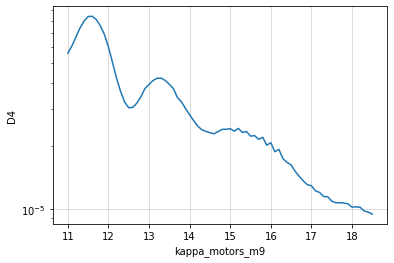

In [12]:
plot_run([[102,0,2e-9]],tth_motor,D4,log=True)

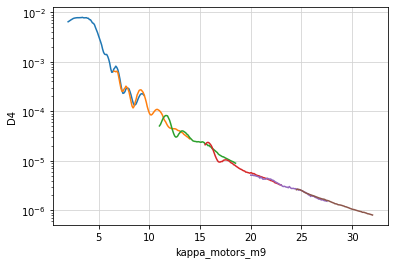

In [23]:
plot_run([[97,0,2e-7],[98,0,1e-8],[101,0,5e-9],[103,0,5e-10],[104,0,2e-10],[106,0,1e-10/5]],tth_motor,D4,log=True)

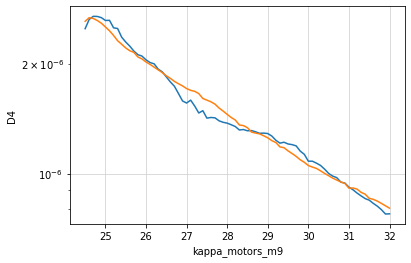

In [24]:
plot_run([[105,0,1e-10],[106,0,1e-10/5]],tth_motor,D4,log=True)

In [2]:
def d4_gain():
    print('sensitivity:' ,srs.A4.sensitivity_value.get(),srs.A4.sensitivity_unit.get())
    print('gain:',srs.A4.gain.get())
    return srs.A4.gain.get()
    
def d4_input():
    print('Input Offset:', srs.A4.offset_on.get(),'-',srs.A4.offset_cal.get())
    print('Value:',srs.A4.offset_sign.get(),srs.A4.offset_fine.get())
    print('Gain:',srs.A4.offset_value.get(),srs.A4.offset_unit.get())
    # TODO: return value * gain

    
def th2th_plan(start,stop,step,offset):
    npts=int((stop-start)/step+1)
    yield from bp.scan([scaler,D4calc],kth_motor,start+offset,stop+offset,tth_motor,start*2,stop*2,npts)   

def plot_latest(pos,det,log=False):
    """
    pos = x_motor (object)
    det = D3
    
    """
    ds=cat[-1].primary.read()
    #ds.plot.scatter(x=pos.name,y=det.name)
    plt.plot(ds[pos.name], ds[det.name])
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    plt.grid(color='lightgrey')
    if log == True:
        plt.yscale('log')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()
    
def plot_latest_plan(pos,det,log=False):
    """
    pos = x_motor (object)
    det = D3
    
    """
    plot_latest(pos,det)
    yield from bps.null()

    
def plot_scatter(run,pos,det,log=False):
    """
    pos= x_motor (object)
    det=D3
    
    """
    ds=cat[run].primary.read()
    ds.plot.scatter(x=pos.name,y=det.name)
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    if log == True:
        plt.yscale('log')
    plt.grid(color='lightgrey')

def plot_run(runlist,pos,det,log=False):
    """
    pos= x_motor (object)
    det=D3
    """
    A=0
    i=1
    for n in runlist:
        if isinstance(n,list):
            A=n[1]
            i=n[2]
            n=n[0]
        ds=cat[n].primary.read()
        plt.plot(ds[pos.name], ds[det.name]*i+A)
    if log:
        plt.yscale('log')
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    plt.grid(color='lightgrey')
    
        
def find_z(pos,det,ds=None):
    """
    ds = cat[-1].primary.read()
    det='D3'
    pos='kappa_motors_m4'
    """
    if ds == None:
        ds = cat[-1].primary.read()
    half_intensity=float((np.max(ds[det.name])-np.min(ds[det.name]))/2)
    
    # array
    y_arr = ds[det.name]
    print("Array is : ", np.array(y_arr))

    # element to which nearest value is to be found
    y = half_intensity
    print("Value to which nearest element is to be found: ", y)

    # calculate the difference array
    difference_array = np.absolute(y_arr-y)

    # find the index of minimum element from the array
    index = difference_array.argmin()
    print("Nearest element to the given values is : ", float(y_arr[index]))
    print("Index of nearest value is : ", int(index))


    x_arr = np.array(ds[pos.name])
    print("Corresponding motor position of nearest value is : ", (x_arr[int(index)]))

        
def make_scan_list(StartStopStepLists):
    """
    Creates and returns a np.array with values based on StartStopStepList
    StartStopStepList is a list of lists defining regions for a table array
              StartStopStepList[[start1,stop1,step1],[start1,stop1,step1],...]
    Automatically removes duplicates and sorts into ascending order
    if you want descending
               myarray=XAS_Table(StartStopStepLists)[::-1]
    """
    table_array=np.array([])
    if type(StartStopStepLists) is not list:
        start=StartStopStepLists[0]
        stop=StartStopStepLists[1]
        step=StartStopStepLists[2]
        j=start
        while j<=stop:
            table_array=np.append(table_array, j)
            j+=step
    else:
        for i in range(0,len(StartStopStepLists)):
            start=StartStopStepLists[i][0]
            stop=StartStopStepLists[i][1]
            step=StartStopStepLists[i][2]
            j=start
            while j<=stop:
                table_array=np.append(table_array, j)
                j+=step
    table_array=np.unique(table_array)#removing duplicate
    table_array=np.sort(table_array) #sort into ascending order    

    return table_array.tolist()
  
    

In [29]:
def test(th_start,th_stop,th_step,x_start,x_step):
    npts=int((th_stop-th_start)/th_step+1)
    x_stop=x_start+npts*x_step
    print(npts,x_start,x_stop,x_step)

In [32]:
test(1,12,0.05,0,5)

221 0 1105 5


In [34]:
def test2(th_start,th_stop,th_step,x_start,x_stop):
    npts=int((th_stop-th_start)/th_step+1)
    x_step=(x_stop-x_start)/npts
    print(npts,x_start,x_stop,x_step)

In [35]:
test2(1,12,0.05,0,1105)

221 0 1105 5.0


In [4]:
# Import math Library
from math import sin,radians


In [8]:

# Return the sine value of 30 degrees
print(sin(radians(30)))

# Return the sine value of 1 degrees
print(sin(radians(1)))

0.49999999999999994
0.01745240643728351


In [13]:
0.5/sin(radians(1))

28.649344249275092

In [14]:
0.5/sin(radians(2))

14.326854173921912

In [15]:
0.5/sin(radians(3))

9.5536613046487

In [16]:
0.5/sin(radians(4))

7.167793513101838

In [18]:
0.5/sin(radians(10))

2.879385241571817

In [20]:
scaler.select_channels(['D3'])



Transient Scan ID: 90     Time: 2021-12-03 21:44:56
Persistent Unique Scan ID: 'be1dee08-63ce-4491-8a3f-6878356fc6c9'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4972343444824219             |
|                    mono_energy | 520.0096156                    |
|              mono_mirror_pitch | 3.6361810302734376             |
|             mono_grating_pitch | 4.9287701171875                |
|                    centroidM3R | 111.75490677134445             |
|                kappa_motors_m2 | -6603.5                        |
|                kappa_motors_m3 | 0.274                          |
|                kappa_motors_m4 | -219.937                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('be1dee08-63ce-4491-8a3f-6878356fc6c9',)

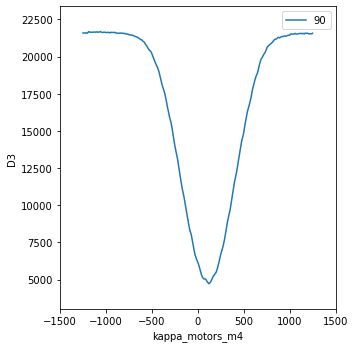

In [21]:
RE(scan([scaler],z_motor,-1250,1250,251))

In [22]:
RE(mvx(0))

()



Transient Scan ID: 91     Time: 2021-12-03 21:49:42
Persistent Unique Scan ID: '0c1116d1-2d80-4dfe-bf7c-b38779e22453'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 520.0004276                    |
|              mono_mirror_pitch | 3.6362036132812503             |
|             mono_grating_pitch | 4.928732885742187              |
|                    centroidM3R | 111.66557835820896             |
|                kappa_motors_m2 | 0.036000000000000004           |
|                kappa_motors_m3 | 0.275                          |
|                kappa_motors_m4 | -250.284                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('0c1116d1-2d80-4dfe-bf7c-b38779e22453',)

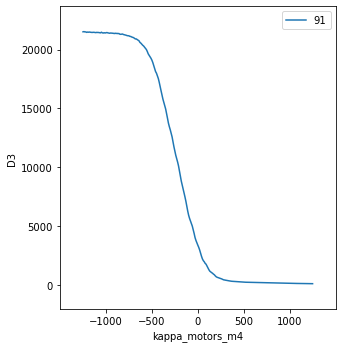

In [23]:
RE(scan([scaler],z_motor,-1250,1250,251))

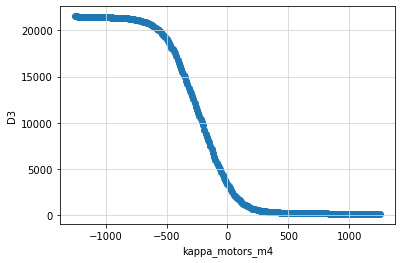

In [24]:
plot_scatter(-1,z_motor,D3)

In [25]:
find_z(z_motor,D3)

Array is :  [21503. 21520. 21494. 21496. 21454. 21482. 21468. 21482. 21468. 21455.
 21450. 21460. 21459. 21443. 21434. 21456. 21445. 21445. 21428. 21413.
 21468. 21418. 21398. 21426. 21402. 21419. 21440. 21414. 21401. 21380.
 21400. 21393. 21378. 21377. 21355. 21383. 21359. 21373. 21349. 21361.
 21306. 21290. 21305. 21315. 21273. 21253. 21226. 21211. 21179. 21173.
 21161. 21116. 21106. 21062. 21034. 21009. 20950. 20897. 20898. 20846.
 20798. 20737. 20602. 20540. 20447. 20362. 20297. 20199. 20091. 19999.
 19832. 19631. 19511. 19378. 19256. 19096. 18891. 18636. 18385. 18131.
 17986. 17757. 17538. 17214. 16840. 16491. 16139. 15791. 15511. 15196.
 14947. 14530. 14160. 13752. 13449. 13186. 12878. 12579. 12153. 11744.
 11376. 11023. 10737. 10450. 10119.  9716.  9265.  8835.  8508.  8151.
  7877.  7492.  7126.  6694.  6293.  5935.  5667.  5440.  5242.  5008.
  4707.  4385.  4033.  3788.  3578.  3394.  3207.  2986.  2718.  2456.
  2231.  2078.  1984.  1849.  1775.  1620.  1460.  1316.  1190.  

In [ ]:
RE(mvz(-230))

In [26]:
RE(mvx(6600))

()



Transient Scan ID: 92     Time: 2021-12-03 21:53:54
Persistent Unique Scan ID: '9dcffdd2-7635-4b42-b55f-649f50fc0292'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 519.9945035                    |
|              mono_mirror_pitch | 3.636177368164063              |
|             mono_grating_pitch | 4.92874814453125               |
|                    centroidM3R | 111.95574341123819             |
|                kappa_motors_m2 | 6600.037                       |
|                kappa_motors_m3 | 0.291                          |
|                kappa_motors_m4 | -1230.147                      |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.755                        |
|        

('9dcffdd2-7635-4b42-b55f-649f50fc0292',)

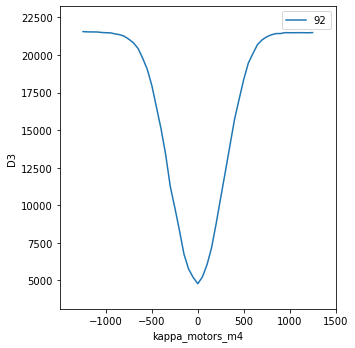

In [27]:
RE(scan([scaler],z_motor,-1250,1250,51))

In [28]:
peaks

{
'com':
    {'D3': 2.6752268890807196}
,
'cen':
    {'D3': -9.1742756512445}
,
'max':
    {'D3': (-1249.9850000000001,
            21555.0)}
,
'min':
    {'D3': (-0.007,
            4784.0)}
,
'fwhm':
    {'D3': 671.8520337636736}
,
}

In [30]:
RE(mvz(-1250))

()

In [31]:
RE(mvx(-6600))

()



Transient Scan ID: 93     Time: 2021-12-03 21:56:54
Persistent Unique Scan ID: 'fd564df1-f4ba-42d0-8b83-08197f8265c1'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49751967191696167            |
|                    mono_energy | 519.9977089                    |
|              mono_mirror_pitch | 3.6361541748046875             |
|             mono_grating_pitch | 4.928737768554687              |
|                    centroidM3R | 111.78970452446907             |
|                kappa_motors_m2 | -6600.041                      |
|                kappa_motors_m3 | 0.258                          |
|                kappa_motors_m4 | -1249.942                      |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('fd564df1-f4ba-42d0-8b83-08197f8265c1',)

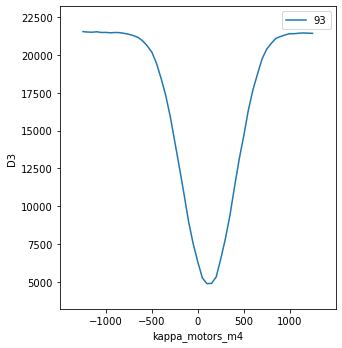

In [32]:
RE(scan([scaler],z_motor,-1250,1250,51))

In [33]:
peaks

{
'com':
    {'D3': -32.470765524946074}
,
'cen':
    {'D3': 117.20971730196197}
,
'max':
    {'D3': (-1249.997,
            21548.0)}
,
'min':
    {'D3': (100.001,
            4880.0)}
,
'fwhm':
    {'D3': 673.6675171024508}
,
}

In [34]:
mprint()

x,y,z,tth,th,chi,phi = [-0.0,0.0,-1250.0,0.0,57.05,134.75600000000003,57.05]


[-0.0, 0.0, -1250.0, 0.0, 57.05, 134.75600000000003, 57.05]



Transient Scan ID: 94     Time: 2021-12-03 22:00:58
Persistent Unique Scan ID: '5eba10eb-9b0d-4298-9ef9-787e4a21e02c'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.0048285                    |
|              mono_mirror_pitch | 3.63620849609375               |
|             mono_grating_pitch | 4.928751196289062              |
|                    centroidM3R | 114.80292995198818             |
|                kappa_motors_m2 | -0.025                         |
|                kappa_motors_m3 | 0.275                          |
|                kappa_motors_m4 | -1250.25                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.045142381790015             |
|                kappa_motors_m7 | 134.75600000000003             |
|        

('5eba10eb-9b0d-4298-9ef9-787e4a21e02c',)

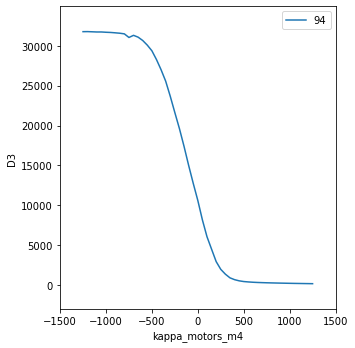

In [35]:
RE(scan([scaler],z_motor,-1250,1250,51))

In [36]:
RE(mvz(-250))

()

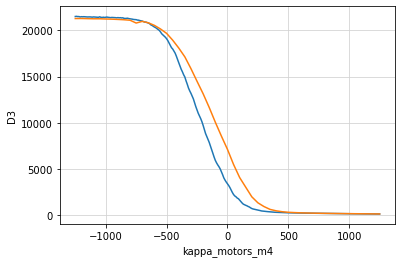

In [43]:
plot_run([91,[94,0,0.67]],z_motor,D3)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


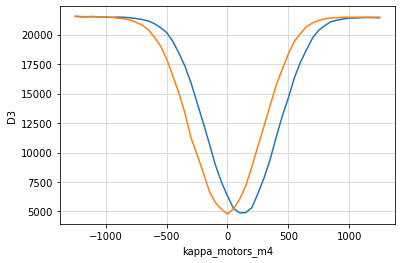

In [101]:
plot_run([93,[92,0,1]],z_motor,D3)

In [44]:
scaler.select_channels(['D4'])

In [45]:
RE(mvtth(0))

()

In [47]:
RE(mvkth(myomega))

()

States: 
 - 0 pA/V
 - 1 nA/V
 - 2 uA/V
 - 3 mA/V

States: 
- 0 1
- 1 2
- 2 5
- 3 10
- 4 20
- 5 50
- 6 100
- 7 200
- 8 500

In [71]:
komega=57.322396707958816

In [86]:
th2thx_plan_test(1,10,0.05,1500,5,komega)

npts: 181
x_start: 1500
x_stop: 2405
x_step: 5


In [87]:
th2thx_plan_test(8,28,0.05,2600,5,komega)

npts: 401
x_start: 2600
x_stop: 4605
x_step: 5


In [88]:
RE(uank(1,0.5+komega))

()

In [89]:
srs4.sensitivity_unit.put(1);RE(bps.sleep(1)); u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(7); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

200 nA/V


sensitivity: 200 nA/V
gain: 2.0000000000000002e-07


Transient Scan ID: 97     Time: 2021-12-03 22:32:38
Persistent Unique Scan ID: 'c086625b-9894-4cfa-ac10-ebf676a373e4'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4974483549594879             |
|                    mono_energy | 520.0078753                    |
|              mono_mirror_pitch | 3.636229248046875              |
|             mono_grating_pitch | 4.928706030273438              |
|                    centroidM3R | 111.47152409499654             |
|                kappa_motors_m2 | 1355.926                       |
|                kappa_motors_m3 | 0.298                          |
|                kappa_motors_m4 | -250.172                       |
|                kappa_motors_m9 | 1.0                            |
|                kappa_motors_m8 | 57.82214238179                 |
|                kappa_mot

('c086625b-9894-4cfa-ac10-ebf676a373e4',)

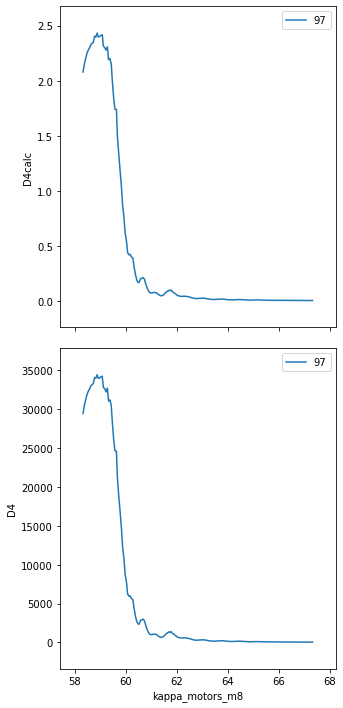

In [90]:
g=d4_gain();RE(th2thx_plan(1,10,0.05,1500,5,komega))

In [91]:
srs4.sensitivity_unit.put(0); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(7); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

200 pA/V


In [92]:
RE(uank(15,7.5+komega))

()

sensitivity: 200 pA/V
gain: 2e-10


Transient Scan ID: 98     Time: 2021-12-03 22:35:08
Persistent Unique Scan ID: 'a2dc8c51-bf41-45a8-b6a5-98823ab7aad7'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49751967191696167            |
|                    mono_energy | 519.9997664                    |
|              mono_mirror_pitch | 3.6361932373046875             |
|             mono_grating_pitch | 4.928724951171875              |
|                    centroidM3R | 111.21469771416363             |
|                kappa_motors_m2 | 2405.071                       |
|                kappa_motors_m3 | 0.28300000000000003            |
|                kappa_motors_m4 | -250.119                       |
|                kappa_motors_m9 | 14.999                         |
|                kappa_motors_m8 | 64.82214238179                 |
|                kappa_motors_m7 | 134.7560

('a2dc8c51-bf41-45a8-b6a5-98823ab7aad7',)

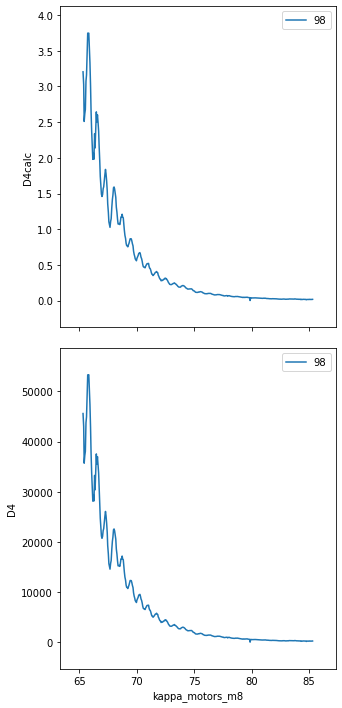

In [93]:
g=d4_gain();RE(th2thx_plan(8,28,0.05,2600,5,komega))

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


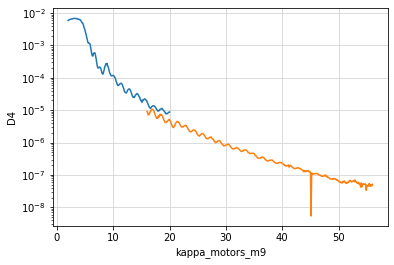

In [99]:
plot_run([[97,0,200e-9],[98,0,200e-12]],tth_motor,D4,log=True)

In [100]:
scaler.select_channels()